In [2]:
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import gymnasium as gym
import pandas as pd
import numpy as np
import json
import time
import yaml
import os
import torch
from copy import deepcopy

2024-07-12 18:26:50.514609: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 18:26:50.536675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 18:26:50.536719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 18:26:50.537378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 18:26:50.541570: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-07-03 12:45:12.788382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 12:45:12.789095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 12:45:12.789175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17364595350817139493
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10735779840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3921729548971194674
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

L355
2024-07-03 12:45:12.842445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 12:45:12.842509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 12:45:12.842559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 10238 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


# Dummy

In [4]:
env = gym.make('MountainCar-v0')
state = env.reset()[0]

In [10]:
env.action_space.sample()

2

In [204]:
state

array([-0.45947498,  0.        ], dtype=float32)

([<matplotlib.axis.XTick at 0x75a103af2020>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

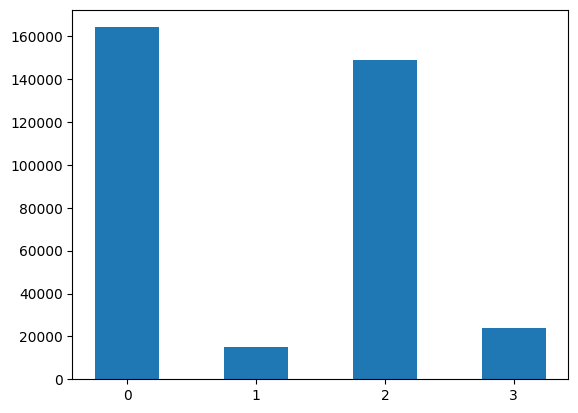

In [121]:
values, counts = np.unique(action, return_counts=True)

plt.bar(values, counts, width = 0.5, align='center')
plt.xticks([0,1,2,3])

In [198]:
from b_policy.model import PolicyNetwork

path = os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'train', 'model_38')
with open(os.path.join(path, 'config.yaml')) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = PolicyNetwork(
    n_state=len(config['target_cols']),
    n_latent_action=config['n_latent_action'],
    units=config['units'],
    layer_num=config['layer_num'],
    batch_size=1
)
model.build_graph()
model.load_weights(os.path.join(path, 'best_weights'))

p = os.path.join(os.getcwd(), 'data', 'row', 'MountainCar-v0', 'expert_data_1', 'senario_50.json')
with open(p) as f:
    dict_train = json.load(f)

pos_min = -1.2
pos_max = 0.6
v_min = -0.07
v_max = 0.07

pos = np.array(dict_train['pos'])
v = np.array(dict_train['v'])

# pos = (pos - pos_min) / (pos_max - pos_min)
# v = (v - v_min) / (v_max - v_min)
# a = np.array(dict_train['a'])
action = np.array(dict_train['action'])

delta_pos = pos[1:] - pos[:-1]
delta_v = v[1:] - v[:-1]

z_p, delta_s_hat = model(np.stack((pos,v), axis=1))

max_z = tf.expand_dims(tf.one_hot(tf.argmax(z_p, axis=-1), config['n_latent_action']), axis=-1)
max_delta_s_hat = tf.reduce_sum(tf.multiply(delta_s_hat, tf.cast(max_z, dtype=tf.float32)), axis=1)
exp_delta_s_hat = tf.reduce_sum(tf.multiply(delta_s_hat, tf.expand_dims(z_p, axis=-1)), axis=1)

Model: "policy_network_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state_embedding_39 (StateE  (None, 64)                2208      
 mbedding)                                                       
                                                                 
 State_Embedding_lrelu_top   (None, 64)                0         
 (LeakyReLU)                                                     
                                                                 
 State_Embedding_Dense_top   (None, 8)                 520       
 (Dense)                                                         
                                                                 
 Action_Probability_Softmax  (None, 8)                 0         
  (Softmax)                                                      
                                                                 
 Action_Embedding_Dense (De  multiple            

Text(0.5, 1.0, 'Prediction of model : v')

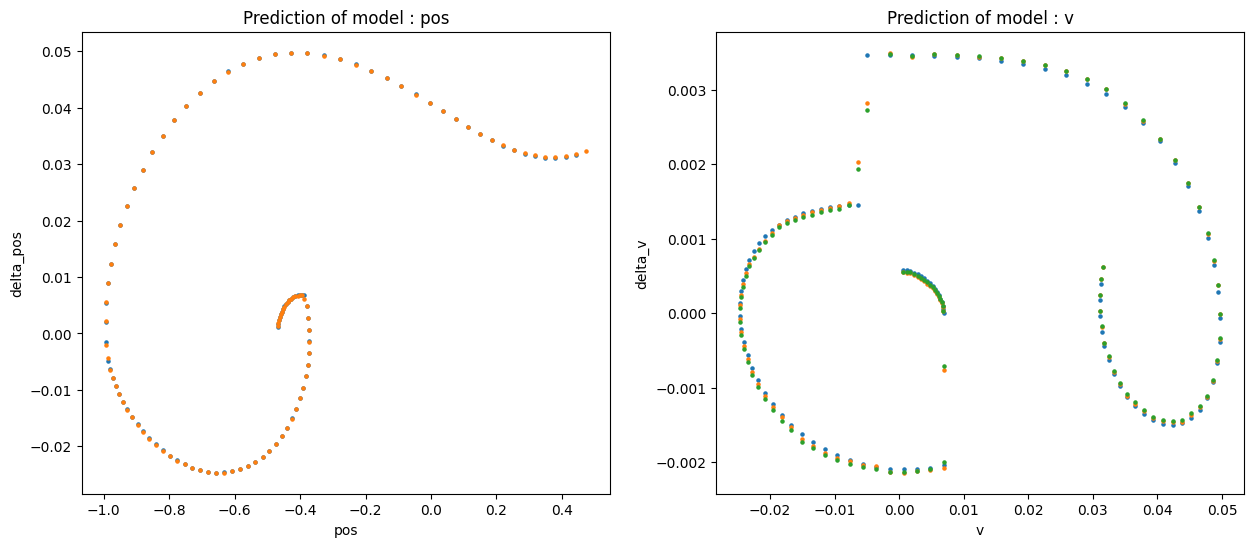

In [199]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
# plt.scatter(dict_train['pos'][:36], dict_train['v'][:36], s = 5)
# plt.scatter(delta_pos[np.where(np.reshape(dict_train['action'],-1)==0)], delta_v[np.where(np.reshape(dict_train['action'],-1)==0)], s = 5)
# plt.scatter(delta_pos[np.where(np.reshape(dict_train['action'],-1)==2)], delta_v[np.where(np.reshape(dict_train['action'],-1)==2)], s = 5)
# plt.scatter(pos[np.where(np.reshape(dict_train['action'],-1)==0)], delta_pos[np.where(np.reshape(dict_train['action'],-1)==0)], s = 5)
# plt.scatter(pos[np.where(np.reshape(dict_train['action'],-1)==2)], delta_pos[np.where(np.reshape(dict_train['action'],-1)==2)], s = 5)
plt.scatter(pos[:-1], delta_pos, s = 5, label='GT')
plt.scatter(pos, max_delta_s_hat[:,0], s = 5, label='Pred')
plt.xlabel('pos')
plt.ylabel('delta_pos')
plt.title('Prediction of model : pos')


plt.subplot(1,2,2)
plt.scatter(v[:-1], delta_v, s = 5, label = 'GT')
plt.scatter(v, max_delta_s_hat[:,1], s = 5, label = 'Pred')
plt.scatter(v, exp_delta_s_hat[:,1], s = 5, label = 'Exp')
plt.xlabel('v')
plt.ylabel('delta_v')
plt.title('Prediction of model : v')

In [197]:
tf.argmax(z_p, axis=-1)

<tf.Tensor: shape=(103,), dtype=int64, numpy=
array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])>

In [117]:
s = np.load("data/preprocessed/MountainCar-v0/expert_data_3/policy/data_0/s_30.npy")
s_next = np.load("data/preprocessed/MountainCar-v0/expert_data_3/policy/data_0/s_next_30.npy")

In [156]:
a = tf.constant([[[1,2], [3,4]], [[1,1], [2,2]]], dtype=tf.float32)
b = tf.constant([[[0.2], [0.8]], [[0.6], [0.4]]], dtype=tf.float32)
x = a*b

In [157]:
x

<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.2, 0.4],
        [2.4, 3.2]],

       [[0.6, 0.6],
        [0.8, 0.8]]], dtype=float32)>

In [159]:
tf.reduce_sum(x, axis=1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2.6000001, 3.6000001],
       [1.4000001, 1.4000001]], dtype=float32)>

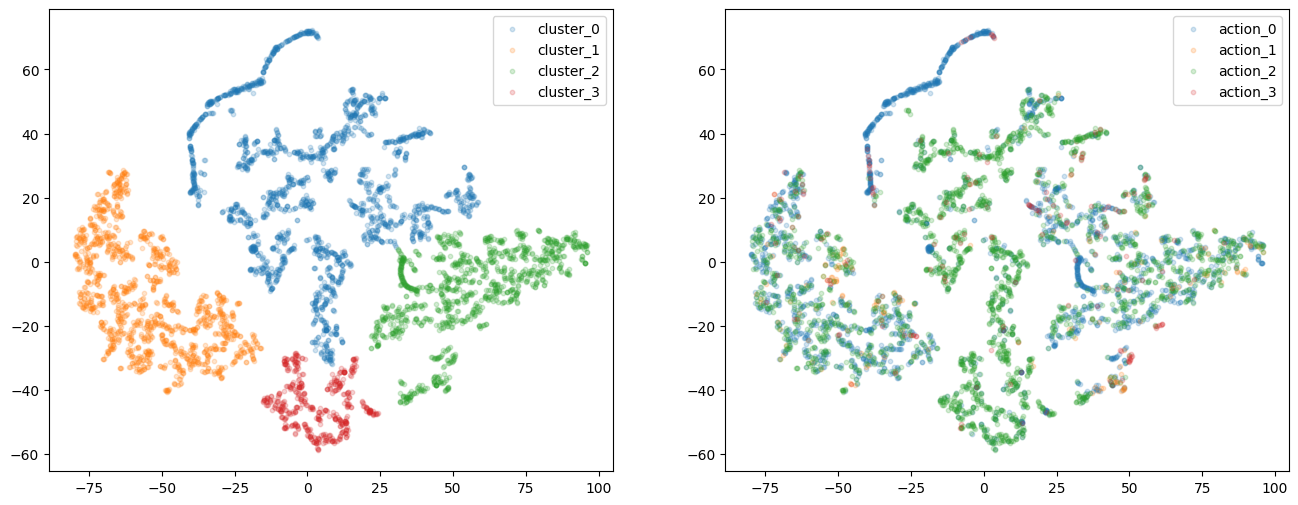

In [131]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering

num_c = 4

tsne = TSNE(n_components=2, perplexity=30)
delta_s_r = tsne.fit_transform(delta_s[:5000, [0,2,4]])

kmeans = AgglomerativeClustering(n_clusters=num_c)

# kmeans.fit(delta_s_r)
# result = kmeans.predict(delta_s_r)
result = kmeans.fit_predict(delta_s_r)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for n in range(num_c):
    idx = np.where(result == n)
    plt.scatter(delta_s_r[idx,0], delta_s_r[idx,1], s=10, alpha=0.2, label=f'cluster_{n}')
plt.legend()

plt.subplot(1,2,2)
n_action = len(np.unique(action))
for n in range(n_action):
    idx = np.where(action[:5000] == n)
    plt.scatter(delta_s_r[idx,0], delta_s_r[idx,1], s=10, alpha=0.2, label=f'action_{n}')
plt.legend()

In [65]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering

num_c = 4

tsne = TSNE(n_components=3, perplexity=30)
delta_s_r = tsne.fit_transform(delta_s[:1000])

kmeans = AgglomerativeClustering(n_clusters=num_c)

# kmeans.fit(delta_s_r)
# result = kmeans.predict(delta_s_r)
result = kmeans.fit_predict(delta_s_r)

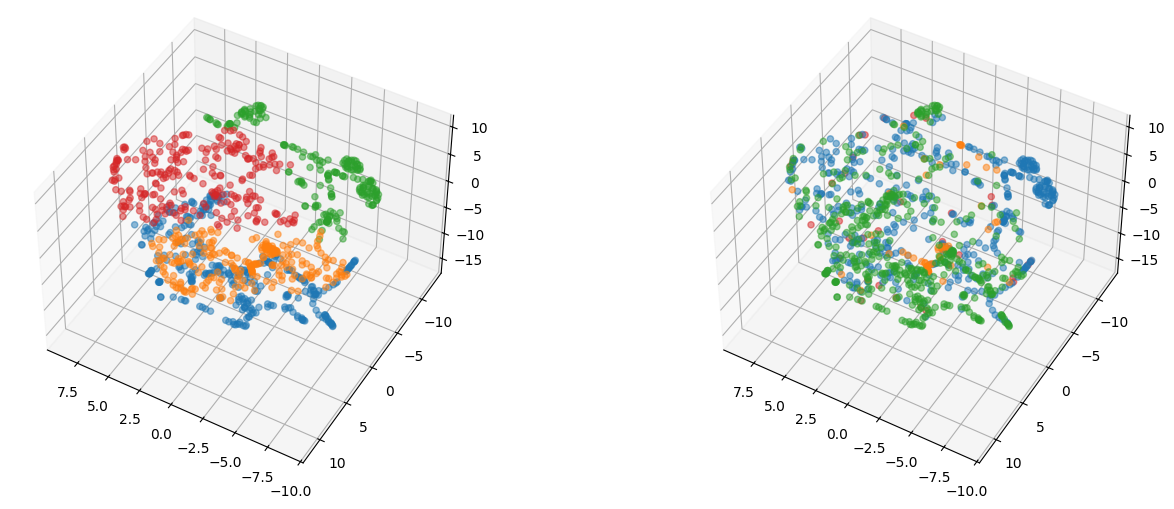

In [66]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121, projection='3d')
for n in range(num_c):
    idx = np.where(result == n)
    ax.scatter(delta_s_r[idx,0], delta_s_r[idx,1], delta_s_r[idx,2], alpha=0.5, label=f'cluster_{n}')
# plt.legend()
ax.view_init(elev=45., azim=120)

ax = fig.add_subplot(122, projection='3d')
n_action = len(np.unique(action))
for n in range(n_action):
    idx = np.where(action[:1000] == n)
    ax.scatter(delta_s_r[idx,0], delta_s_r[idx,1], delta_s_r[idx,2], alpha=0.5, label=f'action_{n}')
# plt.legend()
ax.view_init(elev=45., azim=120)

(-0.05, 0.05)

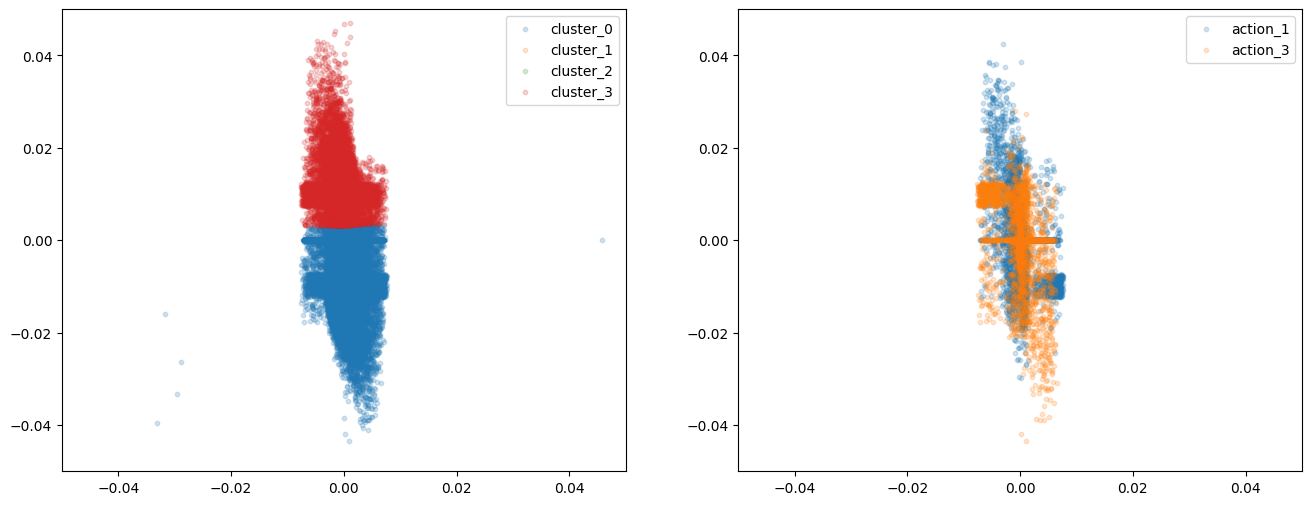

In [178]:
kmeans = KMeans(n_clusters=num_c)

# kmeans.fit(delta_s_r)
# result = kmeans.predict(delta_s_r)
result = kmeans.fit_predict(delta_s[0:100000, [0,2]])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for n in range(num_c):
    idx = np.where(result == n)
    plt.scatter(delta_s[0:100000, [0, 2]][idx,0], delta_s[0:100000, [0, 2]][idx,1], s=10, alpha=0.2, label=f'cluster_{n}')
    # plt.scatter([n]*len(idx[0]), delta_s[0:100000,5][idx], s=10, alpha=0.2, label=f'cluster_{n}')
plt.legend()
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

plt.subplot(1,2,2)
n_action = len(np.unique(action))
# for n in range(n_action):
for n in [1,3]:
    idx = np.where(action[0:100000] == n)
    plt.scatter(delta_s[0:100000, [0, 2]][idx,0], delta_s[0:100000, [0, 2]][idx,1], s=10, alpha=0.2, label=f'action_{n}')
    # plt.scatter([n]*len(idx[0]), delta_s[0:100000,5][idx], s=10, alpha=0.2, label=f'action_{n}')
plt.legend()
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

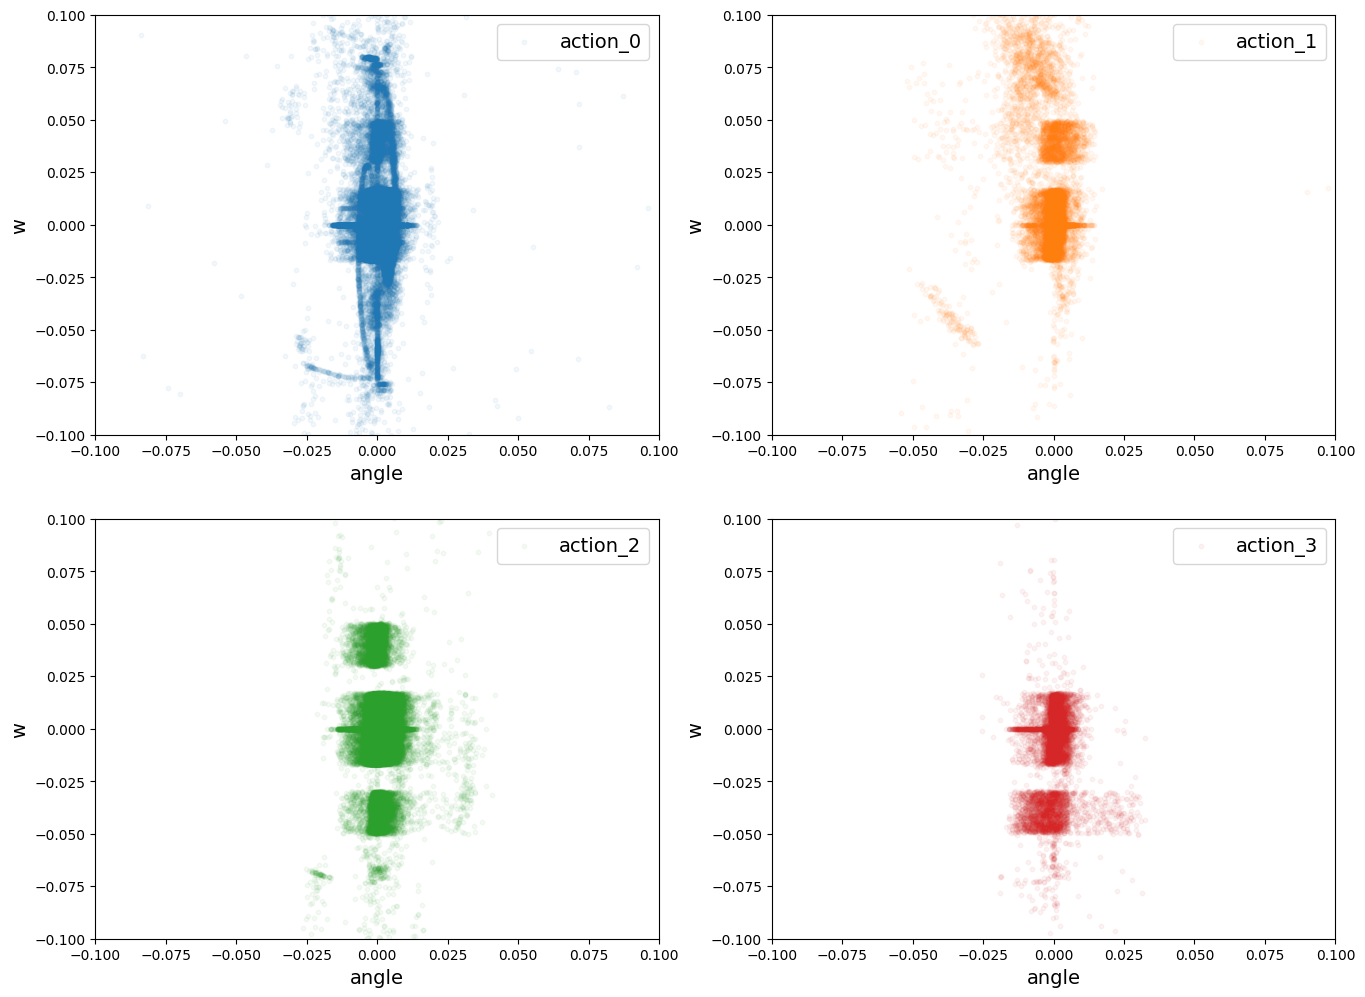

In [195]:
dict_param = {0:'pos_x', 1:'pos_y', 2:'v_x', 3:'v_y', 4:'angle', 5:'w'}
param=[4, 5]

plt.figure(figsize=(16,12))
n_action = len(np.unique(action))
for n in range(n_action):
    plt.subplot(2,2,n+1)
    idx = np.where(action[0:-1] == n)
    plt.scatter(delta_s[0:-1, param][idx,0], delta_s[0:-1, param][idx,1], s=10, alpha=0.05, label=f'action_{n}', color = plt.cm.tab10(n))
    # plt.scatter([n]*len(idx[0]), delta_s[0:-1,5][idx], s=10, alpha=0.2, label=f'action_{n}')
    plt.legend(fontsize=14)
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.xlabel(dict_param[param[0]], fontsize=14)
    plt.ylabel(dict_param[param[1]], fontsize=14)

In [202]:
ylim = max(np.max(delta_s[:, param[0]]), abs(np.min(delta_s[:, param[0]])))

In [203]:
ylim

0.64074427

In [199]:
dict_param = {0:'pos_x', 1:'pos_y', 2:'v_x', 3:'v_y', 4:'angle', 5:'w'}
len(dict_param)

6

In [200]:
l = ['a','b','c','d','e','f']
d = {}
for i in range(len(l)):
    d[i] = l[i]

In [201]:
d

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f'}

# Model load test

In [15]:
from b_policy.model import PolicyNetwork

path = os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'train', 'model_23')
with open(os.path.join(path, 'config.yaml')) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = PolicyNetwork(
    n_state=len(config['target_cols']),
    n_latent_action=config['n_latent_action'],
    units=config['units'],
    layer_num=config['layer_num'],
    batch_size=1
)
model.build_graph()
model.load_weights(os.path.join(path, 'best_weights'))

In [29]:
data_path = os.path.join(os.getcwd(), 'data', 'row', 'LunarLander-v2', 'expert_data_0')
with open(os.path.join(data_path, 'senario_0.json')) as f:
    data = json.load(f)

state = [data['pos_x'], data['pos_y'], data['v_x'], data['v_y'], data['angle'], data['w']]
state = np.transpose(state)
max = np.array([1.5, 1.5, 5., 5., 3.14, 5.])
min = np.array([-1.5, -1.5, -5., -5., -3.14, -5.])
state = np.divide(np.subtract(state, min), np.subtract(max, min))
s_next, s = state[1:,:], state[:-1,:]
delta_s = s_next - s

In [84]:
z_p, delta_s_hat = model(s[1:2])

In [85]:
delta_s_max = tf.multiply(tf.reshape(delta_s_hat, (3, 6)), tf.expand_dims(tf.one_hot(tf.argmax(tf.reshape(z_p, (3,)), axis=-1), 3), axis=-1))

In [86]:
tf.reduce_sum(delta_s_max, axis=0)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-0.00250435, -0.00268843,  0.0012047 , -0.00036039,  0.00013874,
       -0.00165592], dtype=float32)>

In [87]:
delta_s[1]

array([-2.03250286e-03, -2.49127547e-03,  1.14588737e-03, -2.69287825e-03,
        9.39330762e-05, -4.59514586e-03])

In [2]:
p = os.path.join(os.getcwd(), 'data/preprocessed/LunarLander-v2/expert_data_0/policy/data_1/max_0.02.npy')
max = np.load(p)

# Gym

In [ ]:
import gym
from stable_baselines3 import DQN

env = gym.make('LunarLander-v2', render_mode = "human")

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("runs/dqn_lunarlander")

obs = env.reset()
for i in tqdm(range(1000)):
    action, _states = model.predict(obs[0], deterministic=True)
    obs = env.step(action)
    env.render()

In [ ]:
import gymnasium as gym

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Instantiate the agent
model = DQN("MlpPolicy", env, verbose=1, gamma=0.99, learning_rate=0.0001)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e5), progress_bar=True)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# Save the agent
model.save("runs/expert/dqn_lunar")
del model  # delete trained model to demonstrate loading

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1,
            gamma=0.95, n_steps=2048, ent_coef=0.01, learning_rate=2.5e-4, vf_coef=0.5)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e6), progress_bar=True)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# Save the agent
model.save("runs/ppo_lunar")

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy


# Evaluate the agent
eval_env = gym.make('LunarLander-v2')
model = PPO.load("runs/expert/lunar_lander/ppo-LunarLander-v2")
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = eval_env.reset()
for i in range(1000):
    action, _state = model.predict(obs[0])
    # obs, reward, done, info = eval_env.step(action)
    obs = eval_env.step(action)
    eval_env.render()
    if obs[2]:
        obs = eval_env.reset()
eval_env.close()

/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


mean_reward=267.81 +/- 25.41805570634785


/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/envs/box2d/lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
env = gym.make('LunarLander-v2', render_mode="rgb_array")
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)


mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = eval_env.reset()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward=264.20 +/- 13.744305420570258


In [21]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
env = gym.make('LunarLander-v2', render_mode="rgb_array")
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)

vec_env = model.get_env()
obs = vec_env.reset()

state_list = []
action_list = []

for i in range(50):
    action, _states = model.predict(obs, deterministic=True)  # 상태 저장 옵션 추가
    obs, rewards, dones, info = vec_env.step(action)
    state_list.append(obs[0])
    action_list.append(action)
    vec_env.render()
    if dones:
        break

vec_env.close()

state_list = np.array(state_list, dtype=np.float32)

/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
def serialize(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()

dict_state = {'pos_x' : list(state_list[:,0]),
            'pos_y' : list(state_list[:, 1]),
            'v_x' : list(state_list[:, 2]),
            'v_y' : list(state_list[:, 3]),
            'angle' : list(state_list[:, 4]),
            'w' : list(state_list[:, 5]),
            'is_grounded_left' : list(state_list[:, 6]),
            'is_grounded_right' : list(state_list[:, 7]),
            'action' : action_list
            }

num = len(glob(os.path.join(os.getcwd(), 'data', 'lunar_lander', 'expert_data*')))
save_path = os.path.join(os.getcwd(), 'data', 'lunar_lander')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(os.path.join(save_path, f'expert_data_{num}.json'), 'w') as f:
    json.dump(dict_state, f, default=serialize)

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

env = gym.make("LunarLander-v2")
env.reset()

# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = DQN.load("dqn_lunar", env=env, print_system_info=True)
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)

eval_env = gym.make('LunarLander-v2')
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()
env.close()

2024-05-12 20:01:58.129111: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 20:01:58.856935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=222.48 +/- 72.24385949967981


ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [3]:
base_path = os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'train')
model_paths = glob(os.path.join(base_path, 'model*'))

In [13]:
for p in model_paths:
    config_path = os.path.join(p, 'config.yaml')
    with open(config_path, 'r') as file:
        config_data = yaml.safe_load(file) or {}

    if "seq" in config_data.keys():
        continue
    else:
        config_data['seq'] = 1
        with open(config_path, 'w') as file:
            yaml.dump(config_data, file, default_flow_style=False)

In [14]:
dict_r.keys()

dict_keys(['pos_x', 'pos_y', 'v_x', 'v_y', 'angle', 'w', 'is_grounded_left', 'is_grounded_right', 'action'])

# Result

## Test result : Policy

### LunarLander-v2

In [297]:
columns = ['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']
rel_metrics = []
metrics = []
models = []
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'test', 'model_*', 'test_result*'))
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean()))
    rel_metrics.append(np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_138 : [0.01051717 0.01503269 0.2541356  0.53735337 0.02521466 0.29029058]
model_14 : [0.00918446 0.01691396 0.28541829 0.57191754 0.03293714 0.2738518 ]
model_139 : [0.01205834 0.01314422 0.26023208 0.53666964 0.02931509 0.30881407]
model_135 : [0.00644281 0.0100741  0.24242683 0.50164498 0.02097769 0.29139755]
model_9 : [0.02230878 0.02973103 0.36138248 0.90850353 0.06033743 0.28664069]
model_25 : [0.0809555  0.18688706 0.92772311 0.67170533 0.46517581 0.46554757]
model_157 : [0.54143228 0.36922181 2.06829482 7.56163476 0.67584977 2.6606325 ]
model_1 : [0.0152649  0.02260842 0.30955133 0.58621427 0.09220973 0.30331555]
model_144 : [0.00278977 0.00895898 0.21427626 0.38419378 0.05621793 0.24999582]
model_33 : [0.03344037 0.02734042 0.28485757 0.56542419 0.03474196 0.30271221]
model_156 : [0.07866598 0.01705319 0.26028635 0.51084008 0.03296241 0.26882413]
model_145 : [0.00569292 0.00401999 0.21120757 0.29083431 0.01653291 0.2802266 ]
model_147 : [0.00420824 0.00817979 0.22478365 0

### MountainCar-v0

In [12]:
columns = ['rel_metric_pos', 'rel_metric_v']
rel_metrics = []
metrics = []
models = []
# paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'test', 'model_*', 'test_result*'))
# for p in paths:
for i in range(99, 108, 1):
    p = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'test', f'model_{i}', 'test_result*'))[0]
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[columns].mean()))
    rel_metrics.append(np.array(df[columns].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_99 : [0.05663175 0.02173521]
model_100 : [0.0594448  0.02083426]
model_101 : [  2.99399764 122.29091045]
model_102 : [0.05817479 0.01656083]
model_103 : [0.0865741  0.51068806]
model_104 : [0.06567033 0.03055268]
model_105 : [ 2.10014871 16.36683774]
model_106 : [0.06388334 0.03002822]
model_107 : [  0.57290014 197.24538128]


In [202]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_a']
rel_metrics = []
metrics = []
models = []
for i in range(72, 81, 1):
    p = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'test', f'model_{i}', 'test_result*'))[0]
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[columns].mean()))
    rel_metrics.append(np.array(df[columns].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_72 : [0.02369075 0.01802965 0.01092386]
model_73 : [0.03730427 0.00647121 0.00803925]
model_74 : [0.03695262 0.00504849 0.00480814]
model_75 : [0.03519382 0.00829899 0.0081857 ]
model_76 : [0.03460996 0.005578   0.00488895]
model_77 : [0.03715383 0.00764879 0.00689704]
model_78 : [0.05414853 0.01250883 0.02290926]
model_79 : [0.04198614 0.0072598  0.01285747]
model_80 : [0.03796869 0.00961573 0.01122097]


### CartPole-v1

In [4]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_angle', 'rel_metric_w']
rel_metrics = []
metrics = []
models = []
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'CartPole-v1', 'test', 'model_*', 'test_result*'))
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[columns].mean()))
    rel_metrics.append(np.array(df[columns].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_5 : [0.85499581 0.51802394 4.21275765 0.5302386 ]
model_8 : [0.6059253  0.44588998 2.85839256 0.45577663]
model_9 : [0.00527628 0.0020844  0.00972438 0.00208685]
model_25 : [0.0007637  0.14976391 0.00123708 0.14841319]
model_18 : [0.00564431 0.15126924 0.00020361 0.1497287 ]
model_1 : [0.41969327 0.46739936 3.2670567  0.47641242]
model_24 : [0.01157576 0.14527148 0.00351847 0.14410826]
model_2 : [0.24144586 0.42392215 3.95194743 0.43004921]
model_26 : [1.04714527e-04 1.39581552e-01 4.68425410e-03 1.38483949e-01]
model_4 : [1.11925909 0.4410304  5.6452401  0.44783798]
model_22 : [0.00036833 0.14842439 0.0014769  0.14722731]
model_23 : [1.45631302e-04 1.45637802e-01 9.09592718e-05 1.44466047e-01]
model_3 : [0.13485359 0.44151563 3.78400826 0.44876373]
model_19 : [0.00076508 0.14983882 0.0038735  0.14856874]
model_0 : [0.68520616 0.46361189 3.844549   0.47401961]
model_13 : [0.0210717  0.00712102 0.03105978 0.00713591]
model_6 : [2.13076634 0.49603597 4.90616614 0.50626545]
model_21

### Acrobot-v1

In [3]:
columns = ['rel_metric_cos1', 'rel_metric_sin1', 'rel_metric_cos2', 'rel_metric_sin2', 'rel_metric_w1', 'rel_metric_w1']
rel_metrics = []
metrics = []
models = []
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'Acrobot-v1', 'test', 'model_*', 'test_result*'))
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[columns].mean()))
    rel_metrics.append(np.array(df[columns].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_5 : [0.41262345 1.05568745 0.44107164 0.36834995 0.04458795 0.04458795]
model_14 : [0.47640555 0.92608601 1.38516801 0.35769021 0.01917046 0.01917046]
model_7 : [0.80652129 1.14498698 0.68106235 0.77759274 0.02838683 0.02838683]
model_8 : [0.53989872 1.27006344 0.65409251 1.15407128 0.07938341 0.07938341]
model_9 : [1.17624337 2.58747164 1.78687175 0.80851112 0.05074479 0.05074479]
model_25 : [0.27315129 0.38945956 0.28167743 0.20665049 0.32137429 0.32137429]
model_18 : [0.33690633 0.31560737 0.30942902 0.65217755 0.01433566 0.01433566]
model_1 : [0.95096805 0.98926525 0.50683434 1.07125695 0.03305784 0.03305784]
model_24 : [0.31407819 0.35123947 0.25714476 0.57561452 0.04935684 0.04935684]
model_11 : [0.84289382 0.95732166 0.71207836 0.65549712 0.03451355 0.03451355]
model_2 : [0.47971364 0.99646657 0.83619559 0.55060242 0.06354408 0.06354408]
model_26 : [0.26225415 0.79334674 0.32765456 0.21038108 0.02571879 0.02571879]
model_15 : [0.78755663 1.50481727 0.42789653 0.65579541 0.

### test latent action distribution

([<matplotlib.axis.XTick at 0x75a0fb968be0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

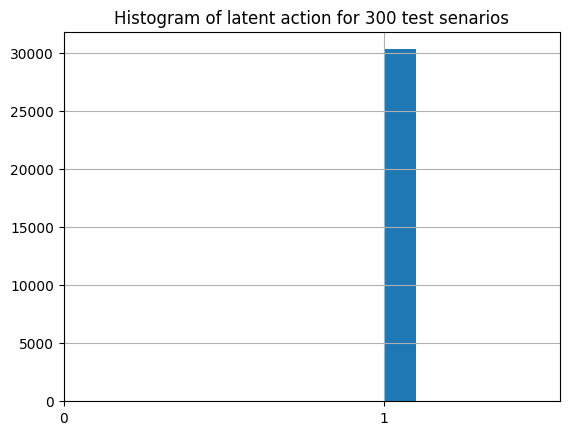

In [243]:
df['test_z'].hist()
plt.title('Histogram of latent action for 300 test senarios')
plt.xticks([0,1])

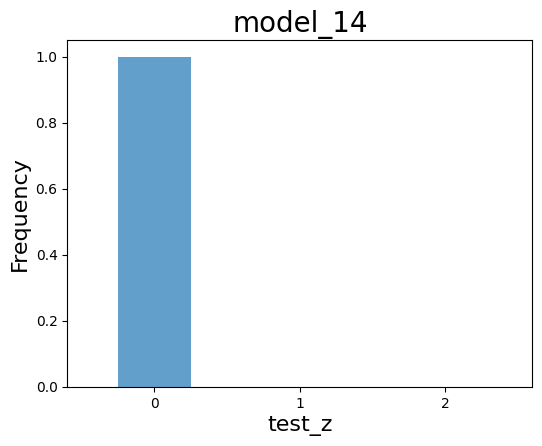

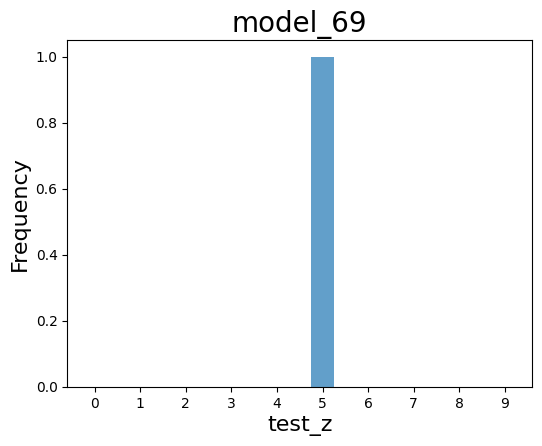

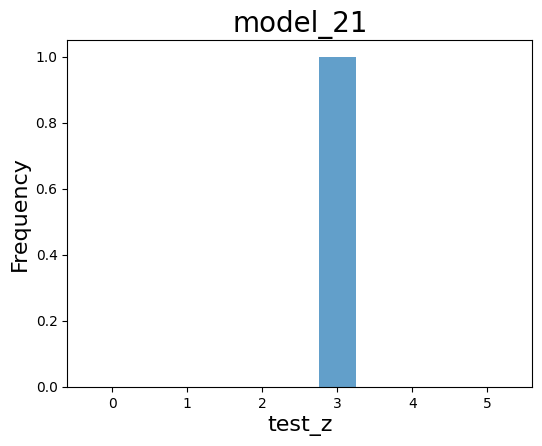

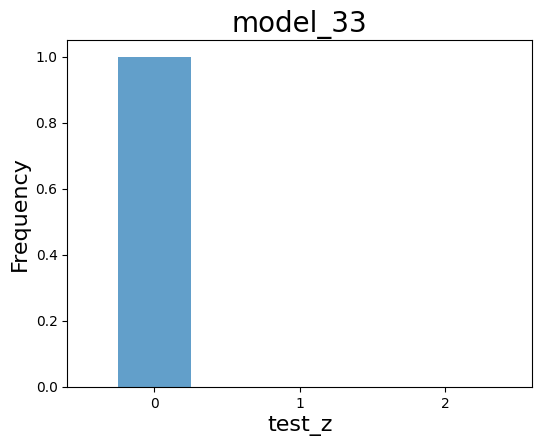

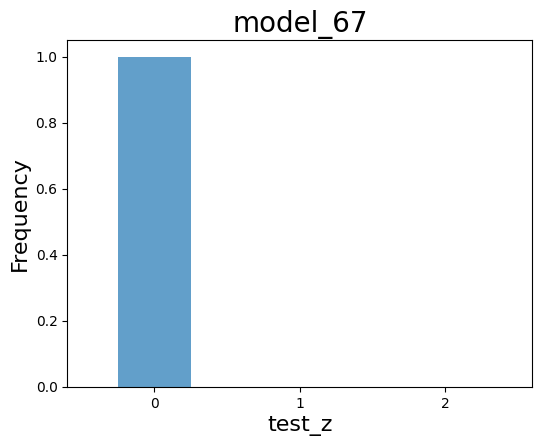

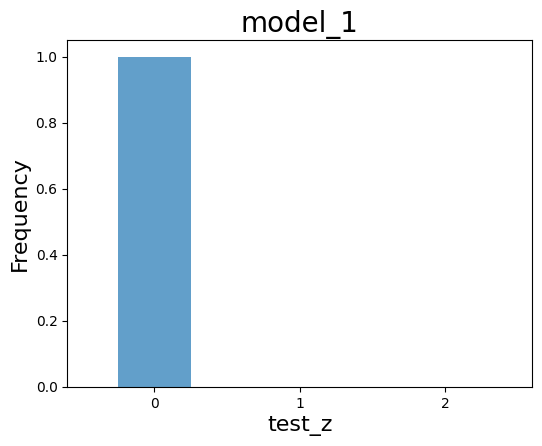

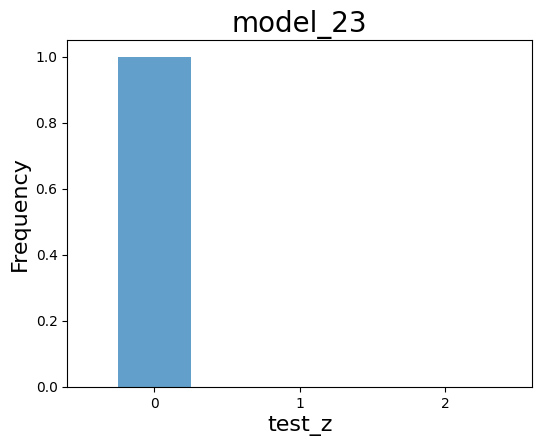

In [ ]:
for p in paths_best:
    df = pd.read_csv(p)
    num = extract_number_after_p(p.split(os.sep)[-1])
    plt.figure(figsize=(6, 4.5))
    plt.hist(df['test_z'], bins=np.arange(-0.5, num, 1), alpha=0.7, rwidth=0.5, density=True)
    # plt.title(f'Histogram of test_z : {p.split(os.sep)[-2]}, n_latent_action = {num}', fontsize=16)
    plt.title(p.split(os.sep)[-2], fontsize=20)
    plt.xlabel('test_z', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(np.arange(0, num, 1))
    plt.xlim(-0.6, num-0.4)
    plt.show()

## Test result : Action Remap

### Acrobot-v1

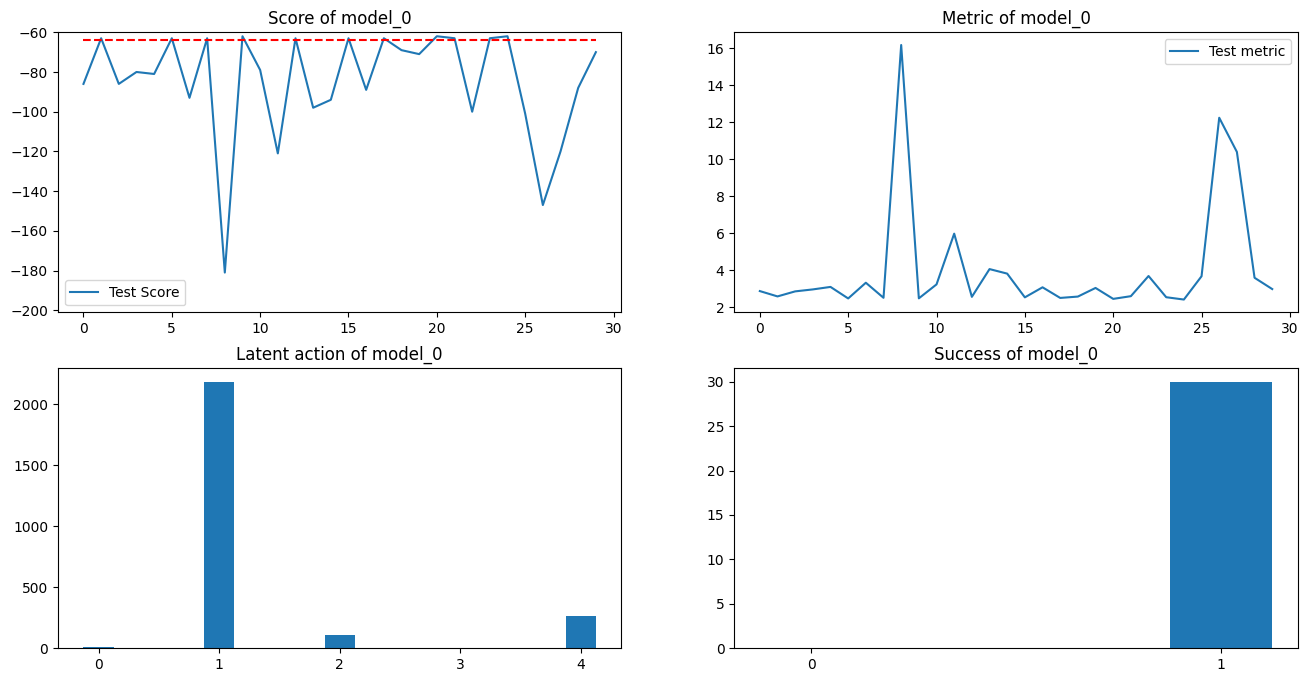

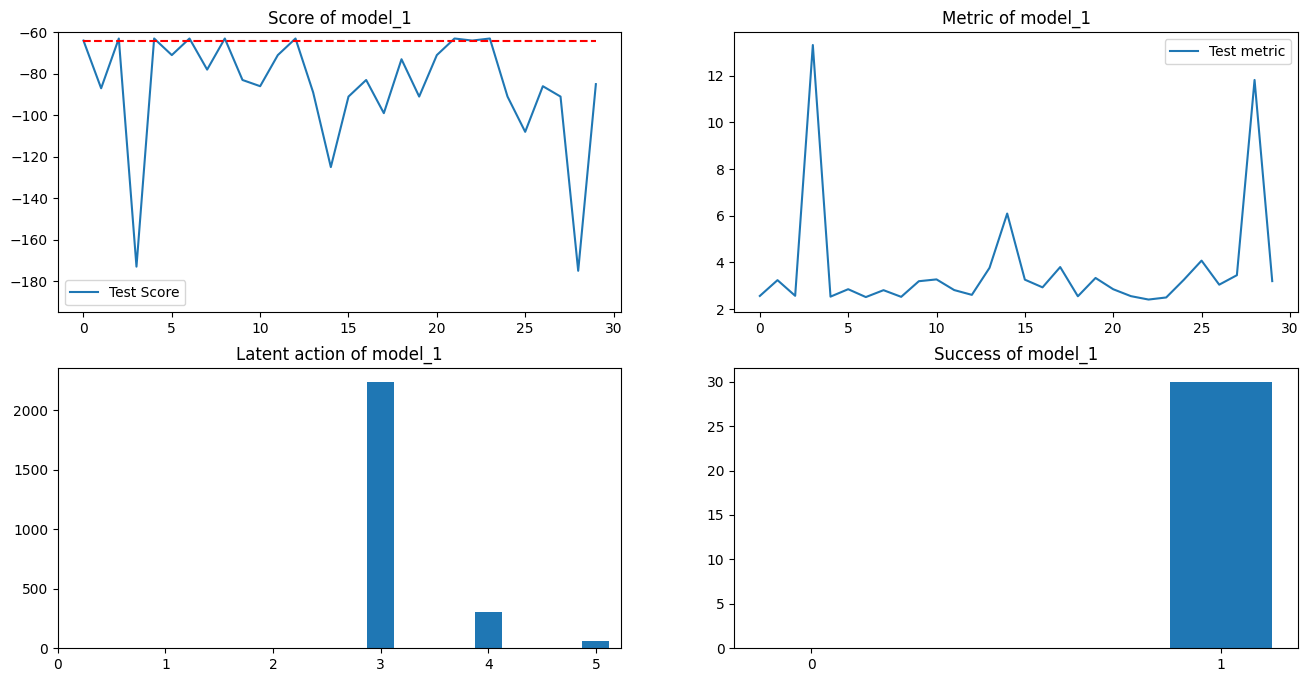

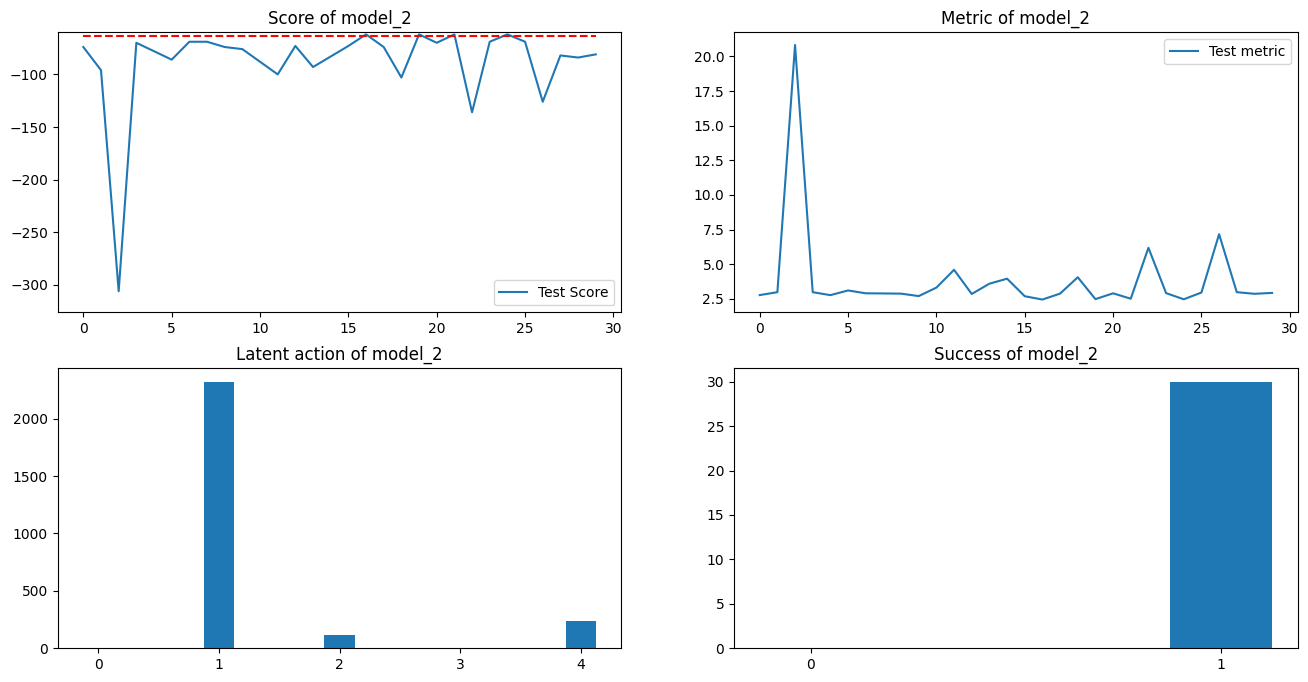

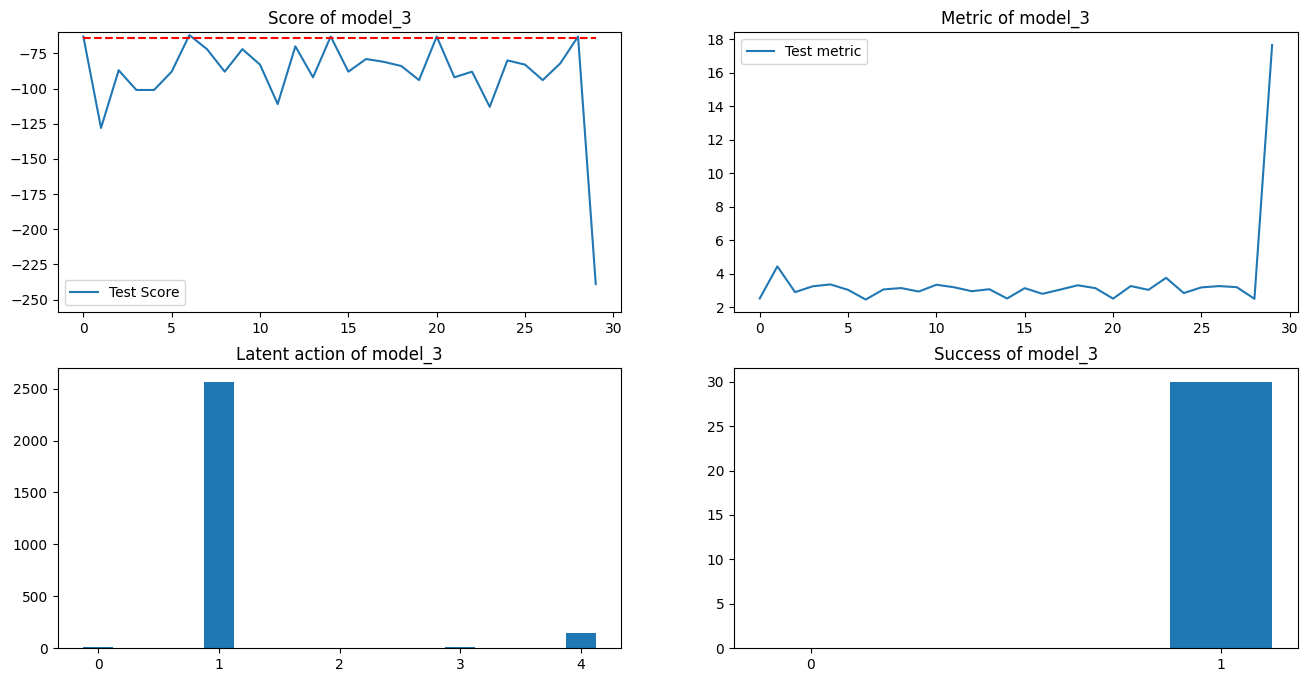

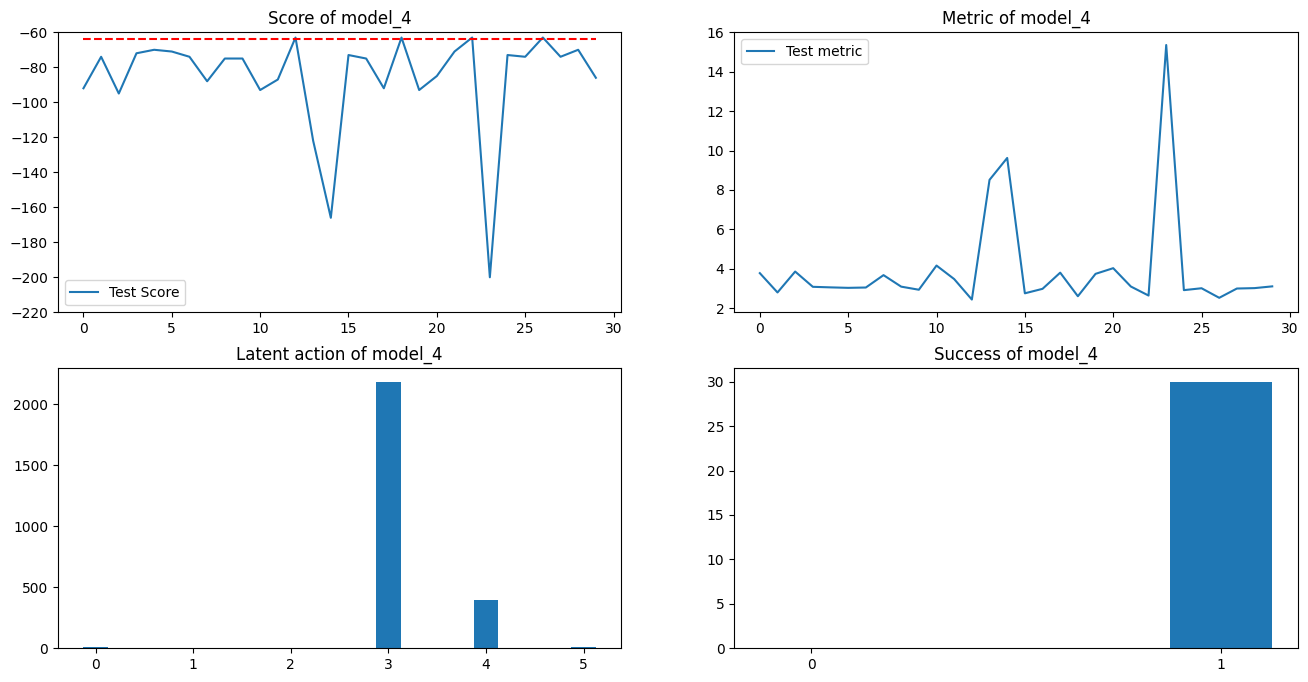

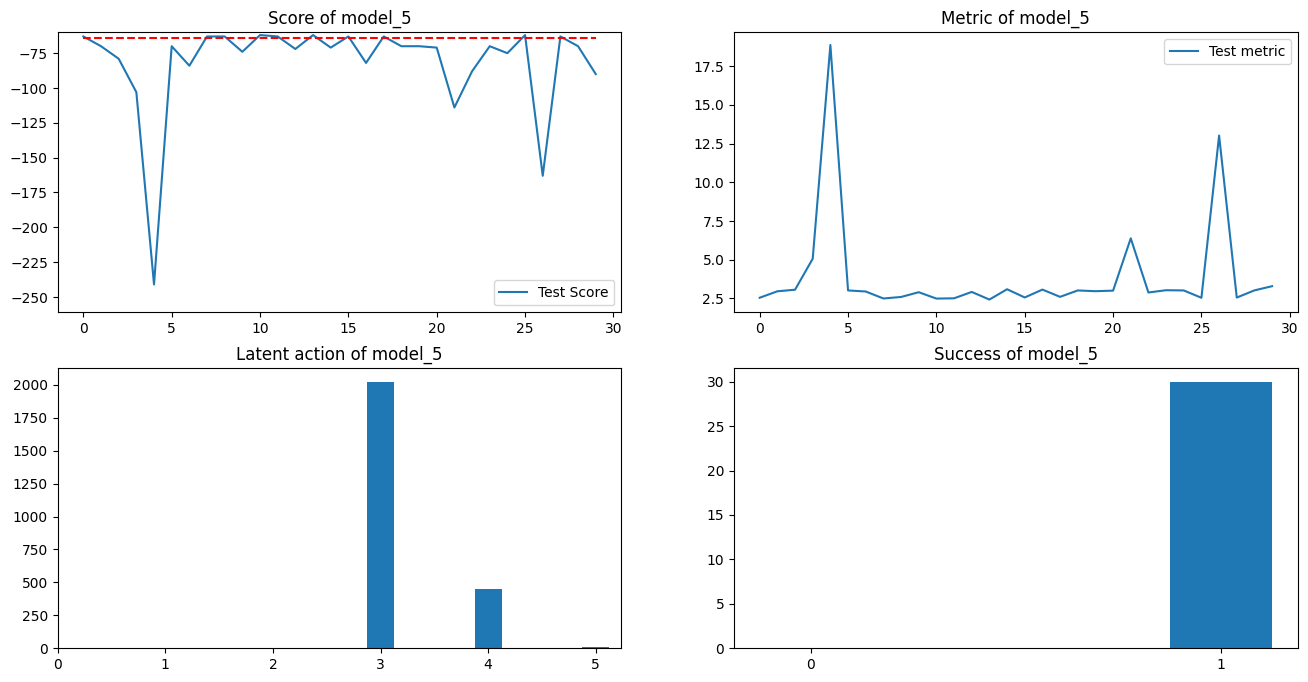

In [55]:
for i in range(6):
    paths_test = os.path.join(os.getcwd(), 'runs', 'action_remap', 'Acrobot-v1', 'test', f'model_{i}', 'test_results.json')

    with open(paths_test) as f:
        dict_test = json.load(f)

    test_score = dict_test['score']
    test_metric = dict_test['metric']
    test_z = dict_test['z']
    test_terminated = dict_test['terminated']
    test_n_latent_action = dict_test['n_latent_action']

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Score of model_{i}")
    plt.plot(test_score, label='Test Score')
    plt.hlines(-64, 0, 29, colors='red', linestyles='--')
    plt.ylim(np.min(test_score)-20,-60)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Metric of model_{i}")
    plt.plot(test_metric, label='Test metric')
    plt.legend()

    plt.subplot(2,2,3)
    values, counts = np.unique(test_z, return_counts=True)
    plt.bar(values, counts, width = 0.25, align='center')
    plt.xticks(np.arange(test_n_latent_action))
    plt.title(f"Latent action of model_{i}")

    plt.subplot(2,2,4)
    count_ter = [len(np.where(np.array(test_terminated)==i)[0]) for i in range(2)]
    plt.bar([0, 1], count_ter, width = 0.25, align='center')
    plt.xticks([0, 1])
    plt.title(f"Success of model_{i}")

    plt.savefig(os.path.join(os.path.dirname(paths_test), 'result1.png'))

### MountainCar-v0

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

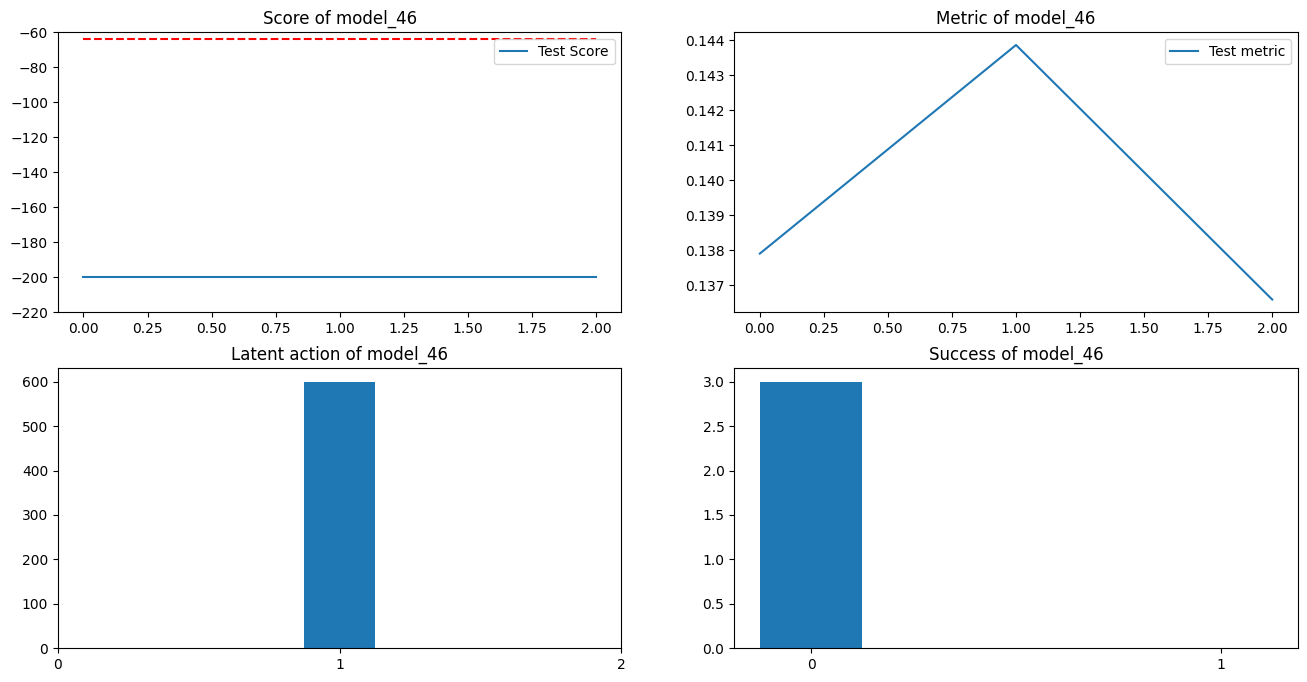

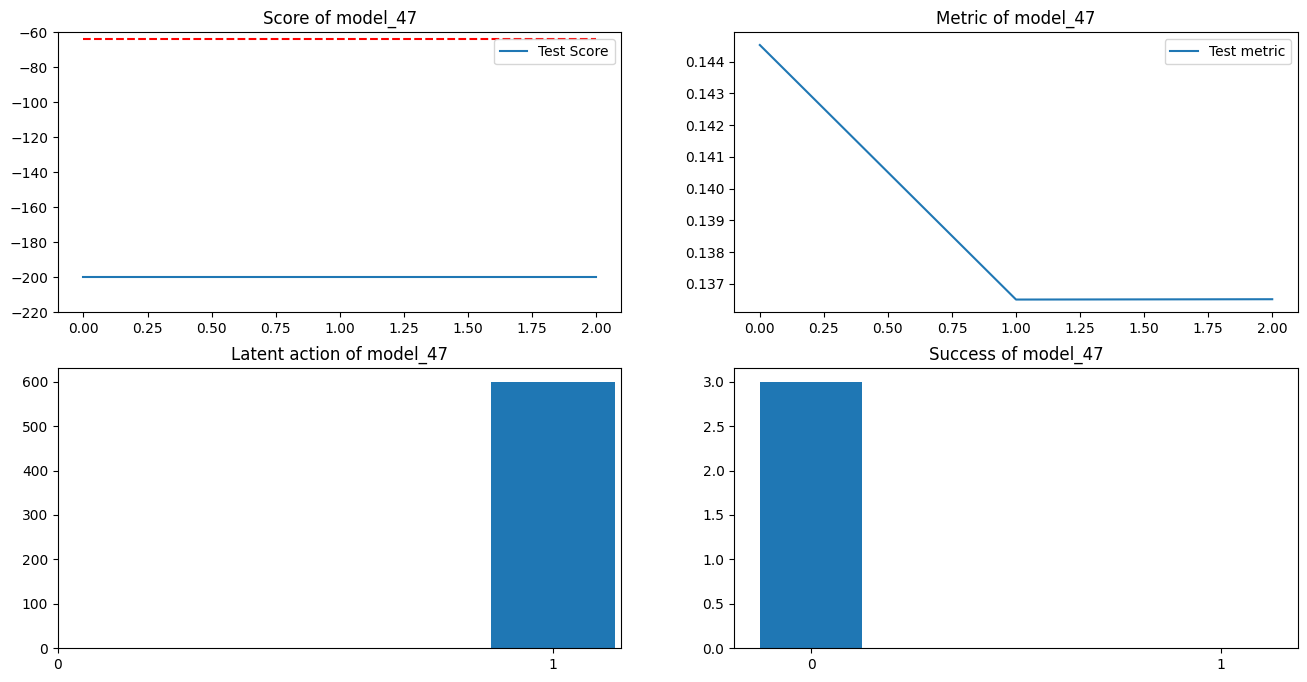

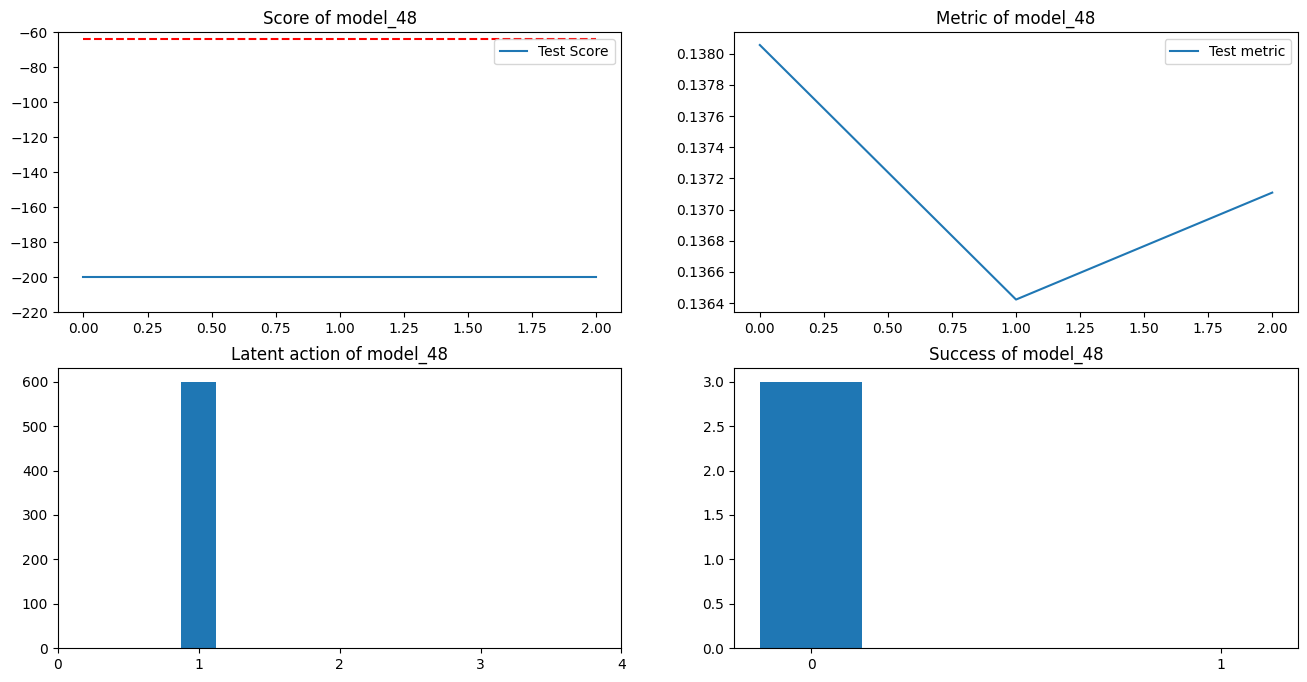

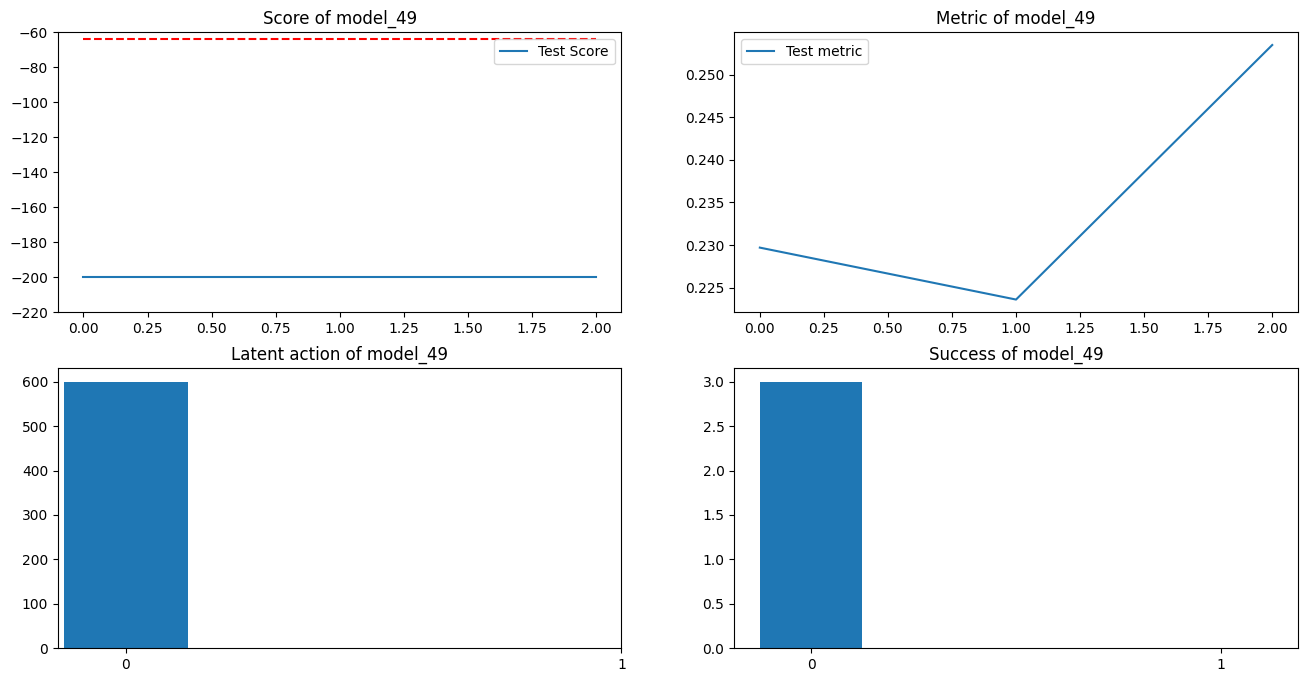

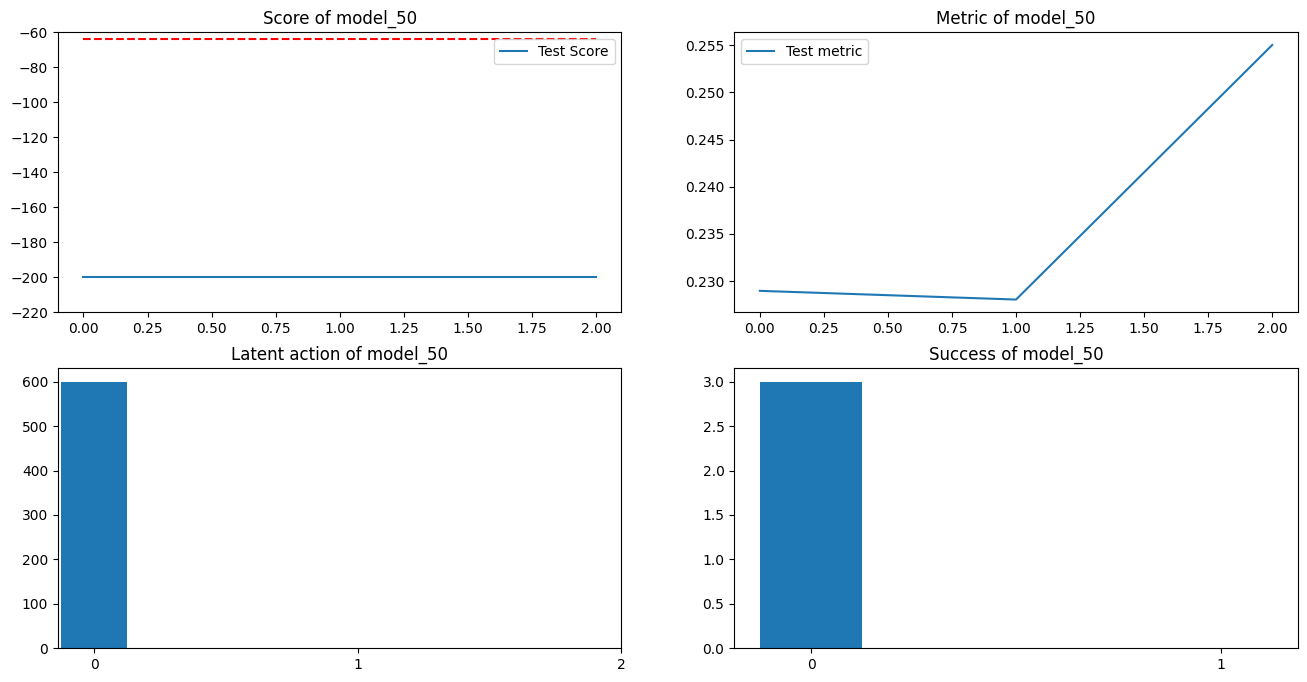

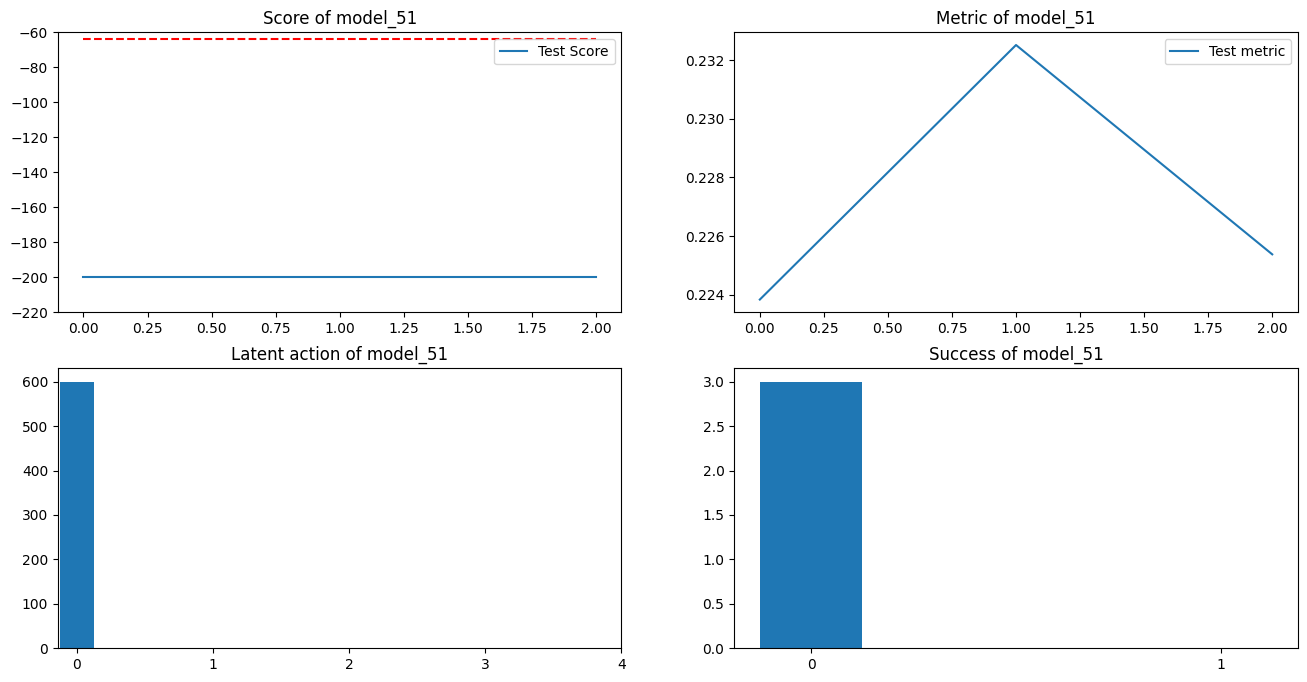

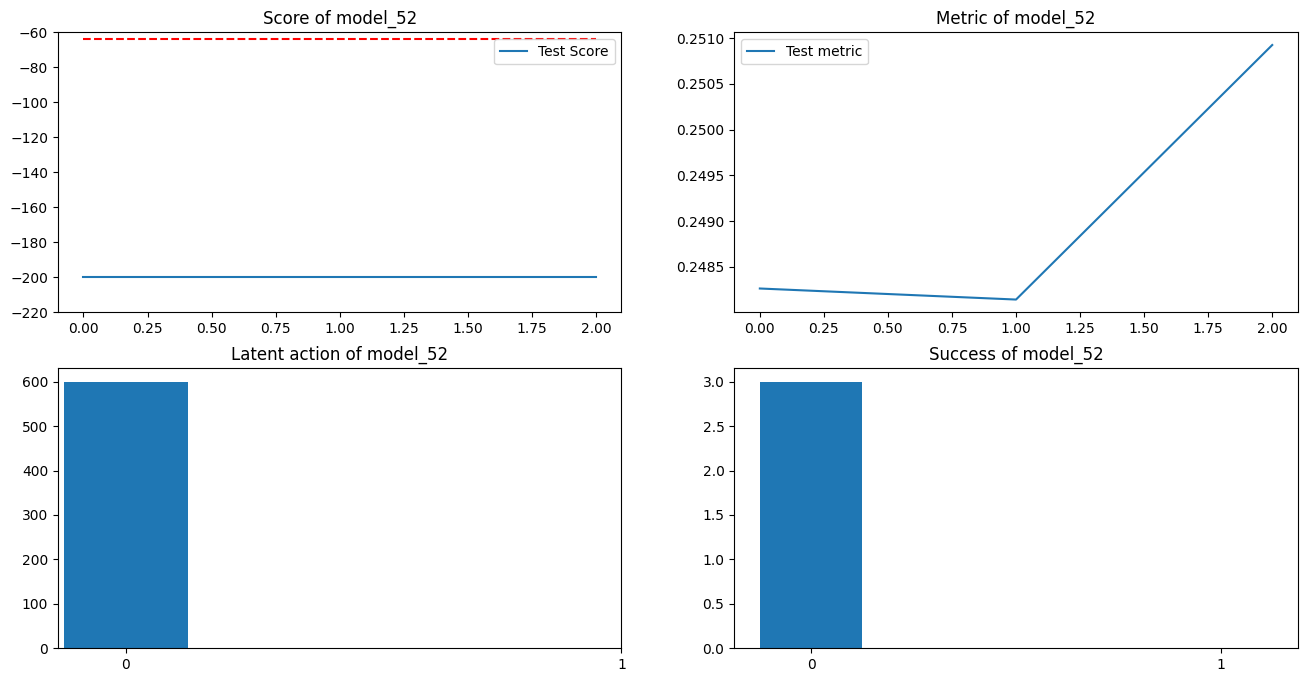

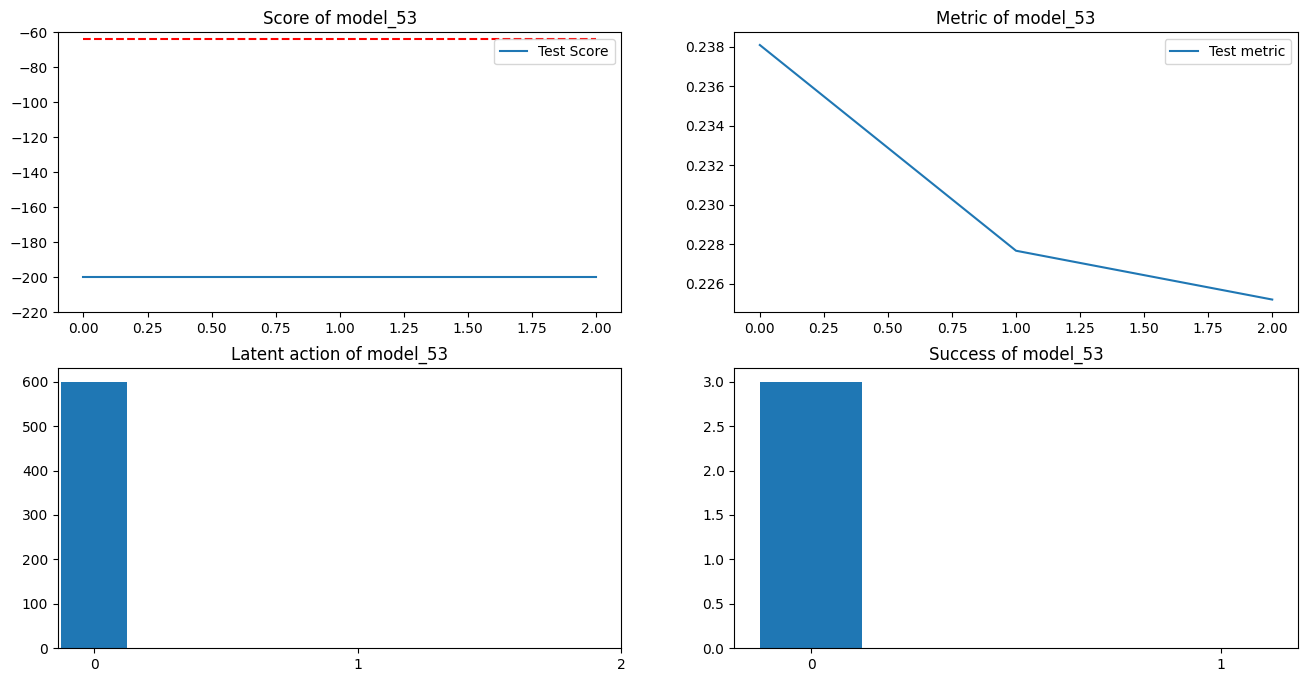

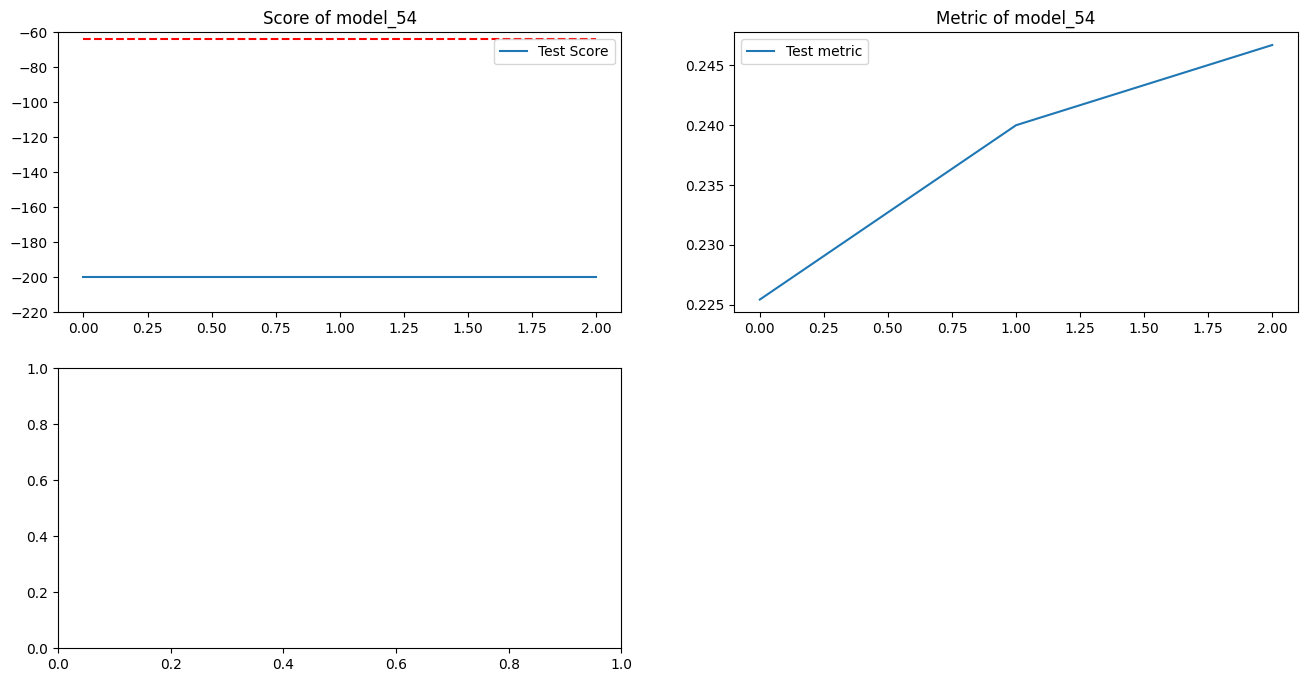

In [13]:
for i in range(46, 55, 1):
    paths_test = os.path.join(os.getcwd(), 'runs', 'action_remap', 'MountainCar-v0', 'test', f'model_{i}', 'test_results.json')

    with open(paths_test) as f:
        dict_test = json.load(f)

    test_score = dict_test['score']
    test_metric = dict_test['metric']
    test_z = dict_test['z']
    test_terminated = dict_test['terminated']
    test_n_latent_action = dict_test['n_latent_action']
    test_action = dict_test['action']

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Score of model_{i}")
    plt.plot(test_score, label='Test Score')
    plt.hlines(-64, 0, 2, colors='red', linestyles='--')
    plt.ylim(np.min(test_score)-20,-60)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Metric of model_{i}")
    plt.plot(test_metric, label='Test metric')
    plt.legend()

    plt.subplot(2,2,3)
    values, counts = np.unique(test_action, return_counts=True)
    plt.bar(values, counts, width = 0.25, align='center')
    plt.xticks(np.arange(test_n_latent_action))
    plt.title(f"Latent action of model_{i}")

    plt.subplot(2,2,4)
    count_ter = [len(np.where(np.array(test_terminated)==i)[0]) for i in range(2)]
    plt.bar([0, 1], count_ter, width = 0.25, align='center')
    plt.xticks([0, 1])
    plt.title(f"Success of model_{i}")

    plt.savefig(os.path.join(os.path.dirname(paths_test), 'result1.png'))

## Train result : Policy

### MountainCar-v0

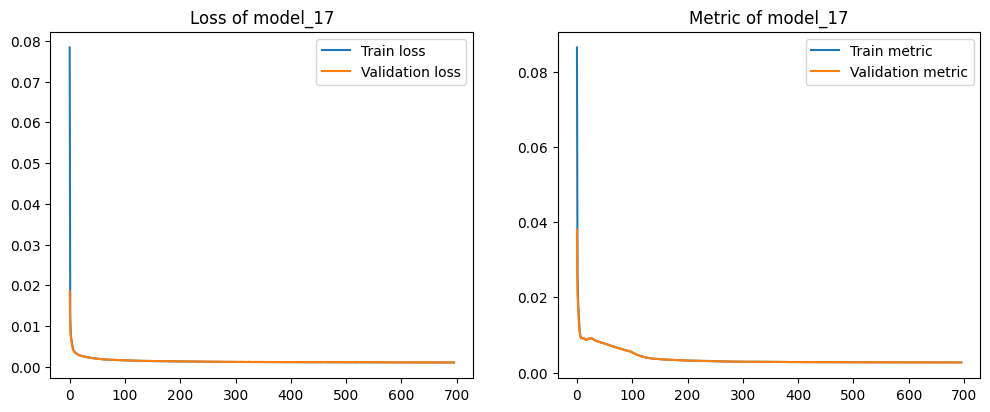

In [293]:
columns = ['rel_metric_pos', 'rel_metric_v']
for i in range(1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss_step = np.array(dict_train['loss_total'])
    train_metric_step = np.array(dict_train['metric'])
    train_epochs = np.array(dict_train['epochs'])
    val_loss_step = np.array(dict_val['loss_total'])
    val_metric_step = np.array(dict_val['metric'])
    val_epochs = np.array(dict_val['epochs'])

    train_loss = [np.mean(train_loss_step[np.where(train_epochs == e)]) for e in range(np.max(dict_train['epochs']))]
    val_loss = [np.mean(val_loss_step[np.where(val_epochs == e)]) for e in range(np.max(dict_val['epochs']))]
    train_metric = [np.mean(train_metric_step[np.where(train_epochs == e)]) for e in range(np.max(dict_train['epochs']))]
    val_metric = [np.mean(val_metric_step[np.where(val_epochs == e)]) for e in range(np.max(dict_val['epochs']))]

    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    # plt.ylim(0, 0.05)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(f"Metric of model_{i}")
    plt.plot(train_metric, label='Train metric')
    plt.plot(val_metric, label='Validation metric')
    plt.legend()
    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result.png'))

## Train result : Action Remap

### CartPole-v1

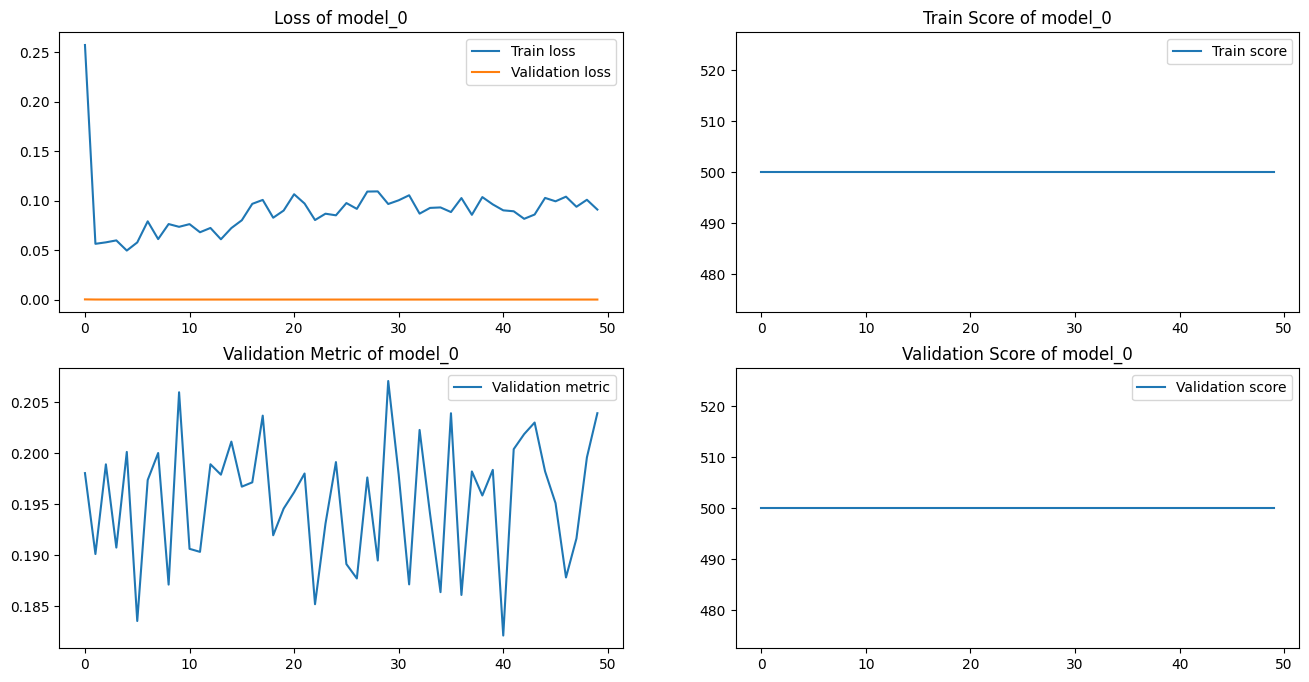

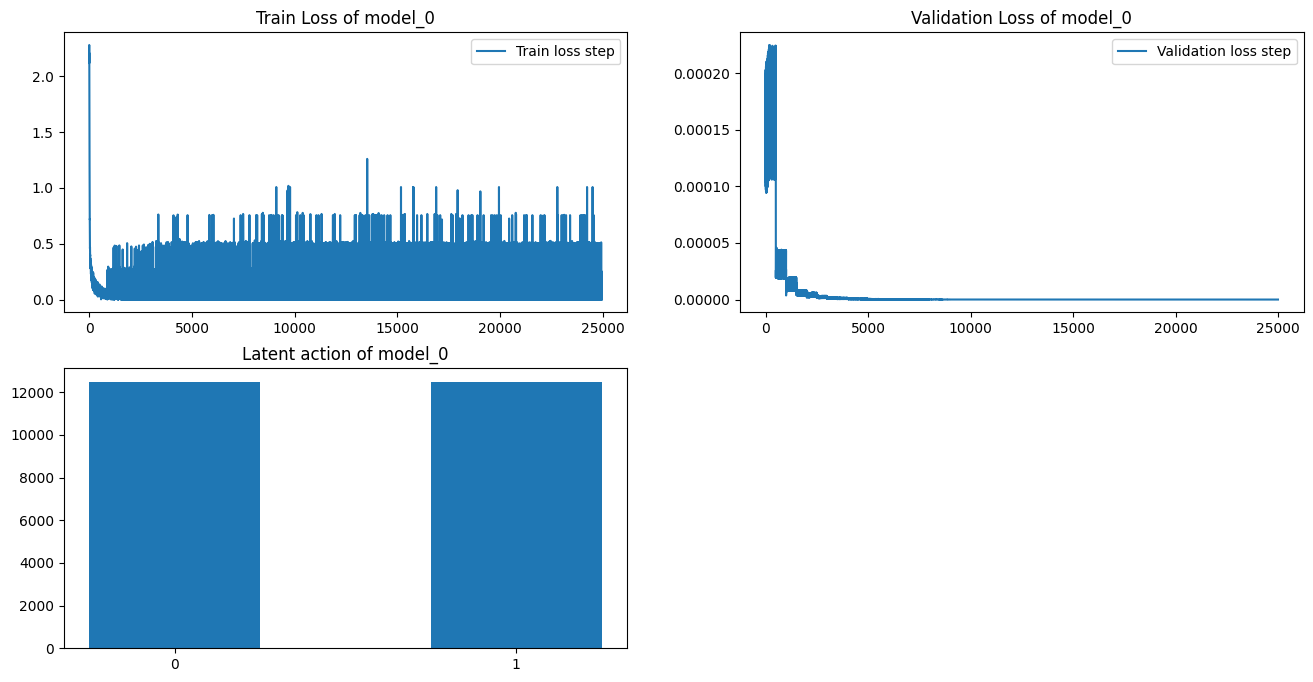

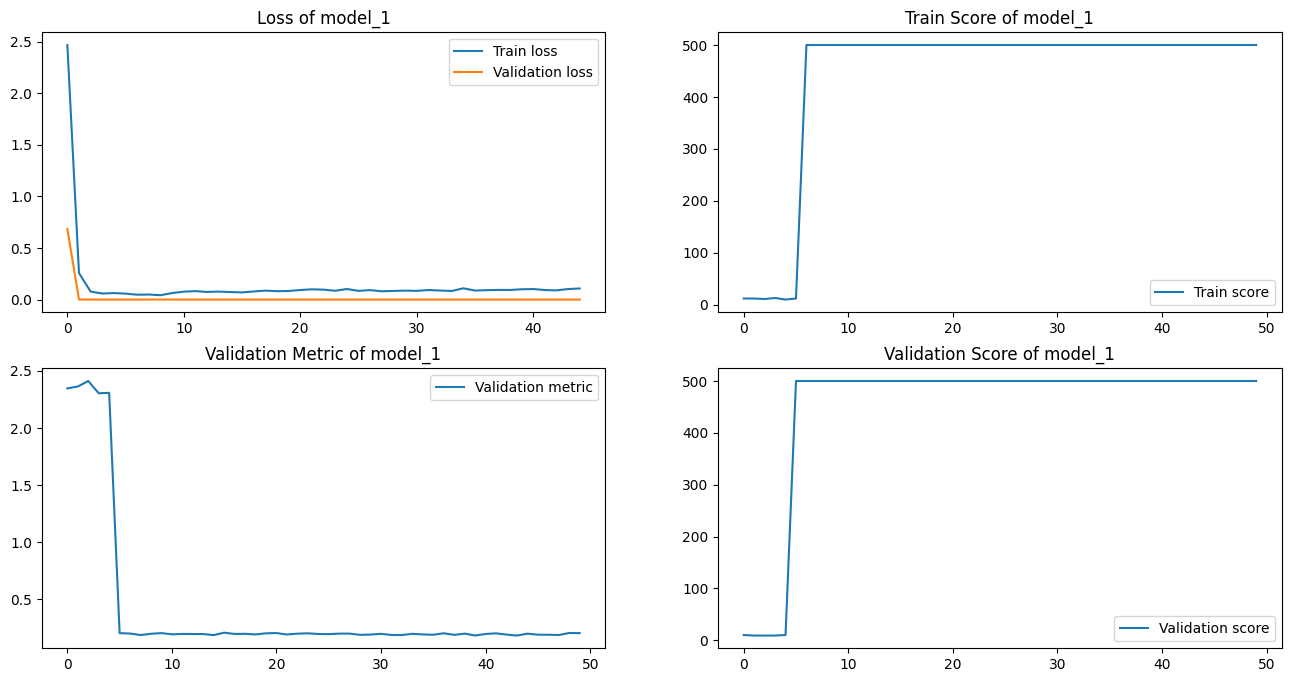

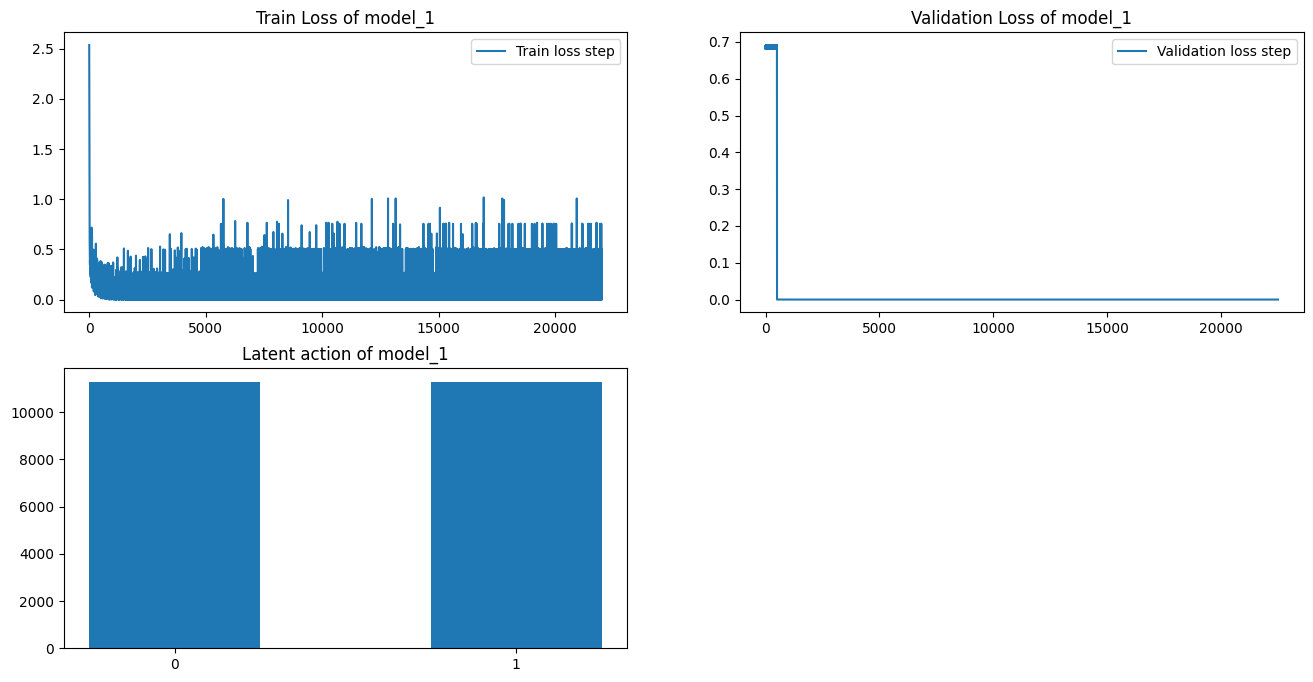

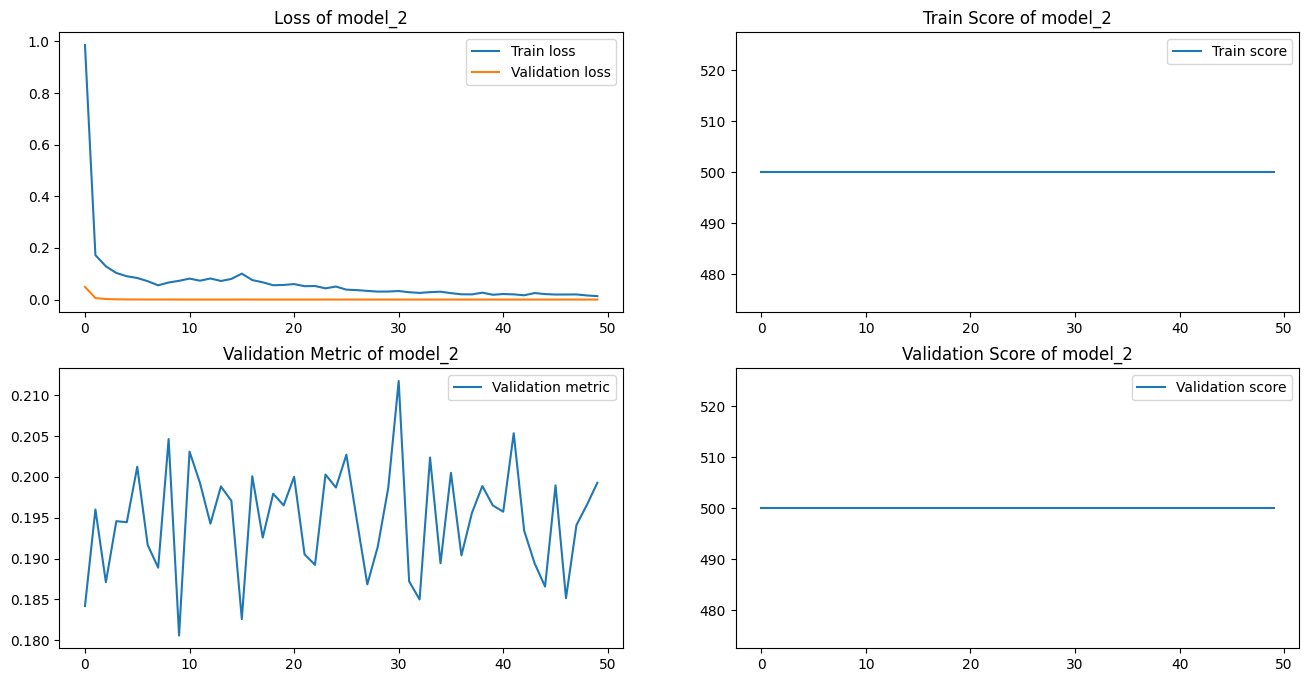

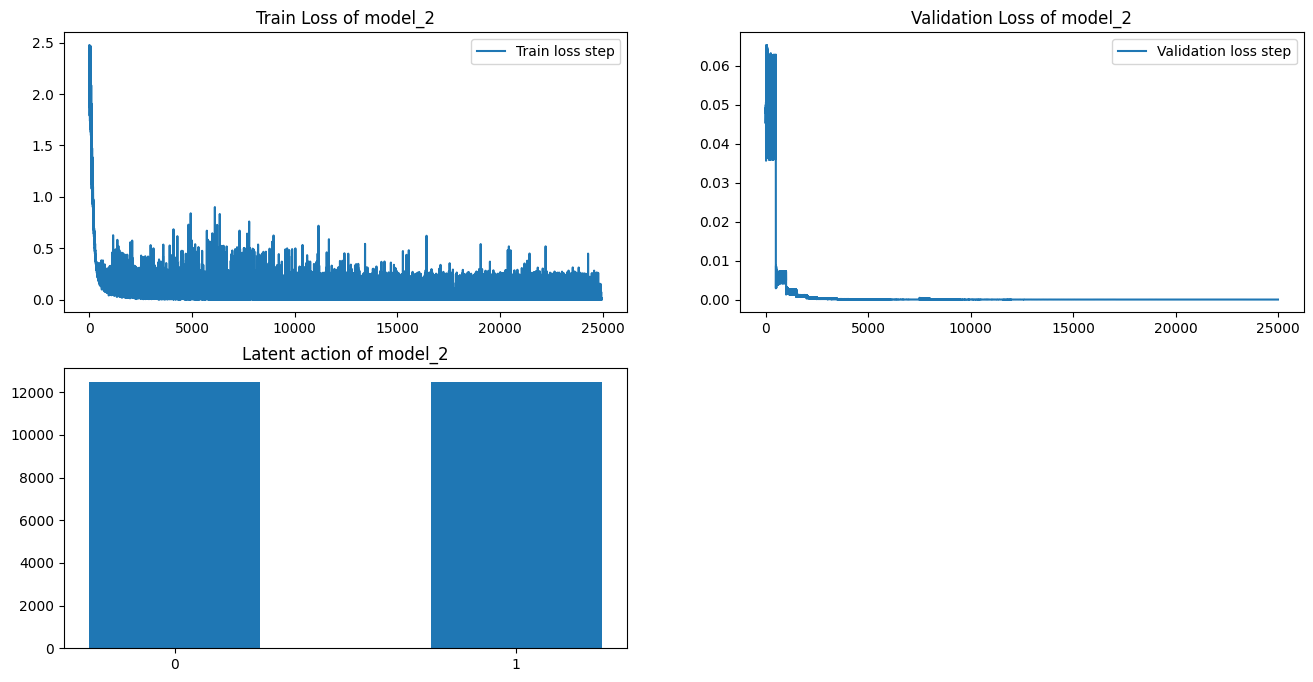

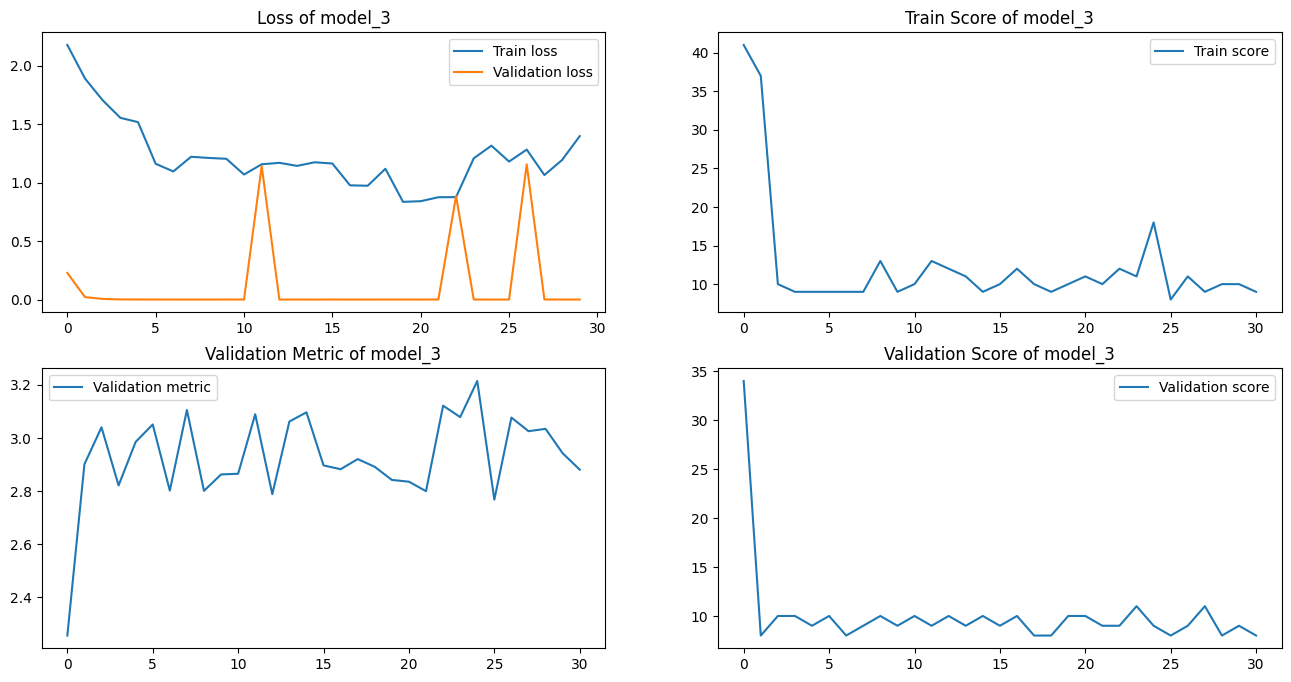

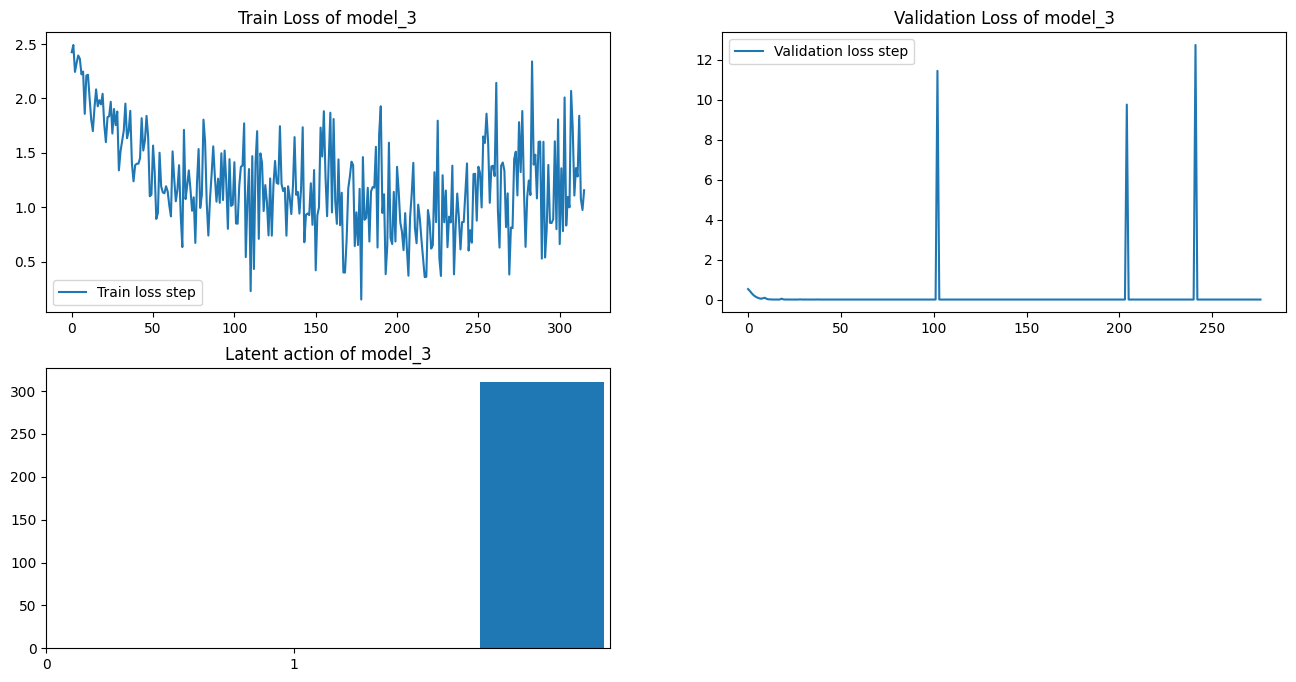

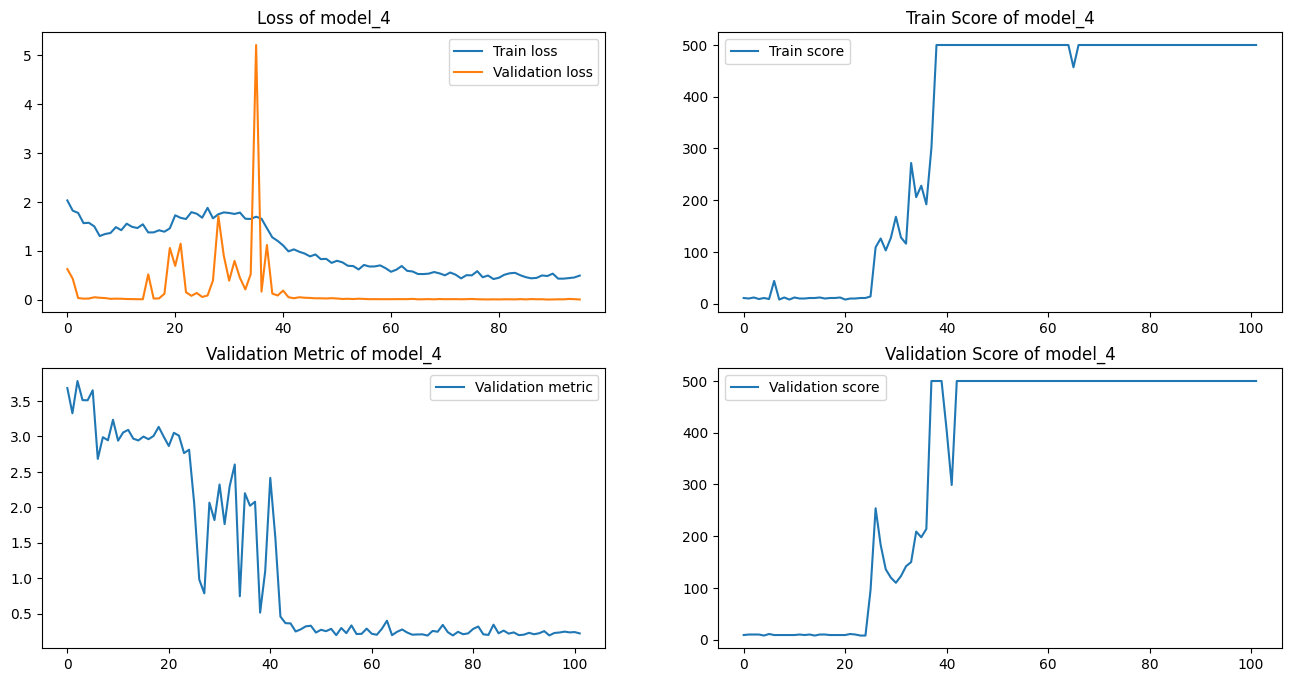

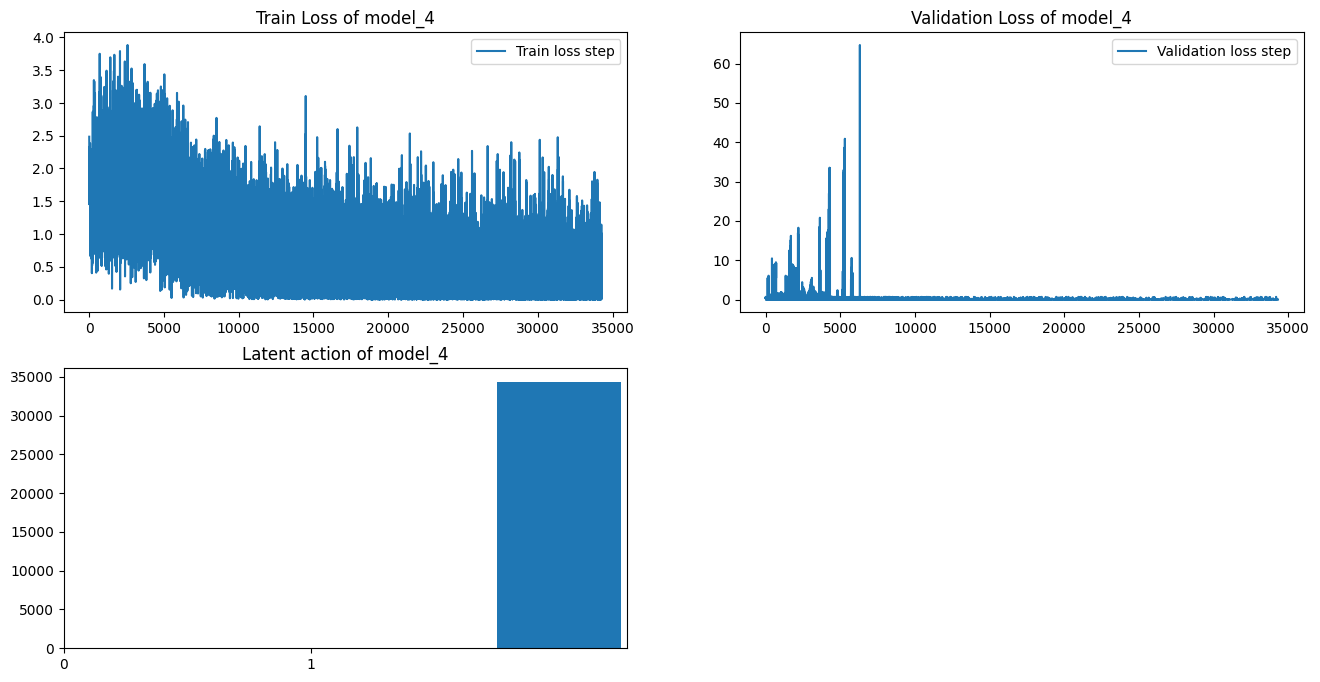

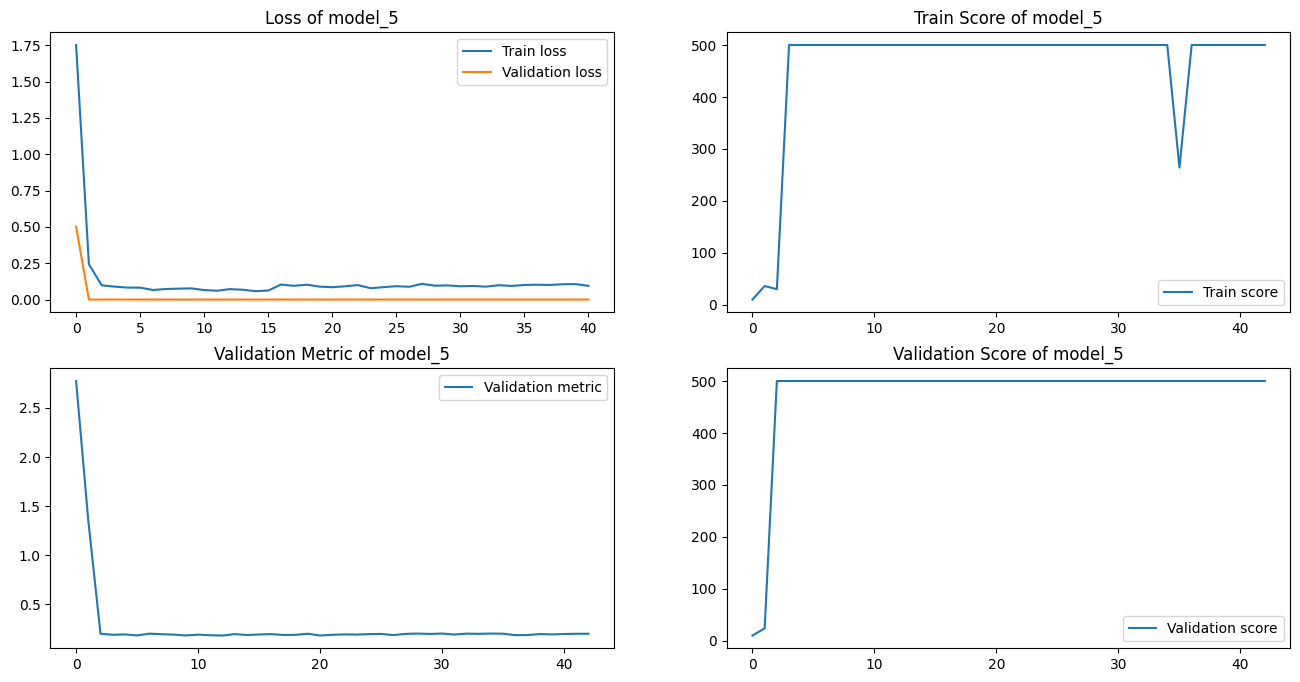

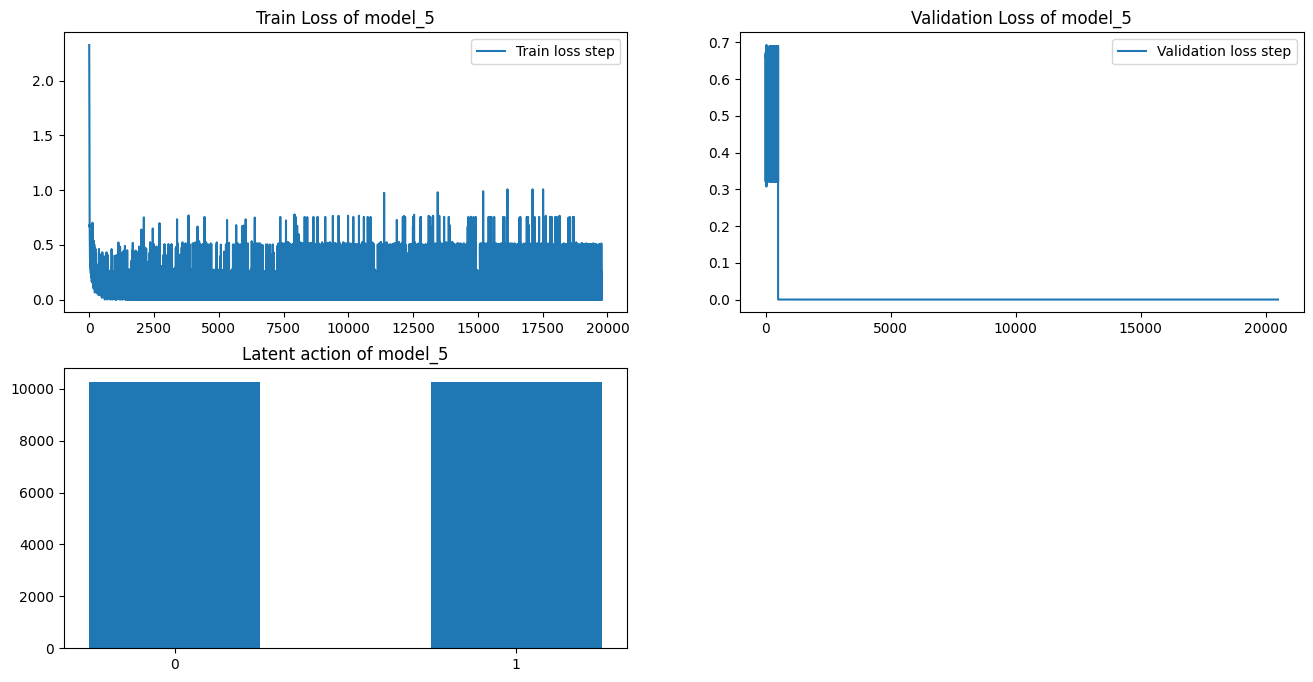

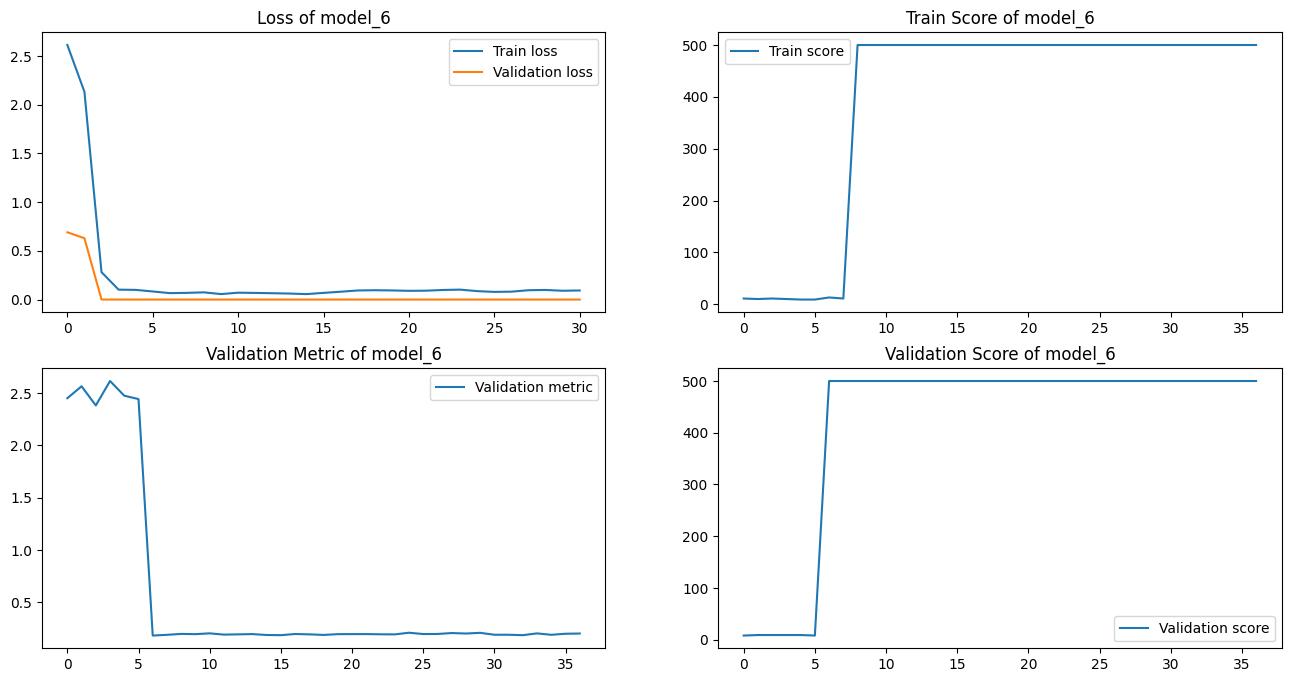

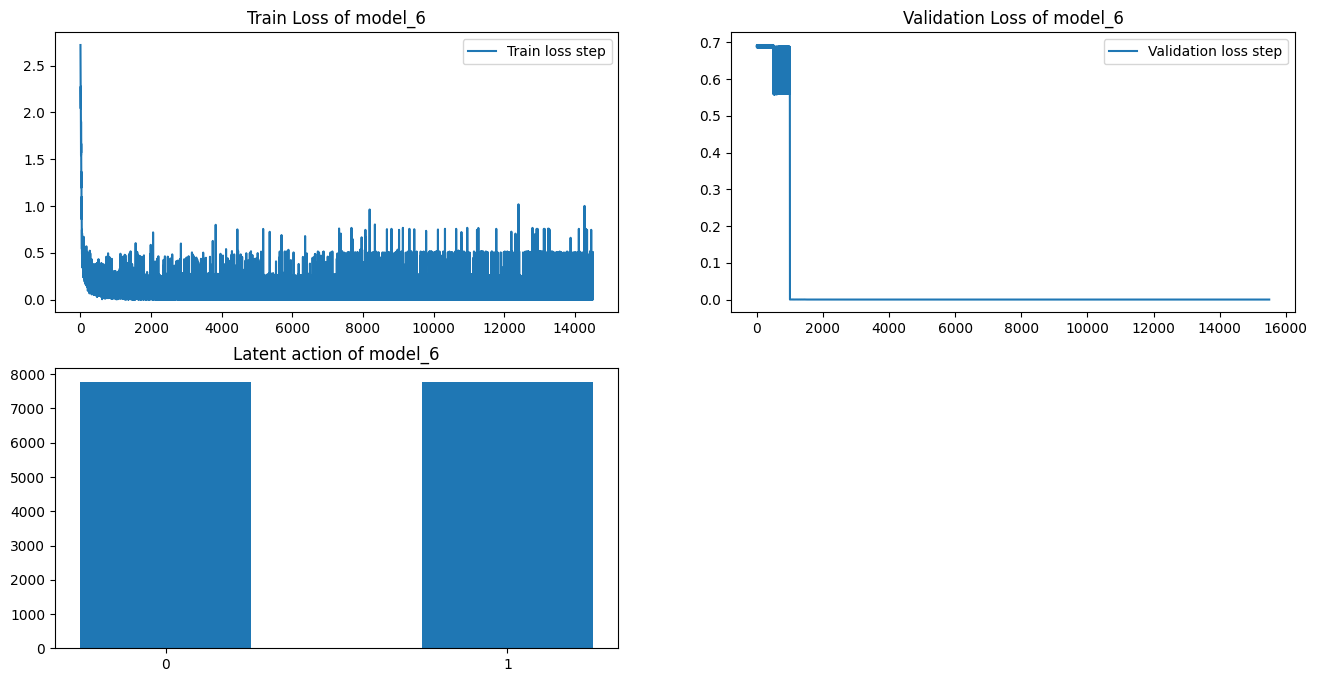

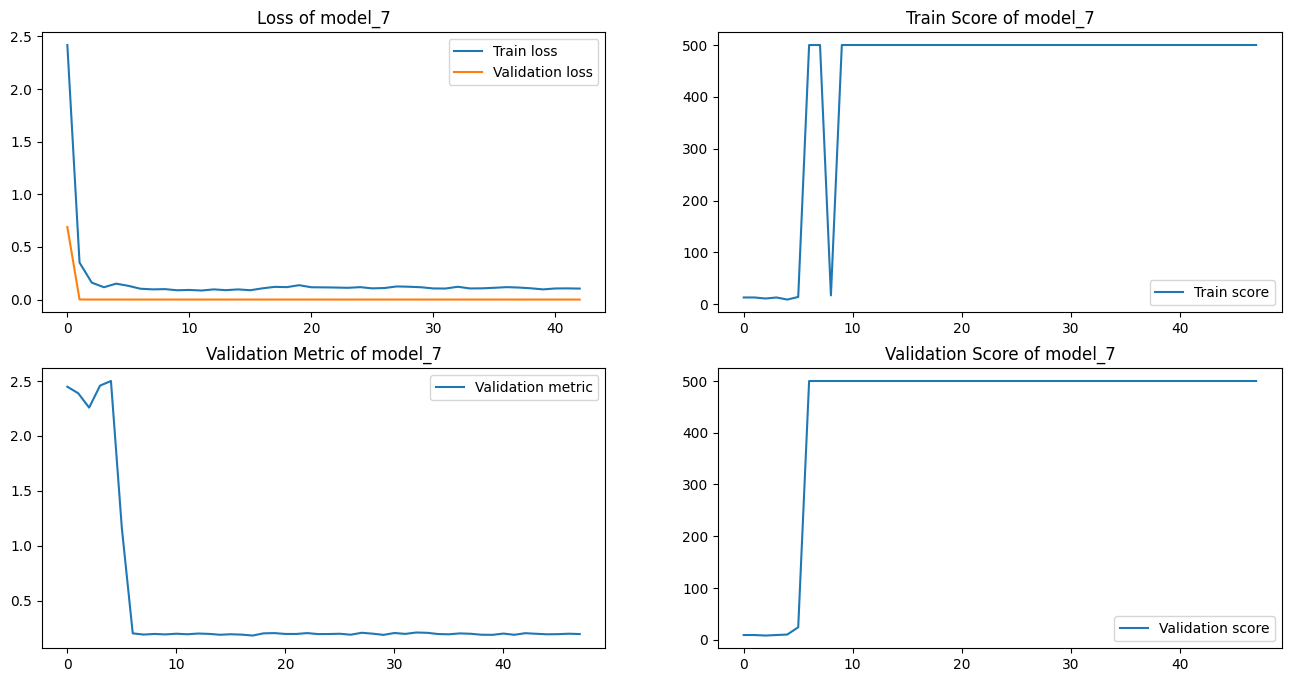

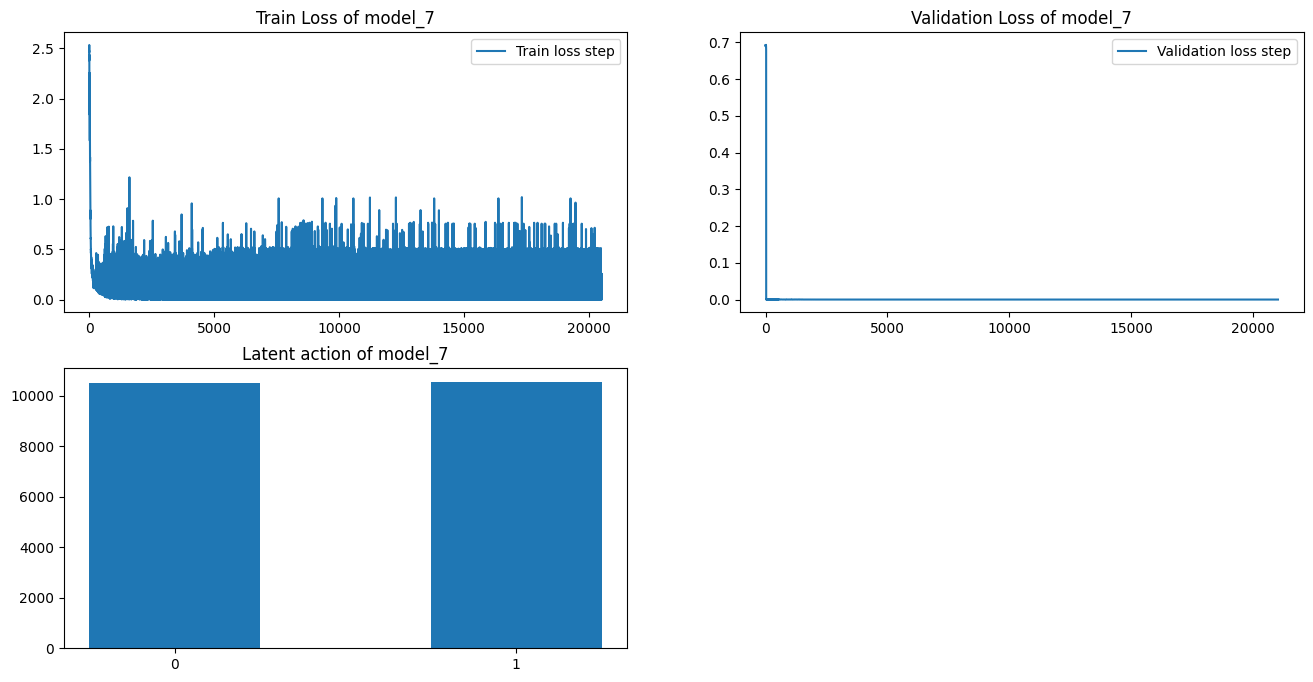

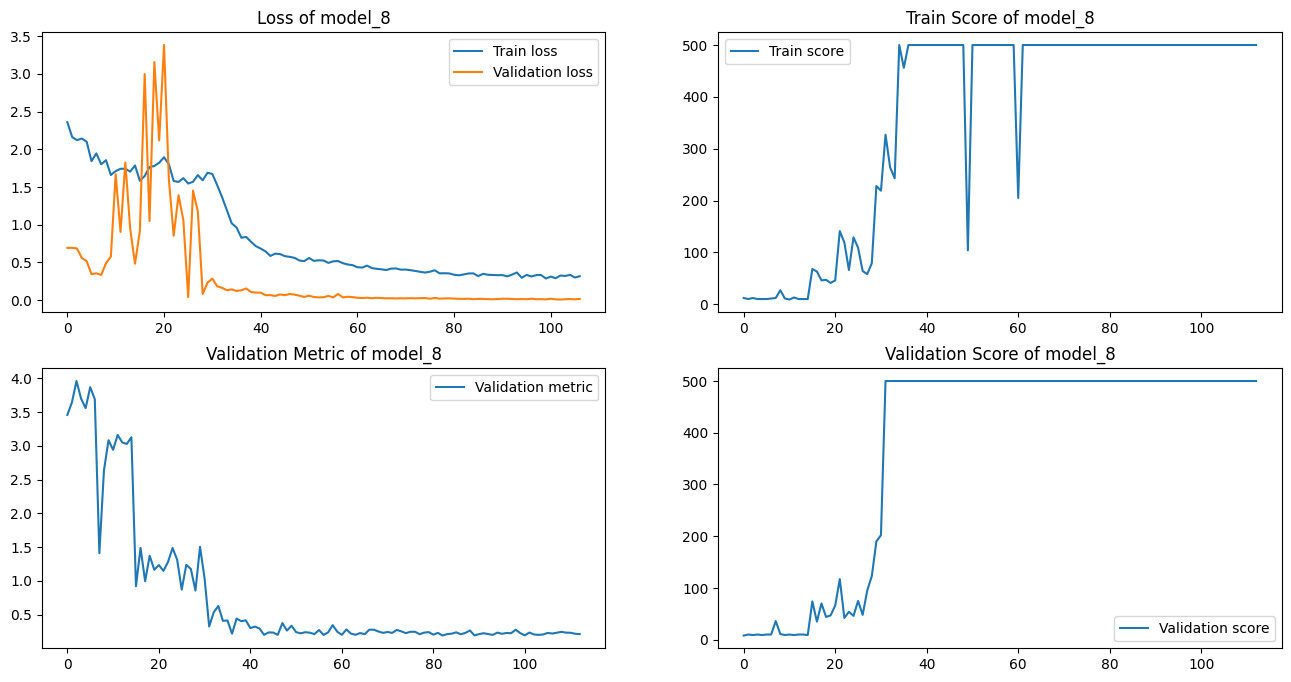

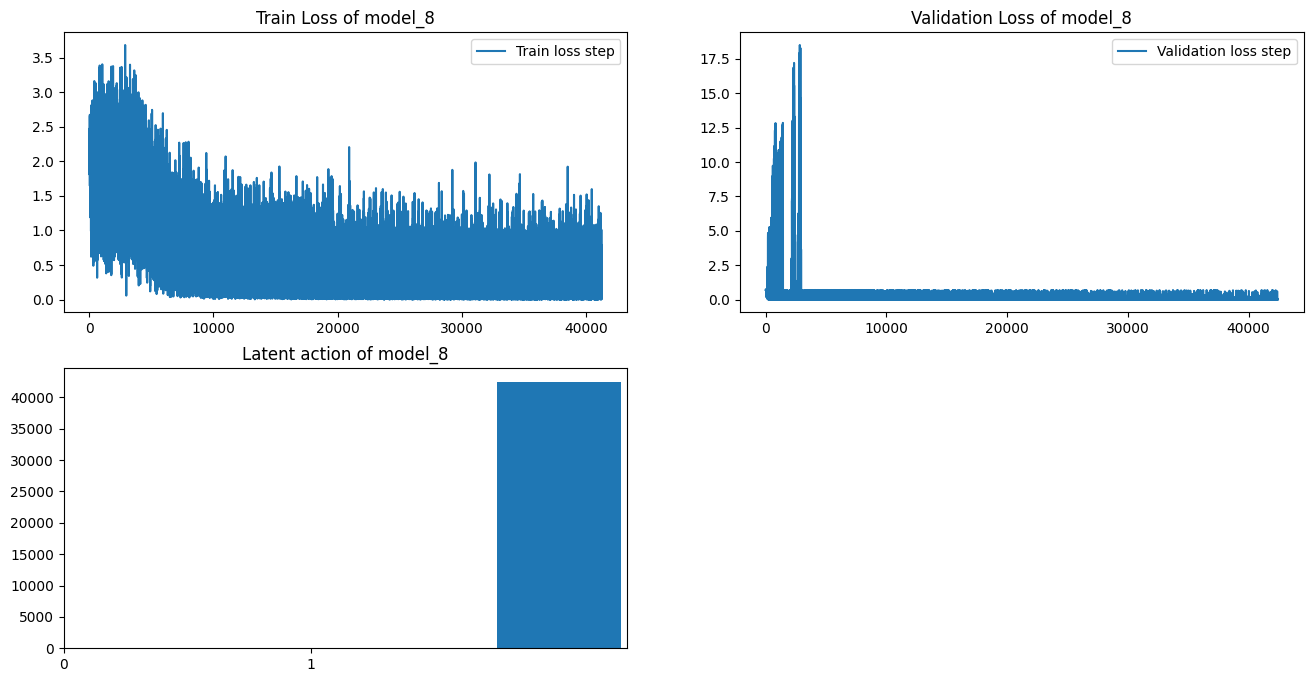

In [26]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_angle', 'rel_metric_w']
for i in range(9):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss = np.array(dict_train['loss'])
    train_loss_step = np.array(dict_train['loss_step'])
    train_score = np.array(dict_train['score'])
    train_episode = np.array(dict_train['episode'])

    val_loss = np.array(dict_val['loss'])
    val_loss_step = np.array(dict_val['loss_step'])
    val_z = np.array(dict_val['z'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_episode = np.array(dict_val['episode'])

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Train Score of model_{i}")
    plt.plot(train_score, label='Train score')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f"Validation Metric of model_{i}")
    plt.plot(val_metric, label='Validation metric')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title(f"Validation Score of model_{i}")
    plt.plot(val_score, label='Validation score')
    plt.legend()

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result1.png'))

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Train Loss of model_{i}")
    plt.plot(train_loss_step, label='Train loss step')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Validation Loss of model_{i}")
    plt.plot(val_loss_step, label='Validation loss step')
    plt.legend()

    plt.subplot(2,2,3)
    values, counts = np.unique(val_z, return_counts=True)
    plt.bar(values, counts, width = 0.5, align='center')
    plt.xticks([0,1])
    plt.title(f"Latent action of model_{i}")


    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result2.png'))

In [ ]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_angle', 'rel_metric_w']
for i in range(2,5,1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss = np.array(dict_train['loss'])
    train_score = np.array(dict_train['score'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_loss = np.array(dict_val['loss'])

In [ ]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_angle', 'rel_metric_w']
for i in range(2,5,1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss = np.array(dict_train['loss'])
    train_score = np.array(dict_train['score'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_loss = np.array(dict_val['loss'])

### MountainCar-v0

/tmp/ipykernel_652724/3168628876.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,8))


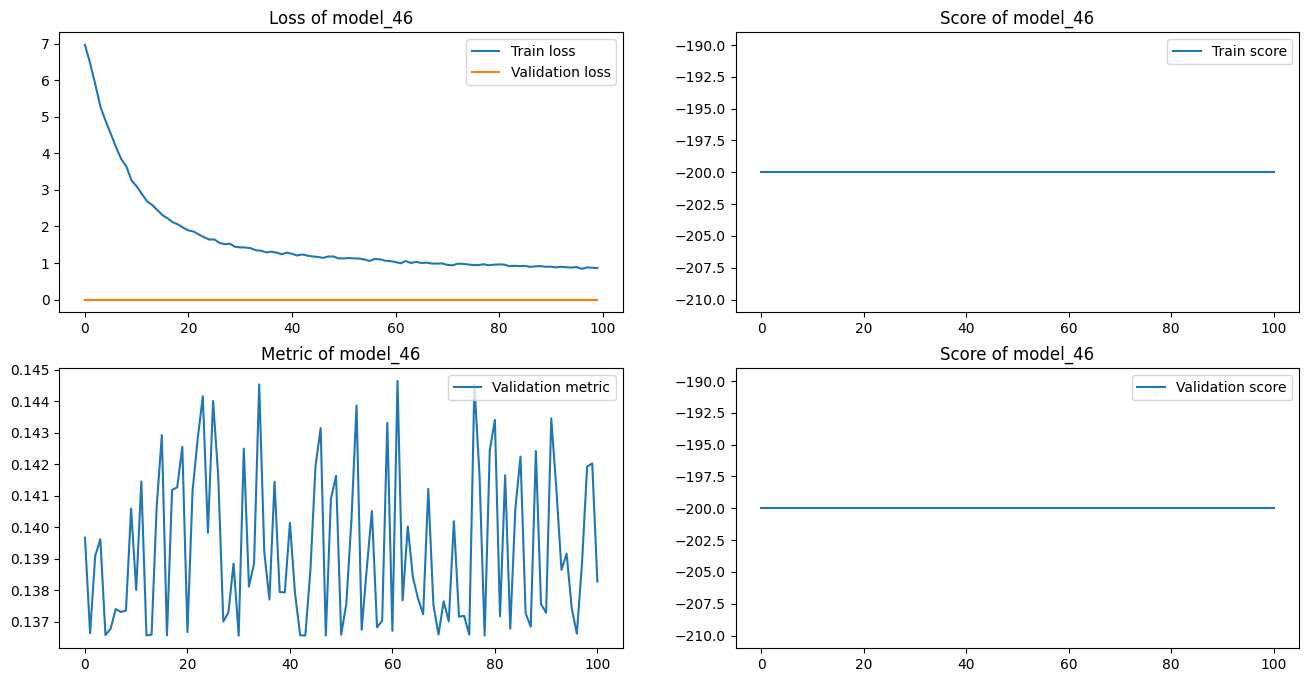

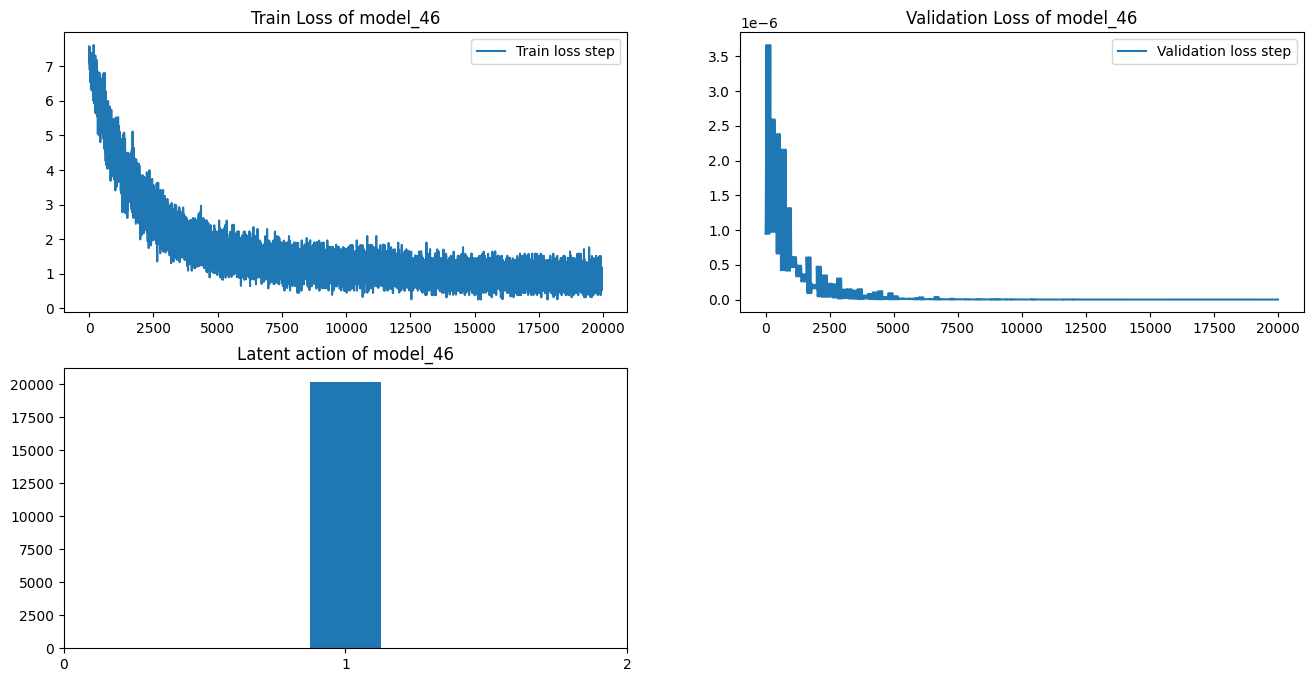

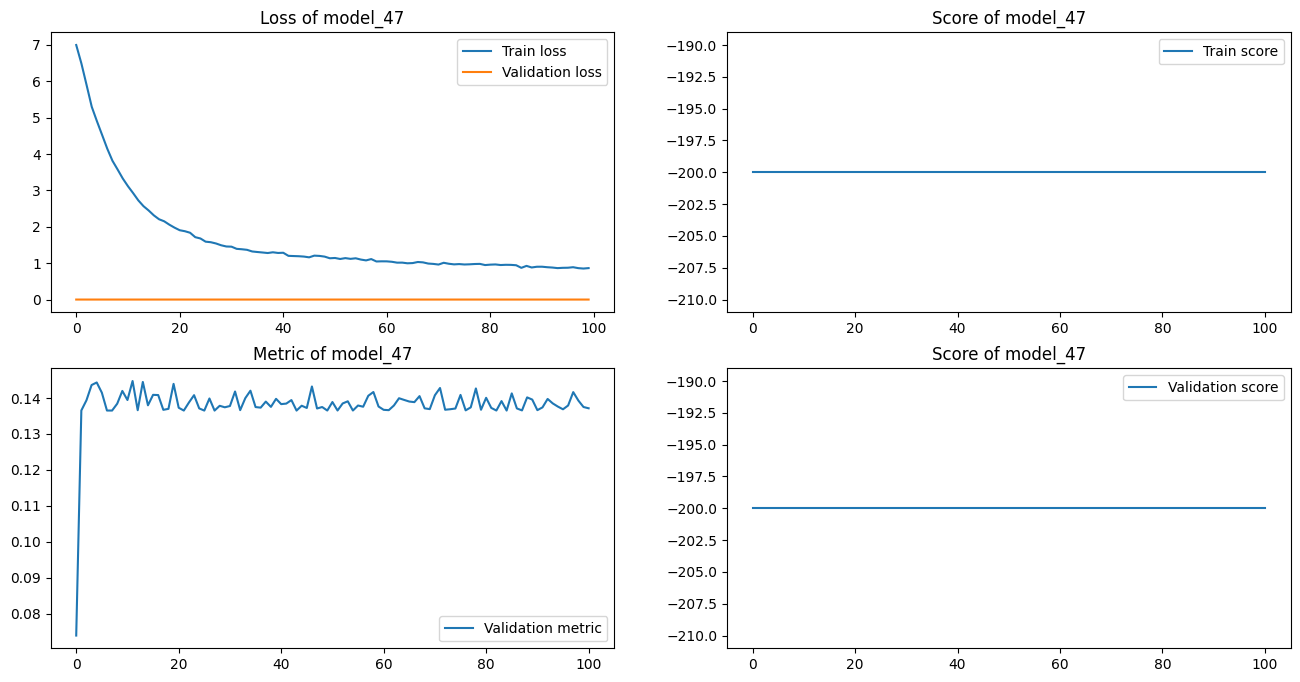

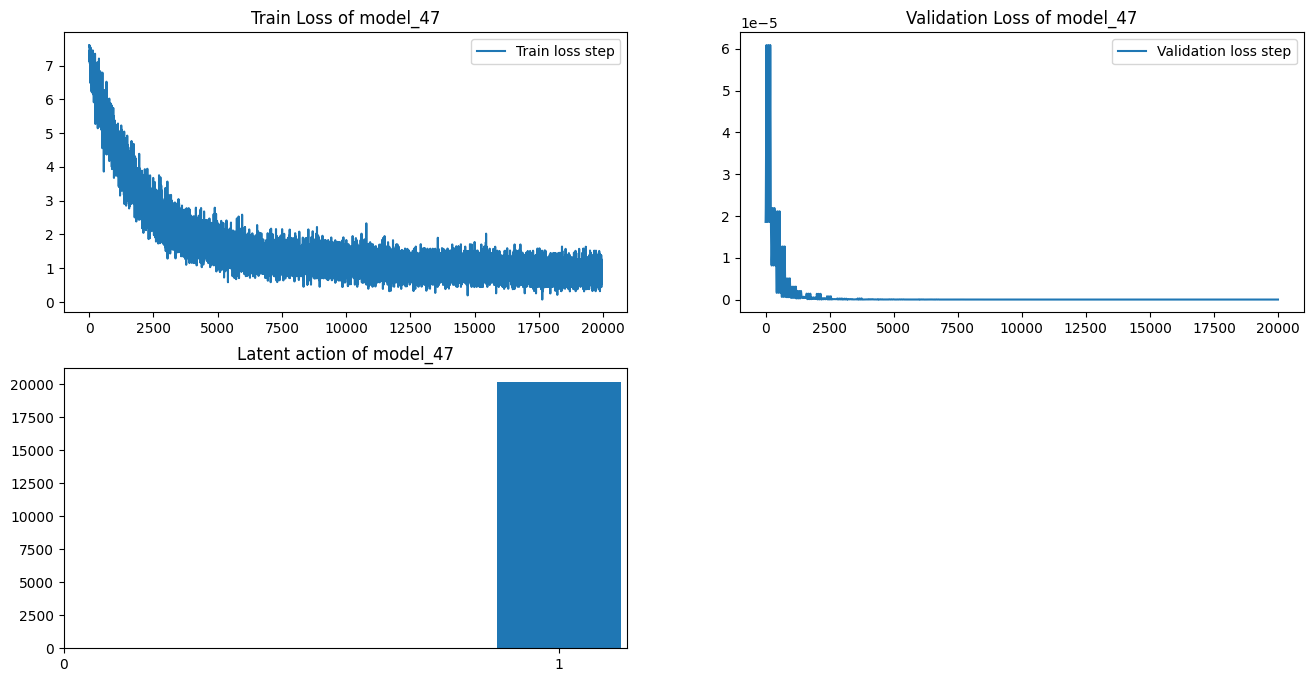

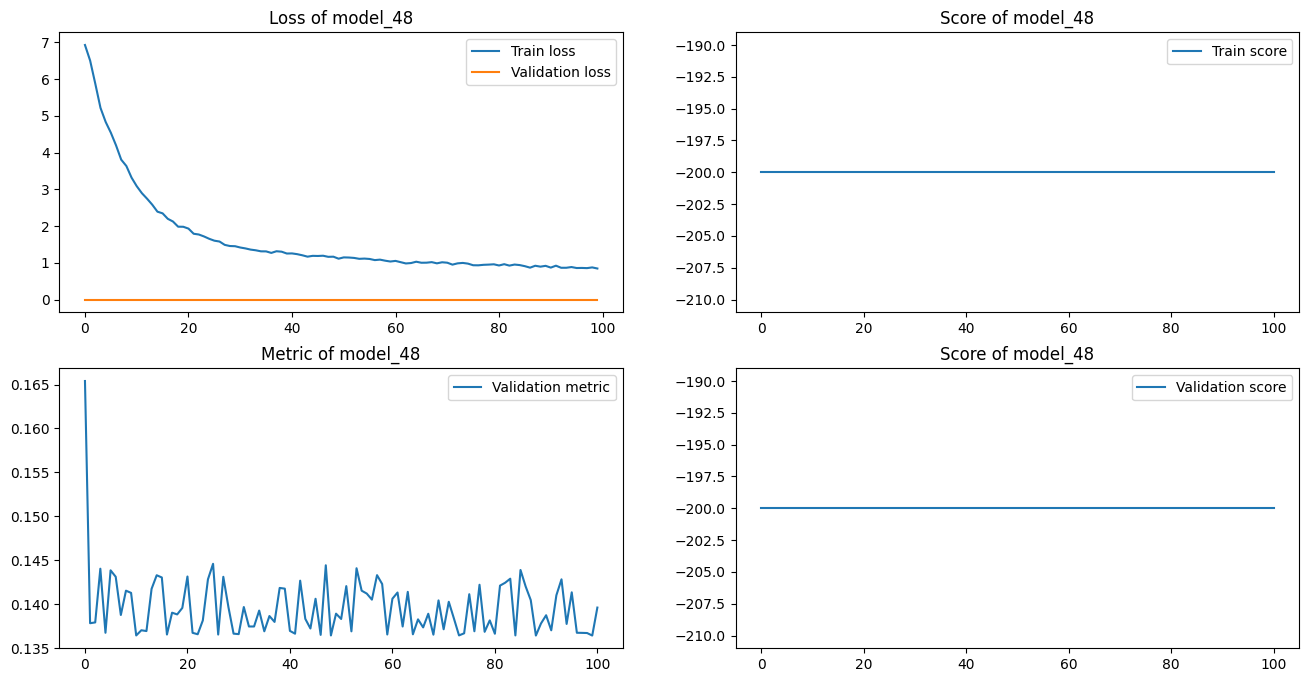

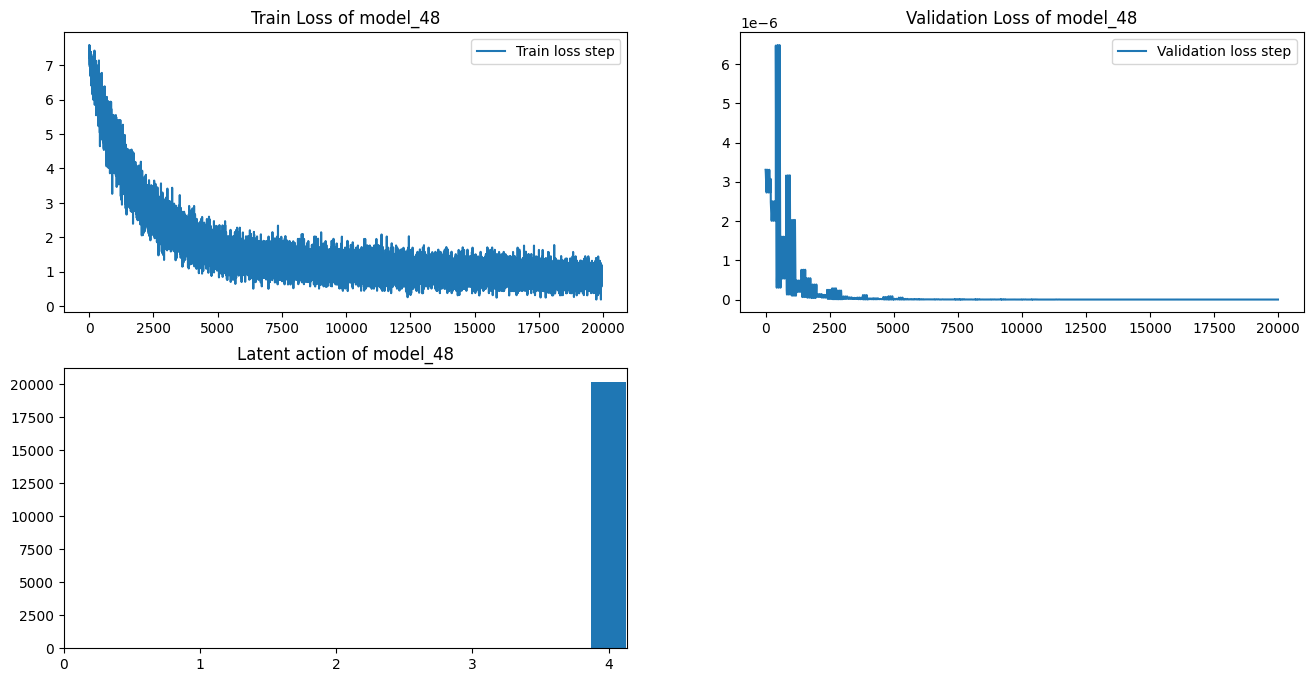

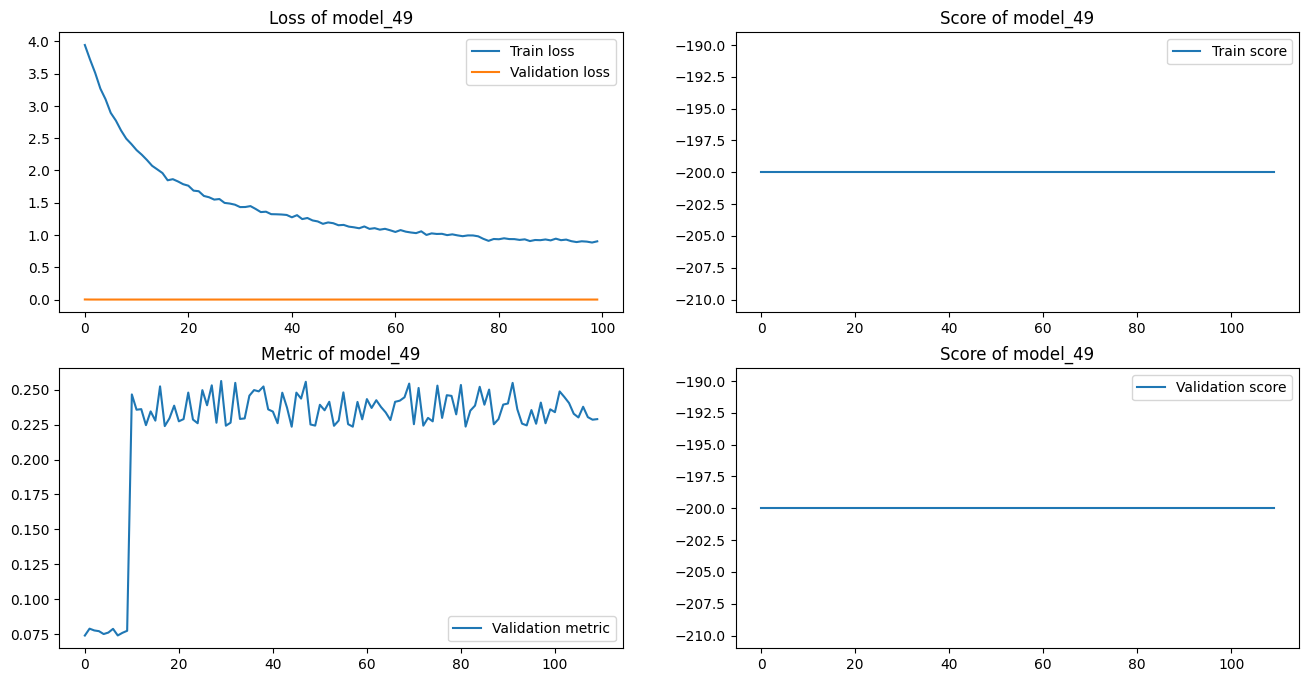

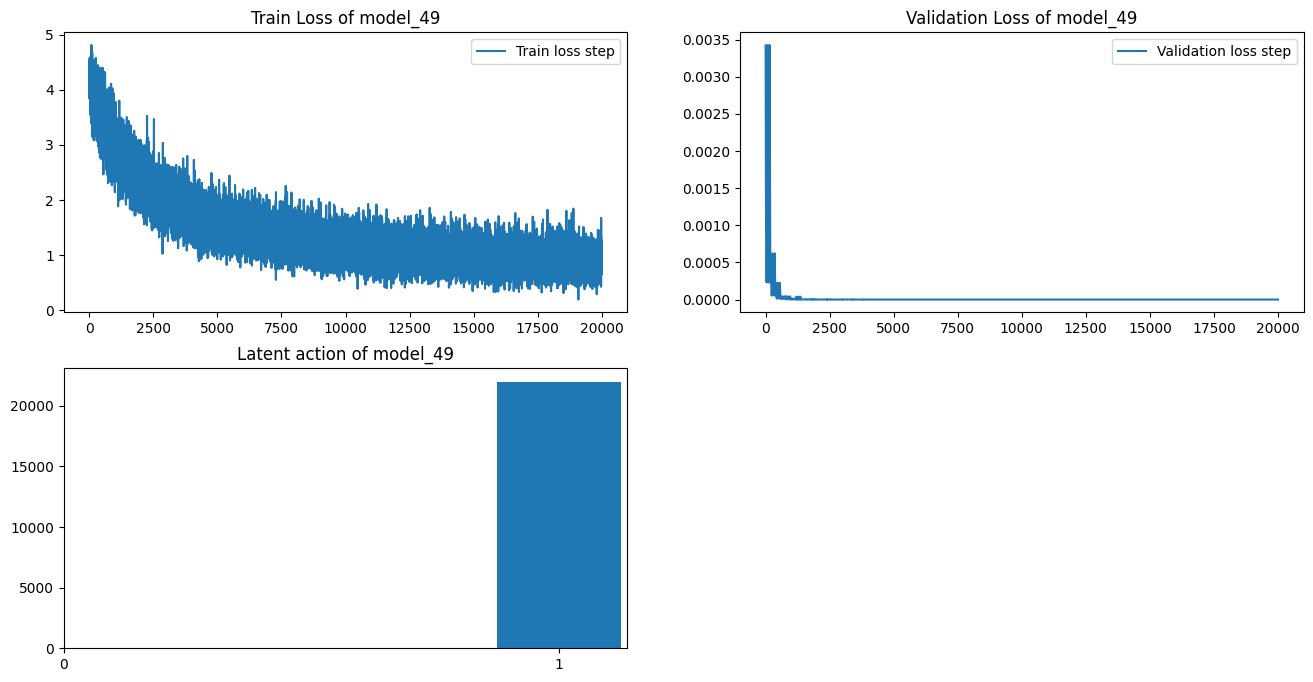

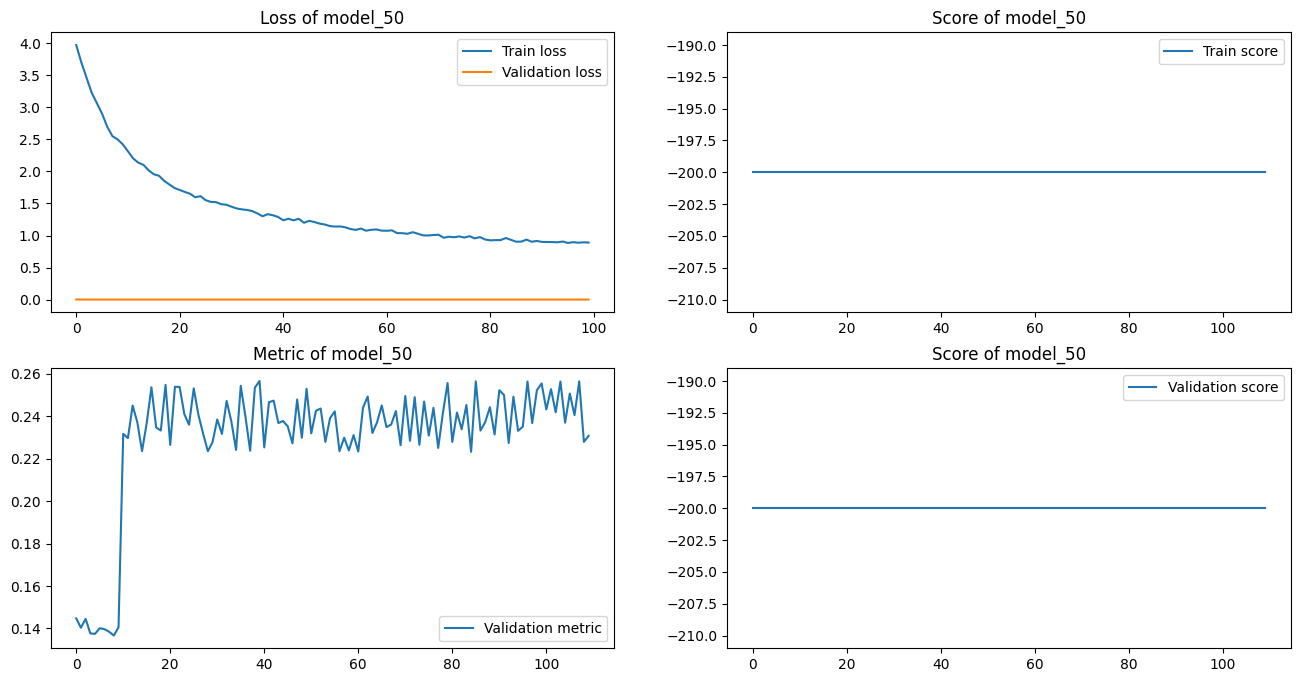

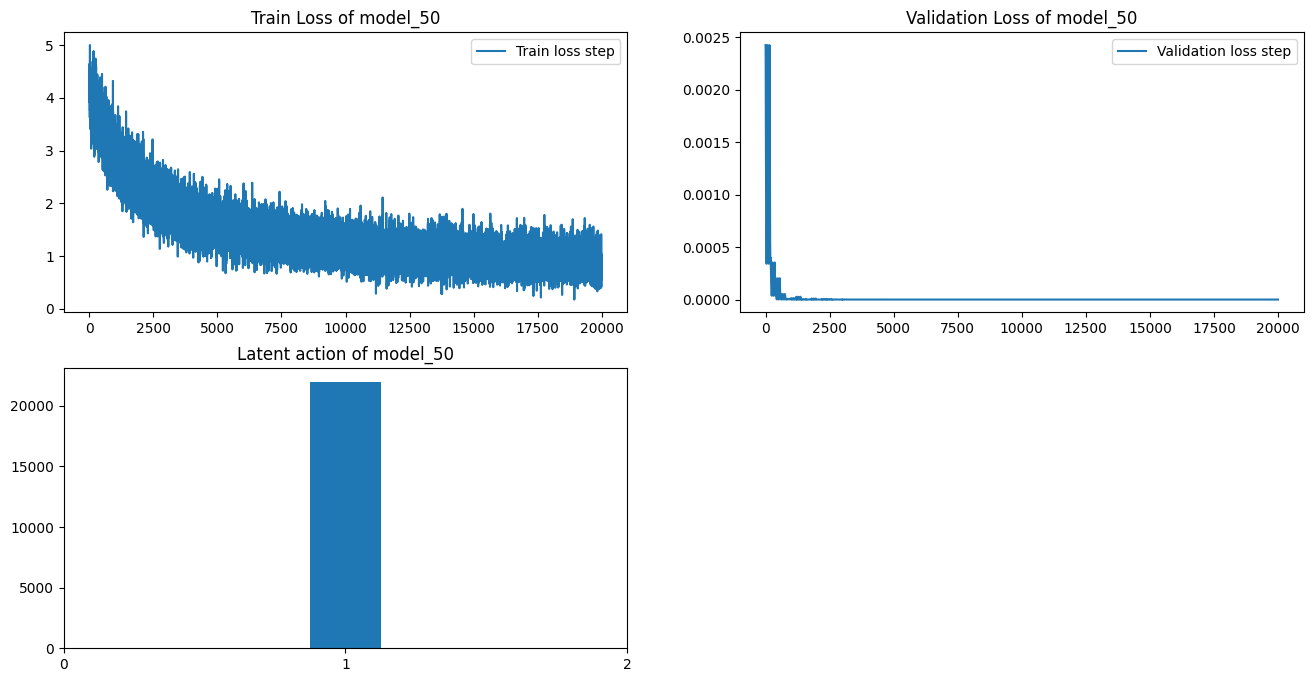

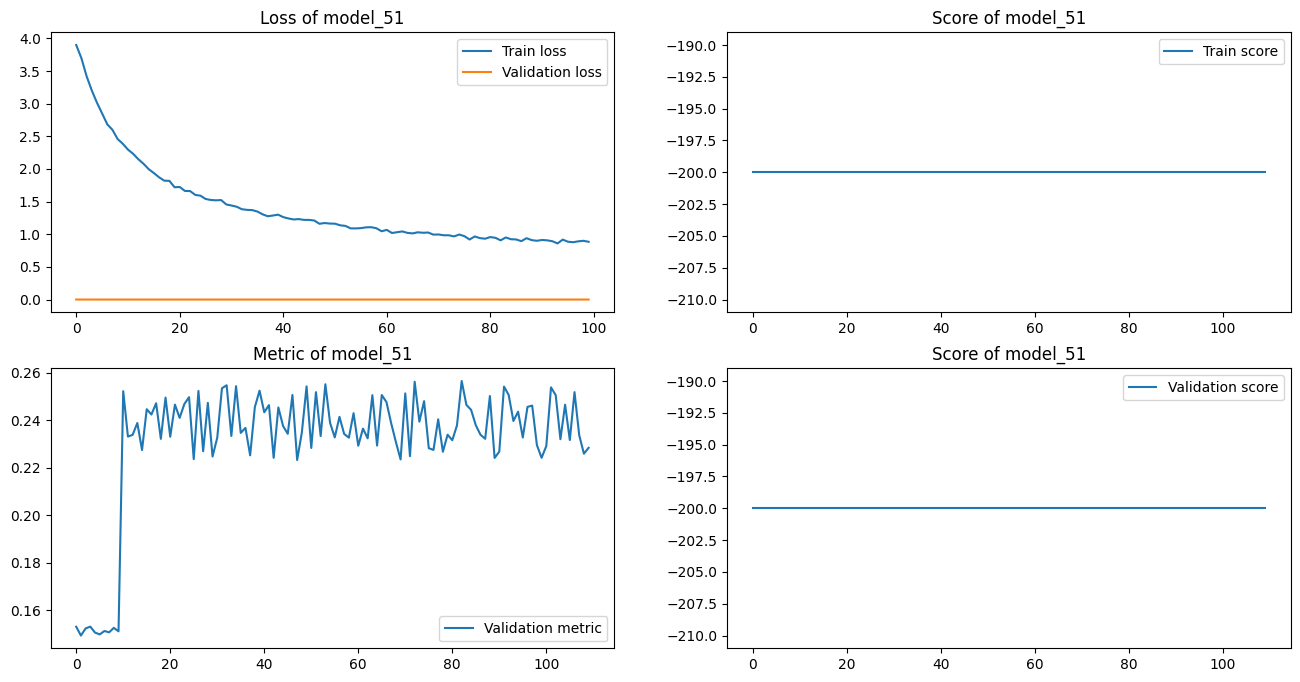

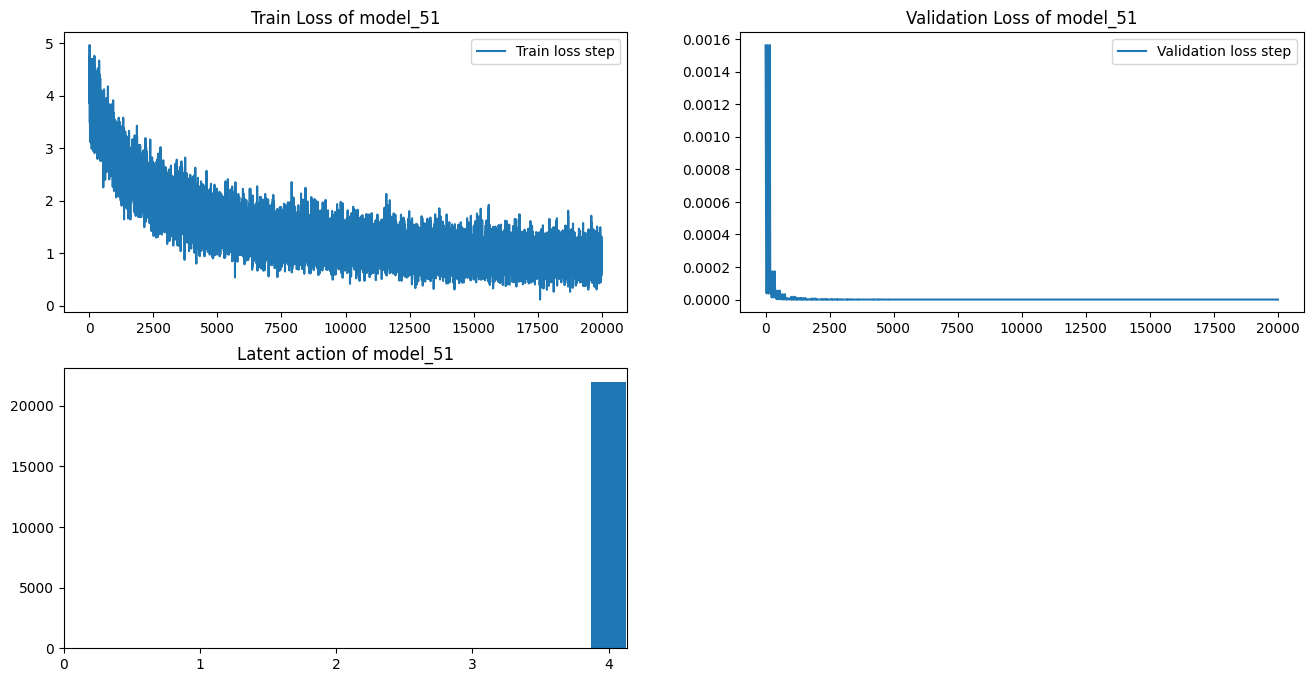

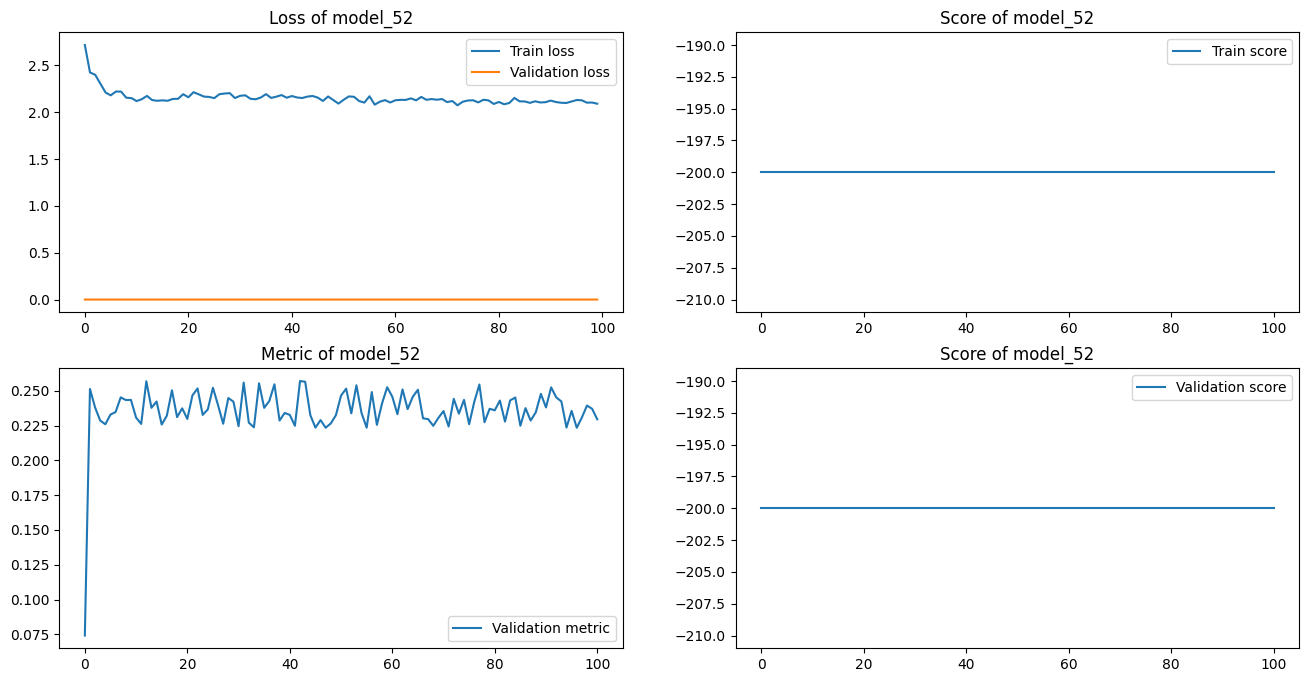

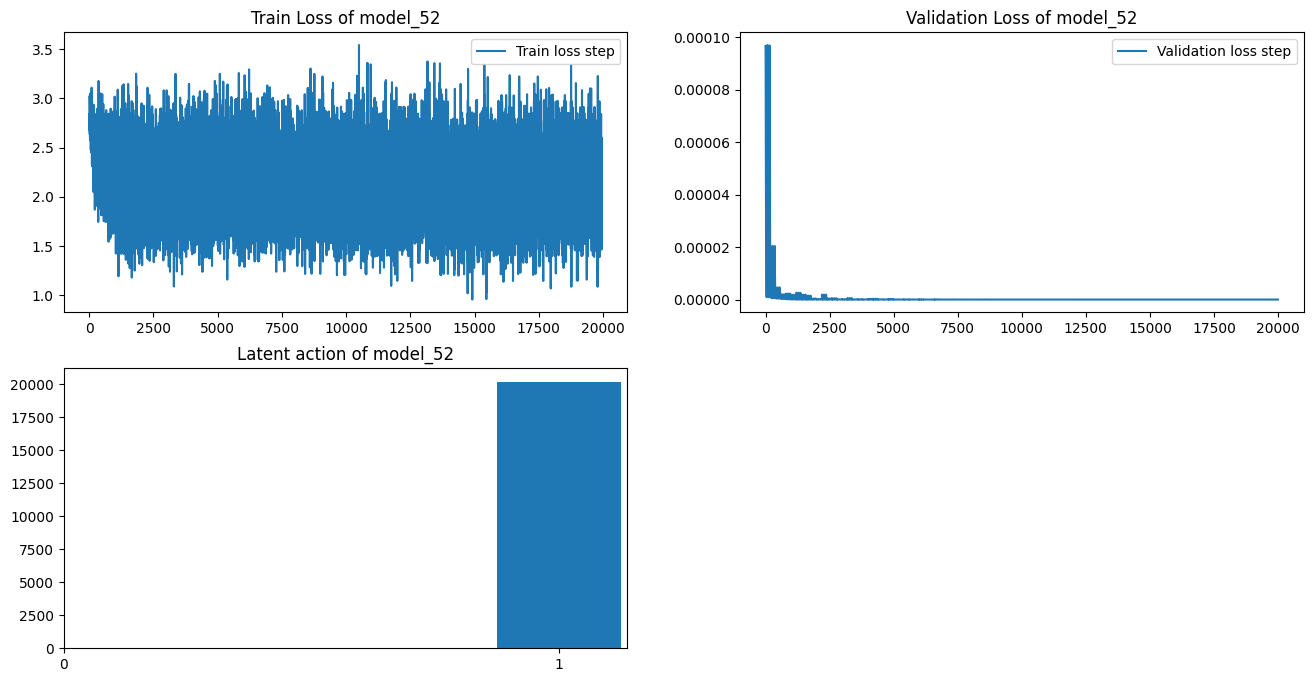

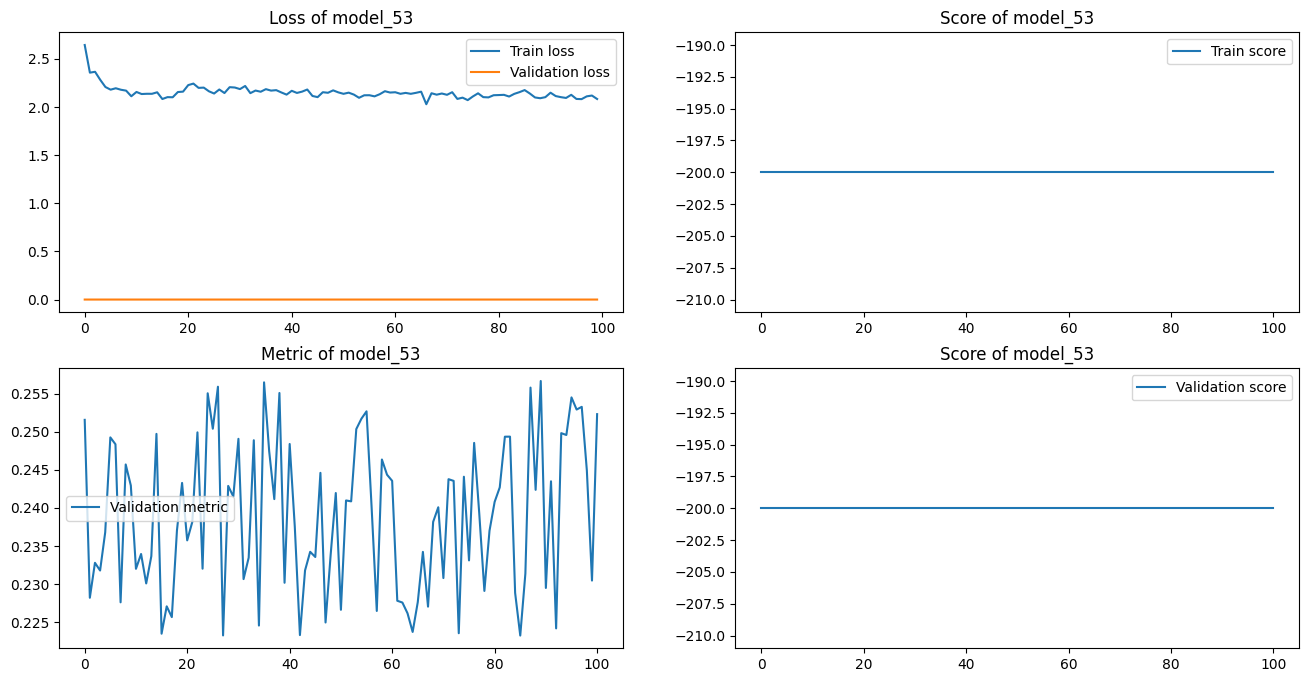

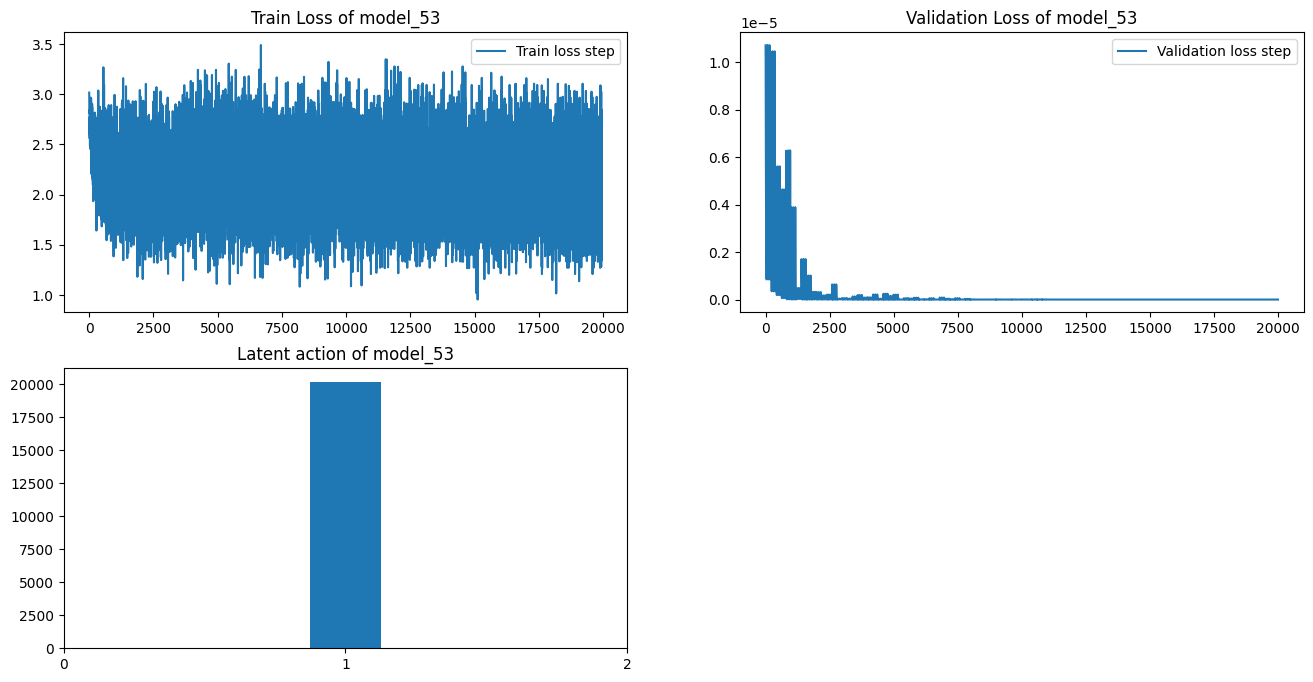

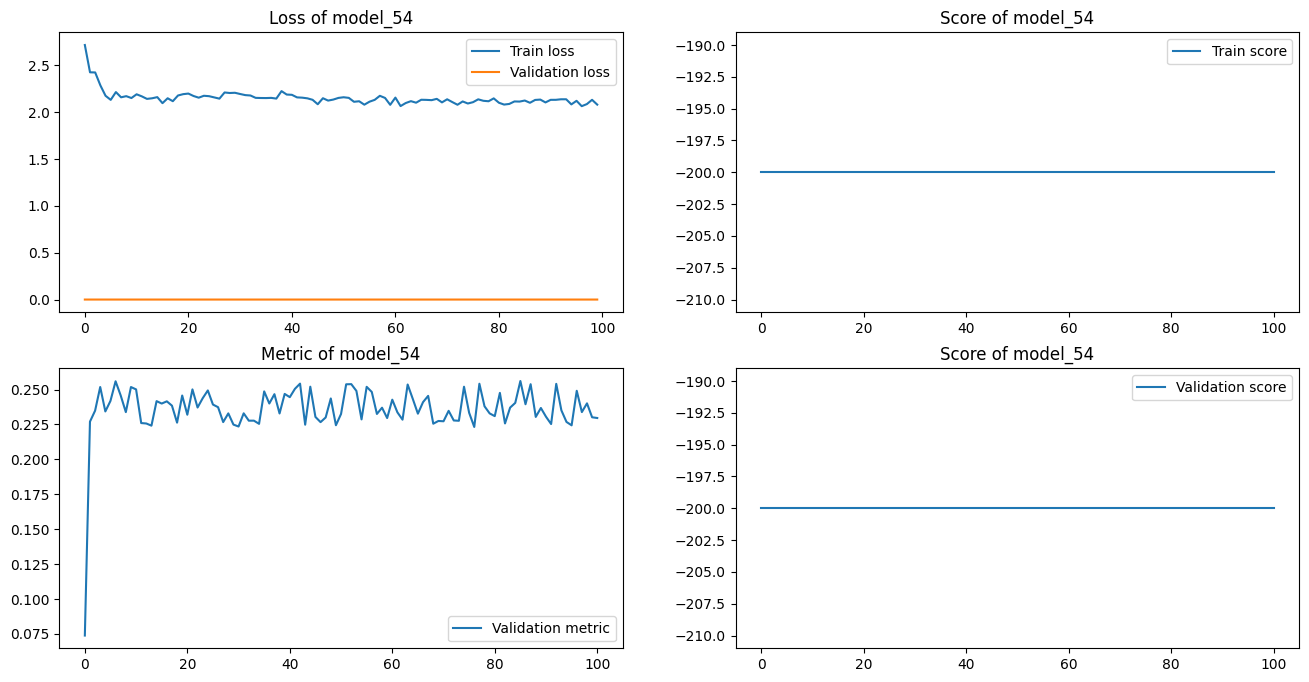

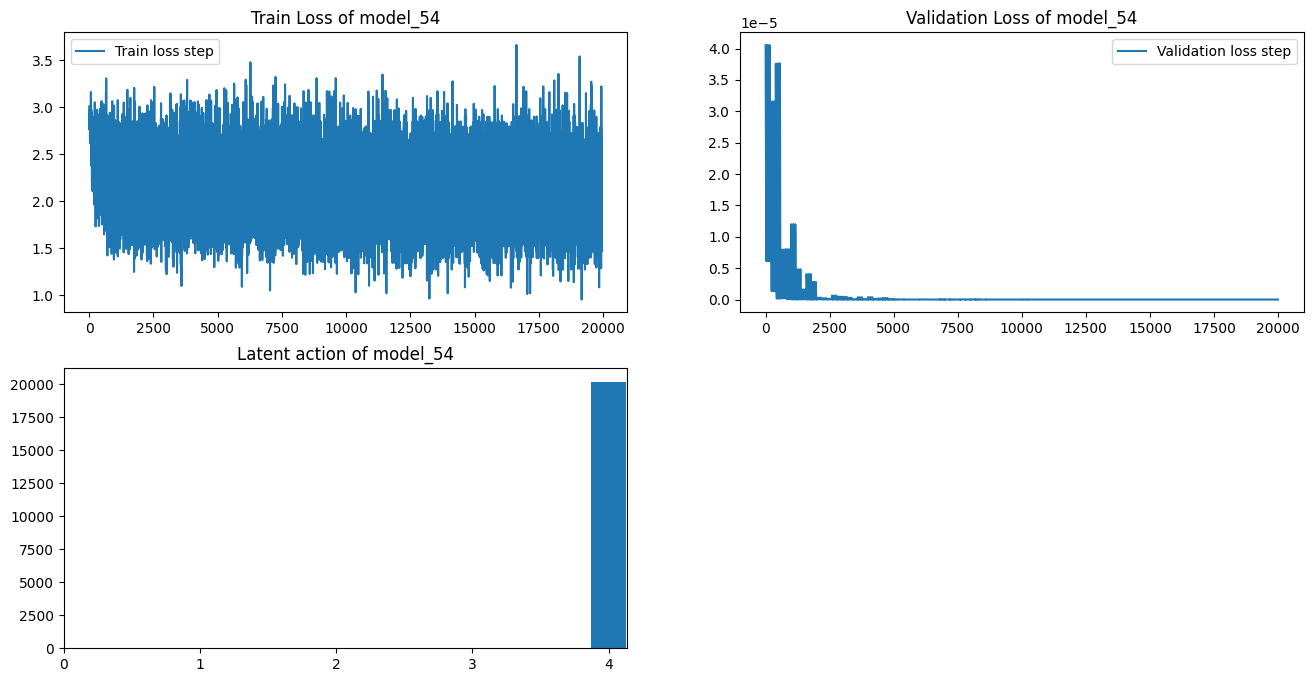

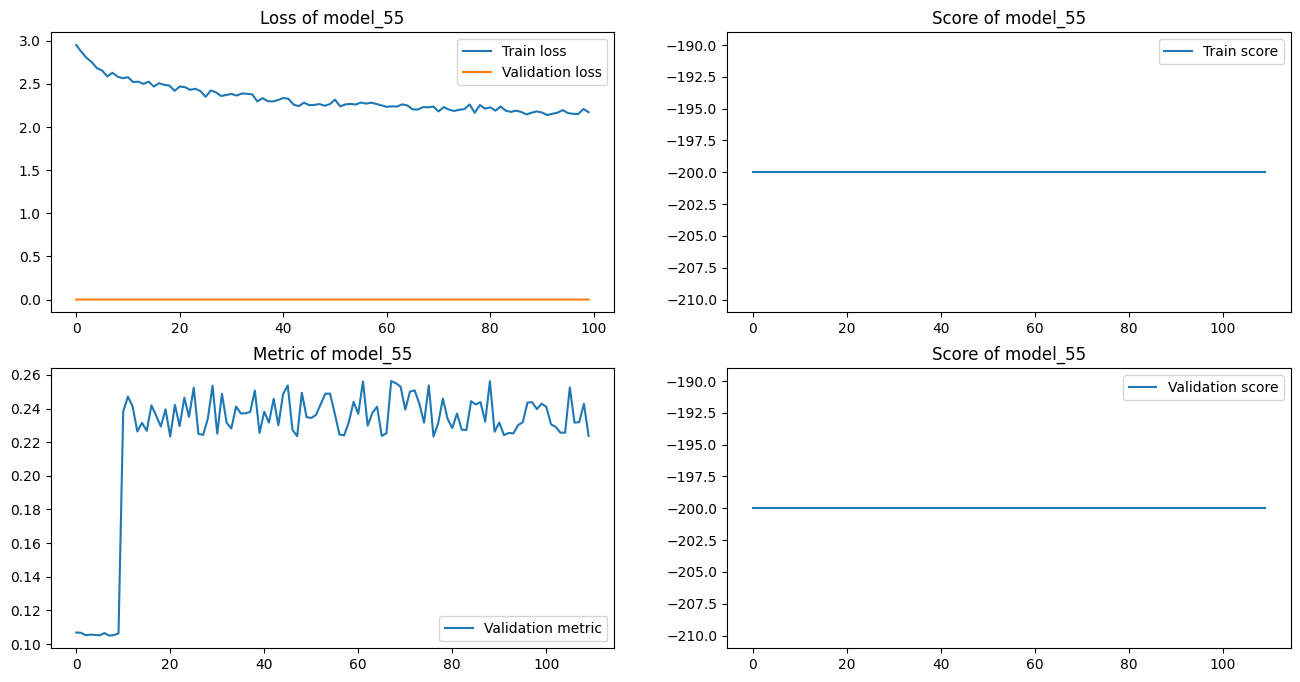

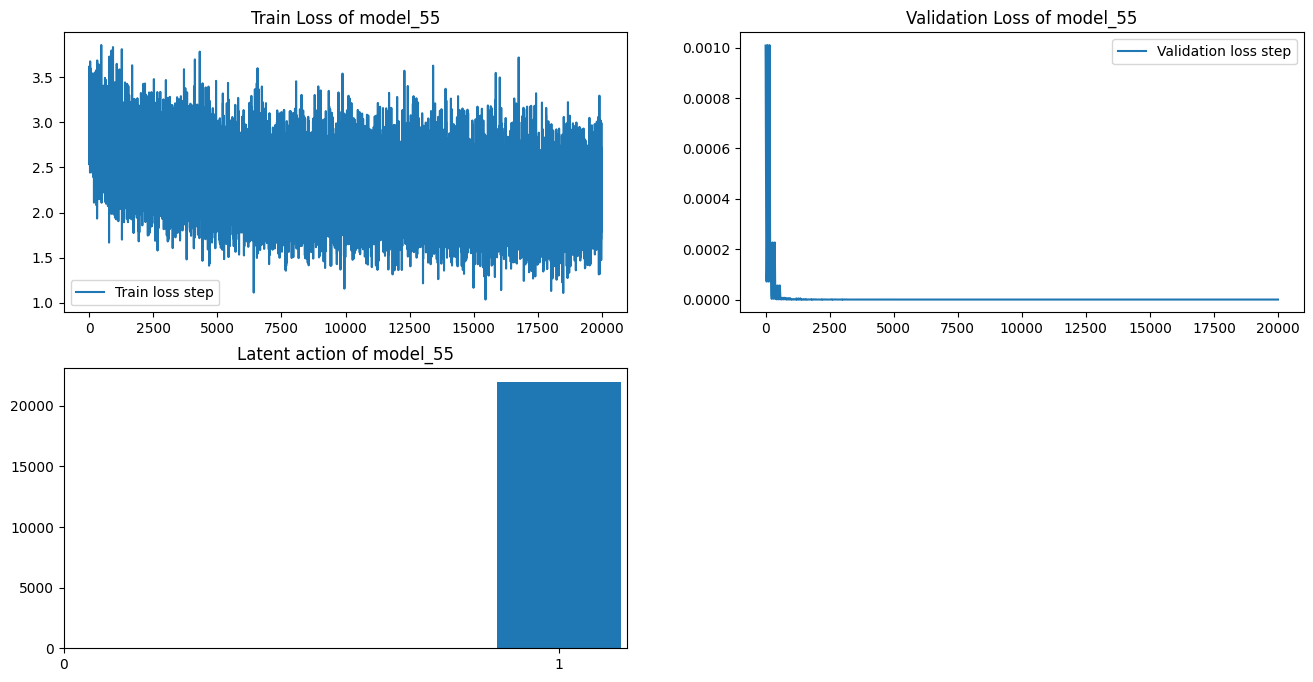

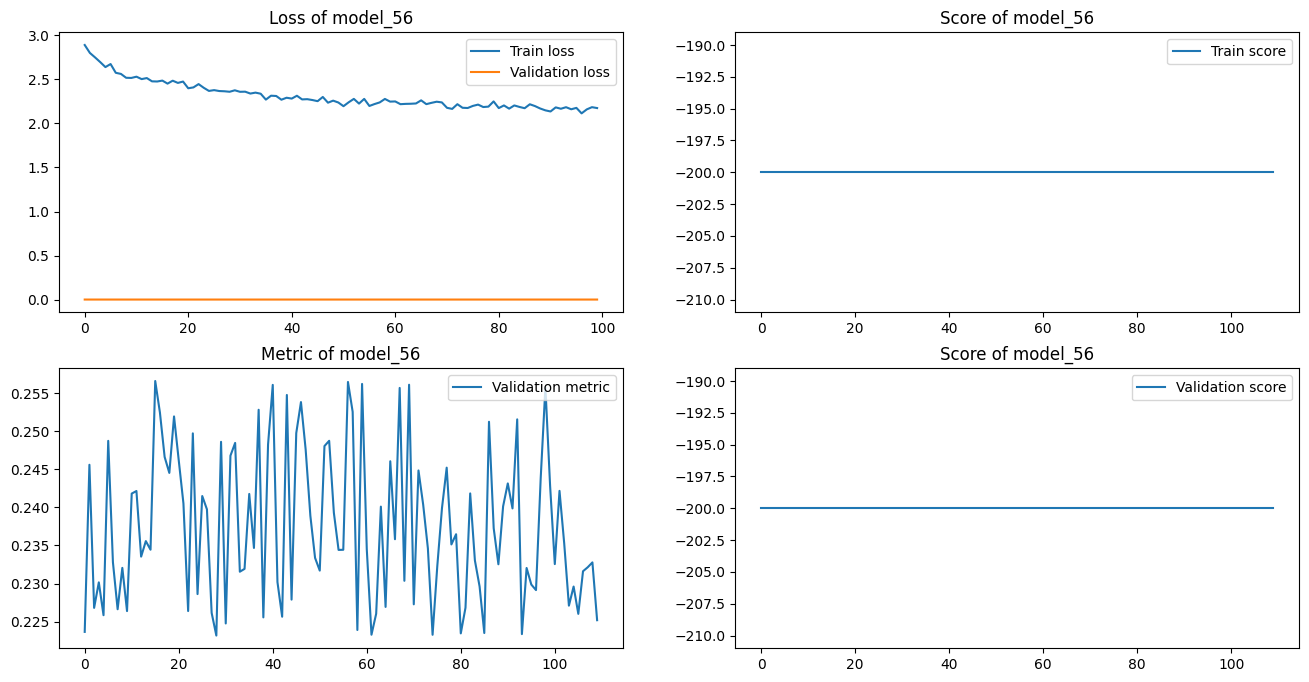

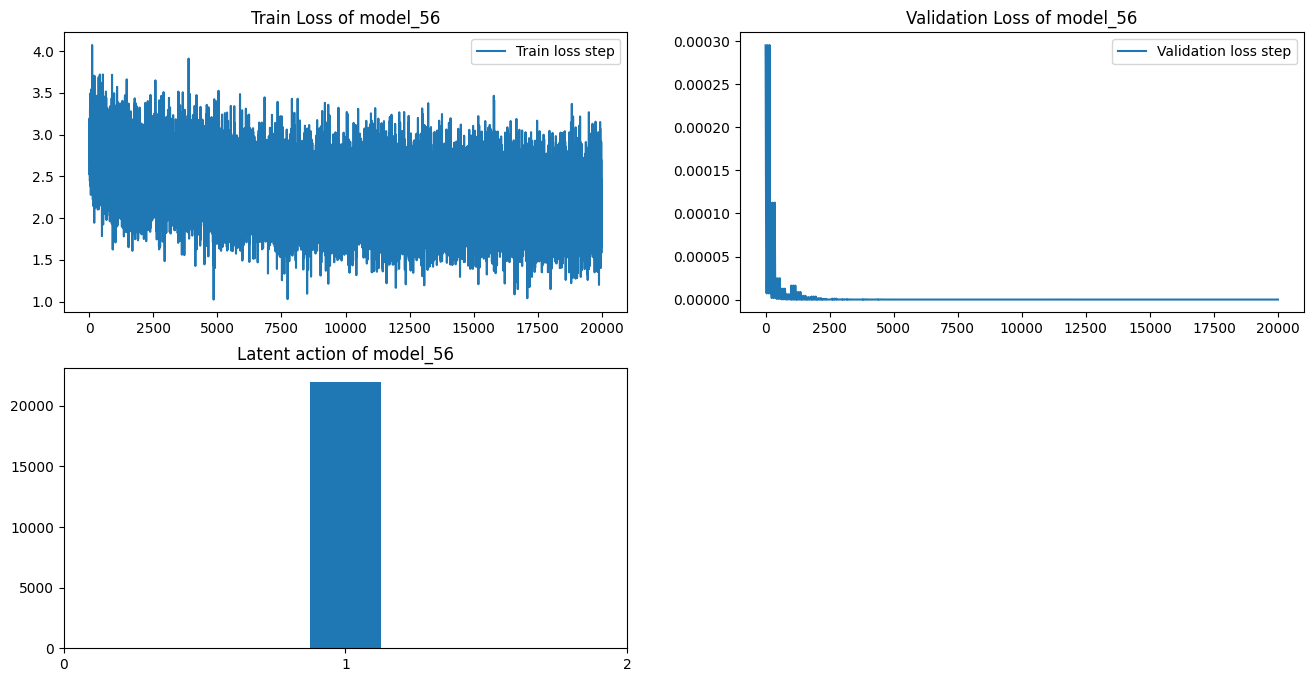

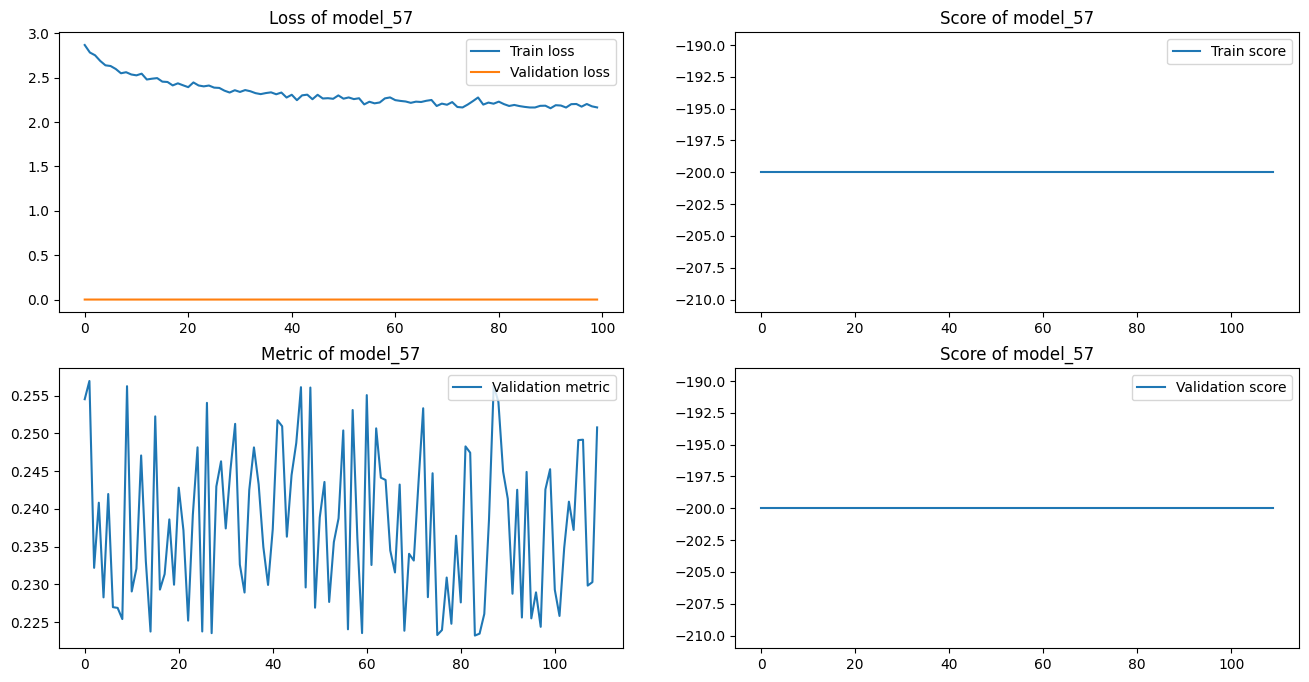

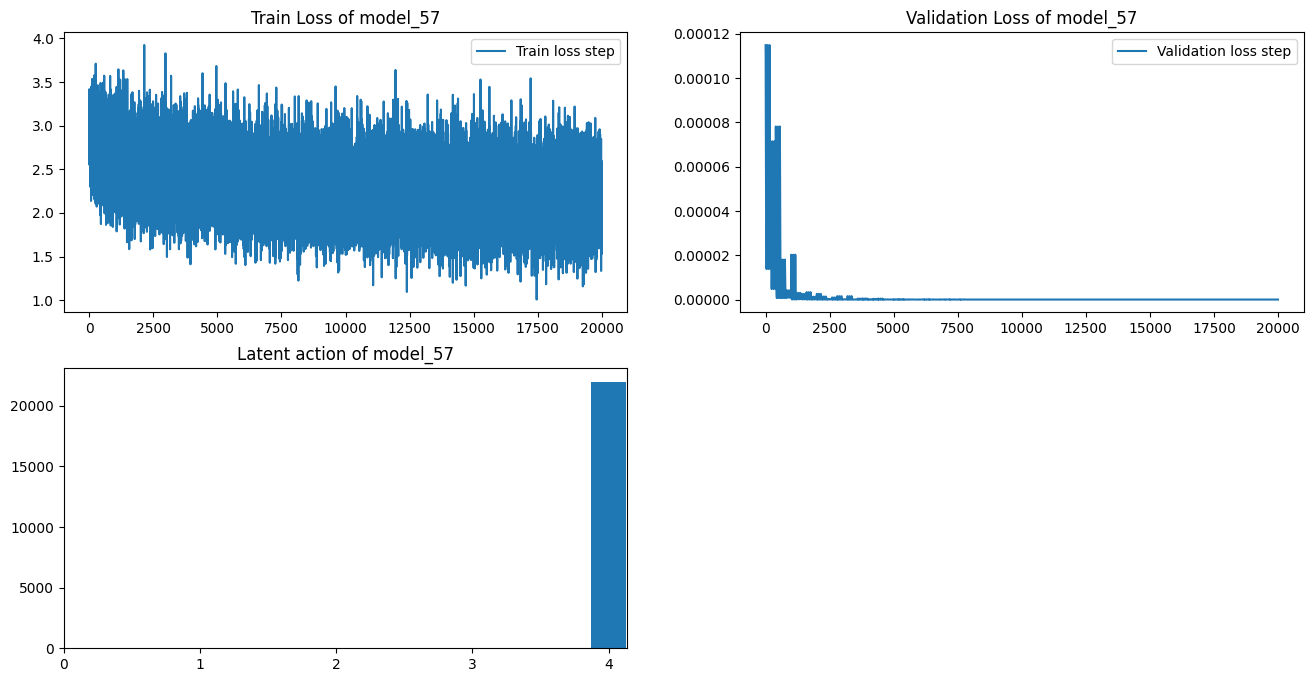

In [5]:
columns = ['rel_metric_pos', 'rel_metric_v']
for i in range(46,58,1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'MountainCar-v0', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'MountainCar-v0', 'train', f'model_{i}', 'validation_results.json')
    paths_config = os.path.join(os.getcwd(), 'runs', 'action_remap', 'MountainCar-v0', 'train', f'model_{i}', 'config.yaml')

    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    with open(paths_config) as f:
        dict_config = yaml.load(f, Loader=yaml.FullLoader)

    path_policy = os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'train', dict_config['model_name'], 'config.yaml')
    with open(path_policy) as f:
        dict_policy = yaml.load(f, Loader=yaml.FullLoader)

    train_loss = np.array(dict_train['loss'])
    train_loss_step = np.array(dict_train['loss_step'])
    train_score = np.array(dict_train['score'])
    train_episode = np.array(dict_train['episode'])

    val_loss = np.array(dict_val['loss'])
    val_loss_step = np.array(dict_val['loss_step'])
    val_z = np.array(dict_val['z'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_episode = np.array(dict_val['episode'])

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Score of model_{i}")
    plt.plot(train_score, label='Train score')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f"Metric of model_{i}")
    plt.plot(val_metric, label='Validation metric')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title(f"Score of model_{i}")
    plt.plot(val_score, label='Validation score')
    plt.legend()

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result1.png'))

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Train Loss of model_{i}")
    plt.plot(train_loss_step, label='Train loss step')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Validation Loss of model_{i}")
    plt.plot(val_loss_step, label='Validation loss step')
    plt.legend()

    plt.subplot(2,2,3)
    values, counts = np.unique(val_z, return_counts=True)
    plt.bar(values, counts, width = 0.25, align='center')
    plt.xticks(np.arange(dict_policy['n_latent_action']))
    plt.title(f"Latent action of model_{i}")

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result2.png'))

### Acrobot-v1

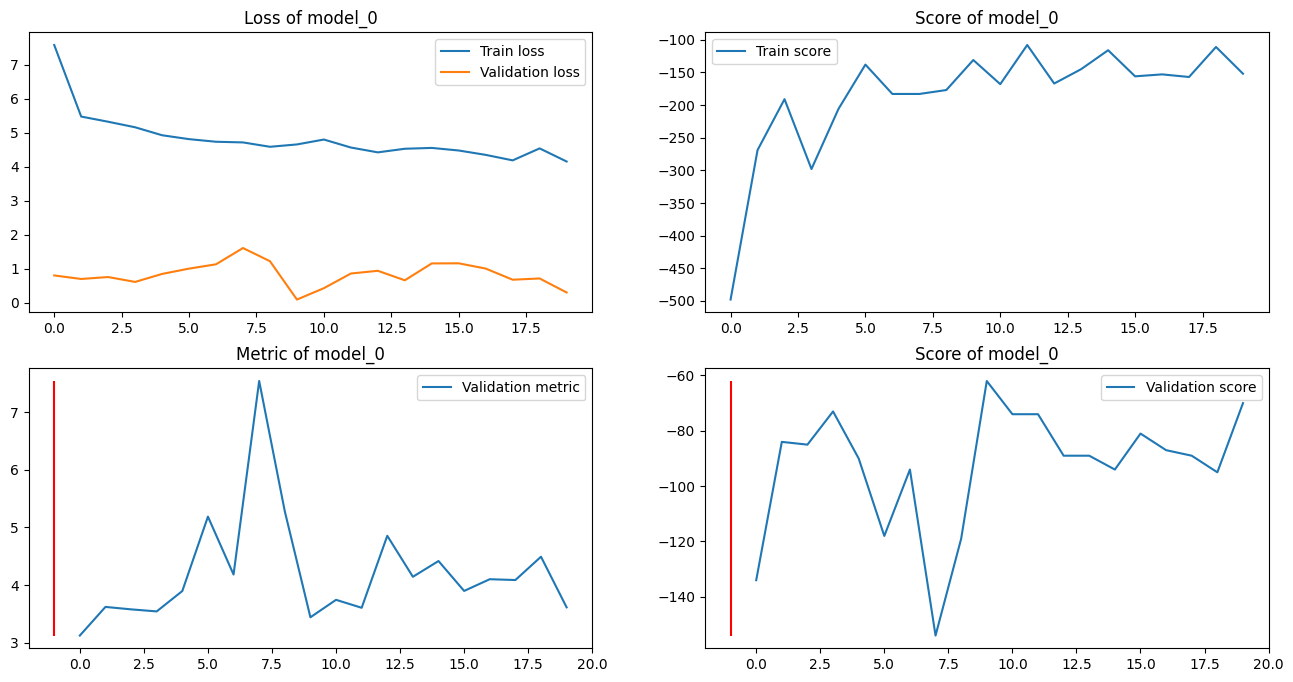

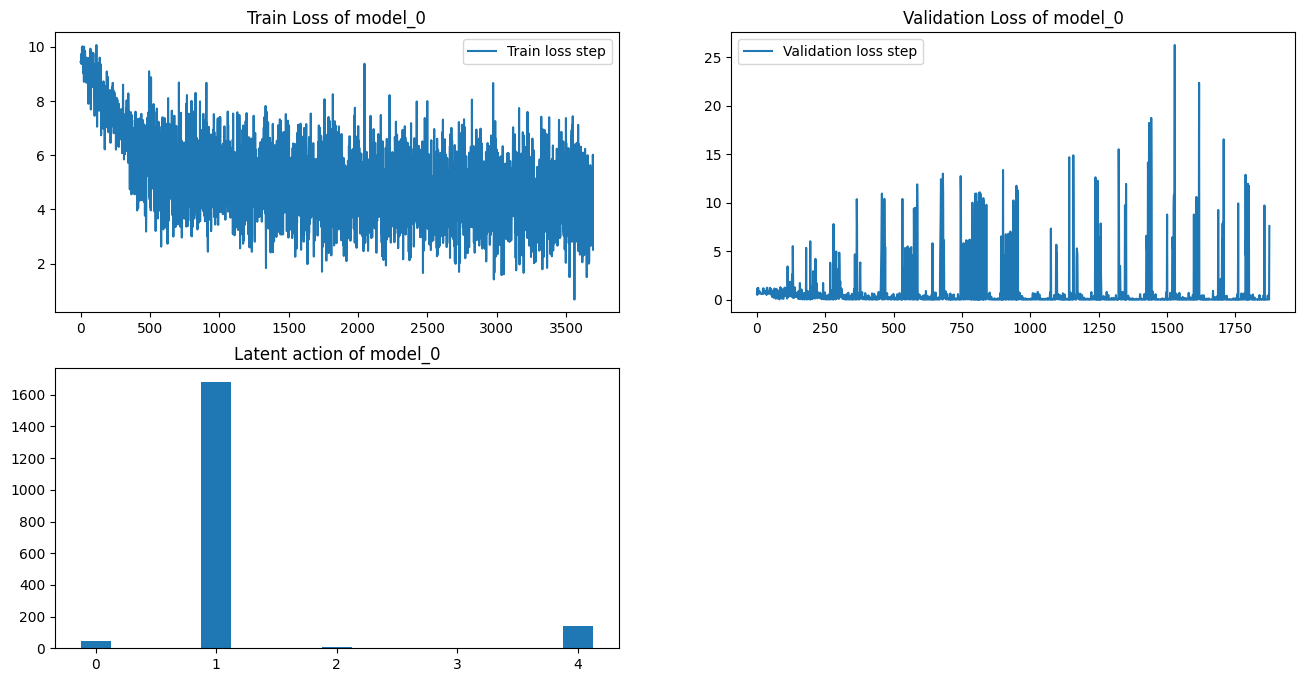

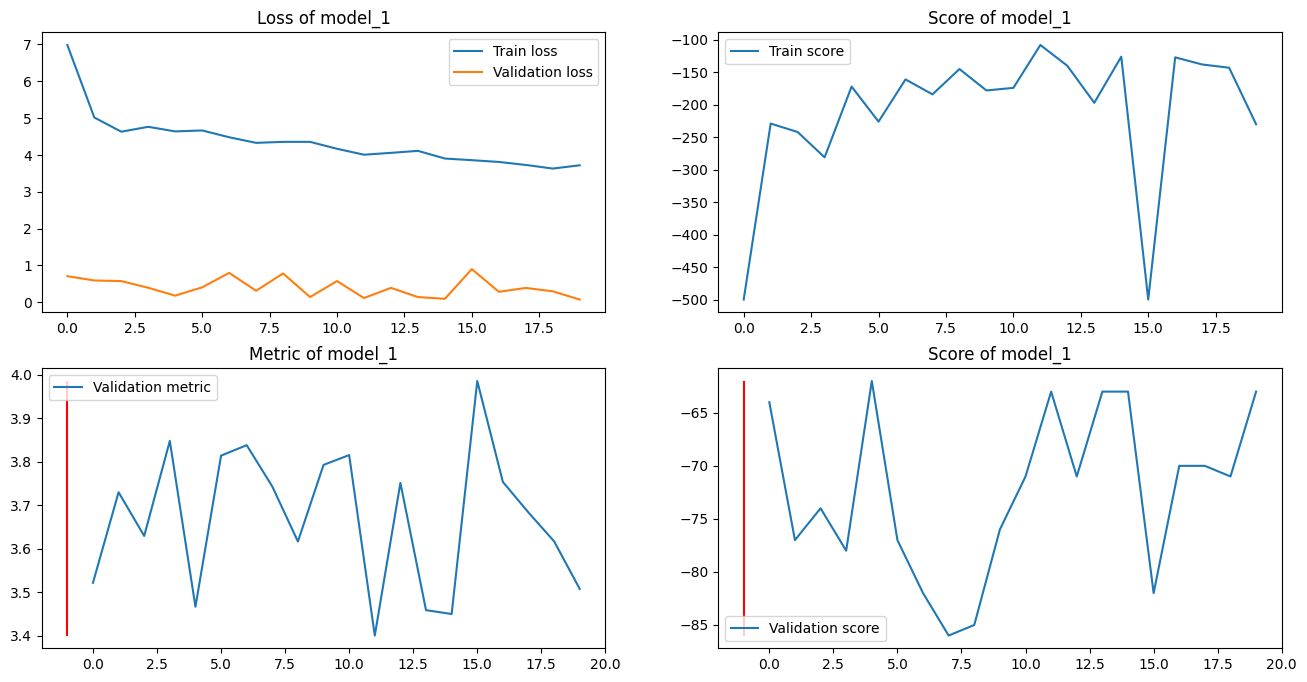

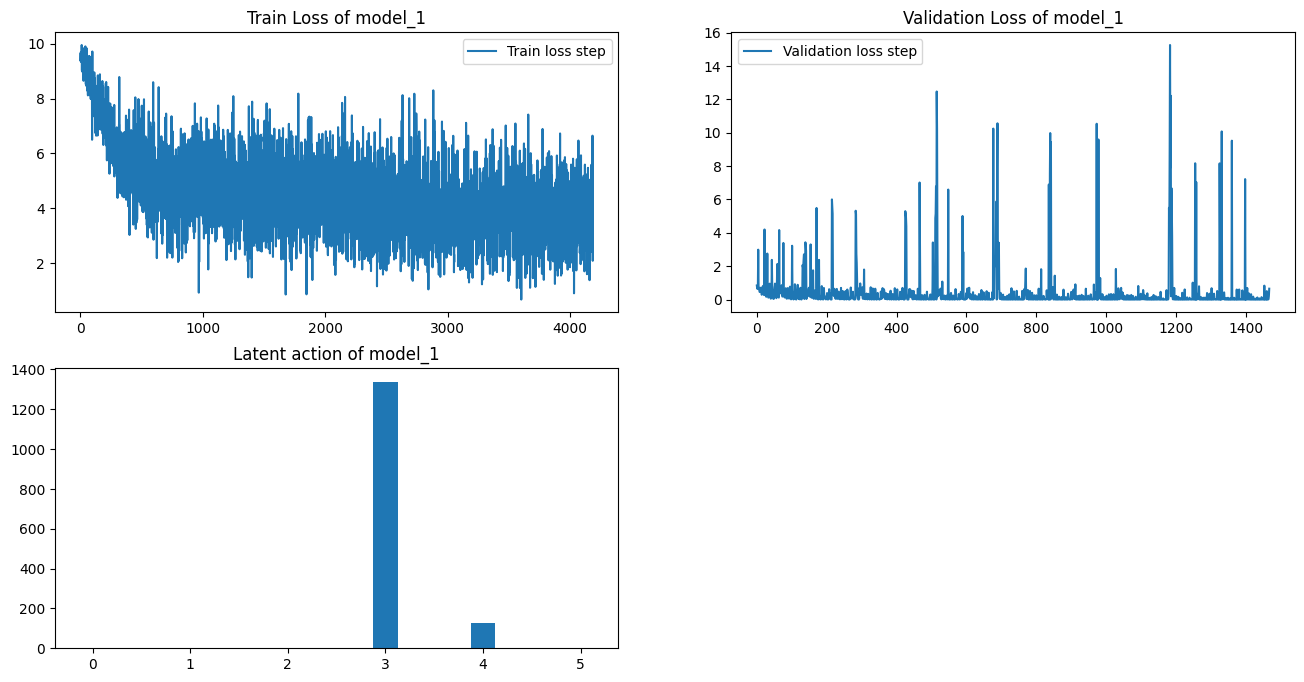

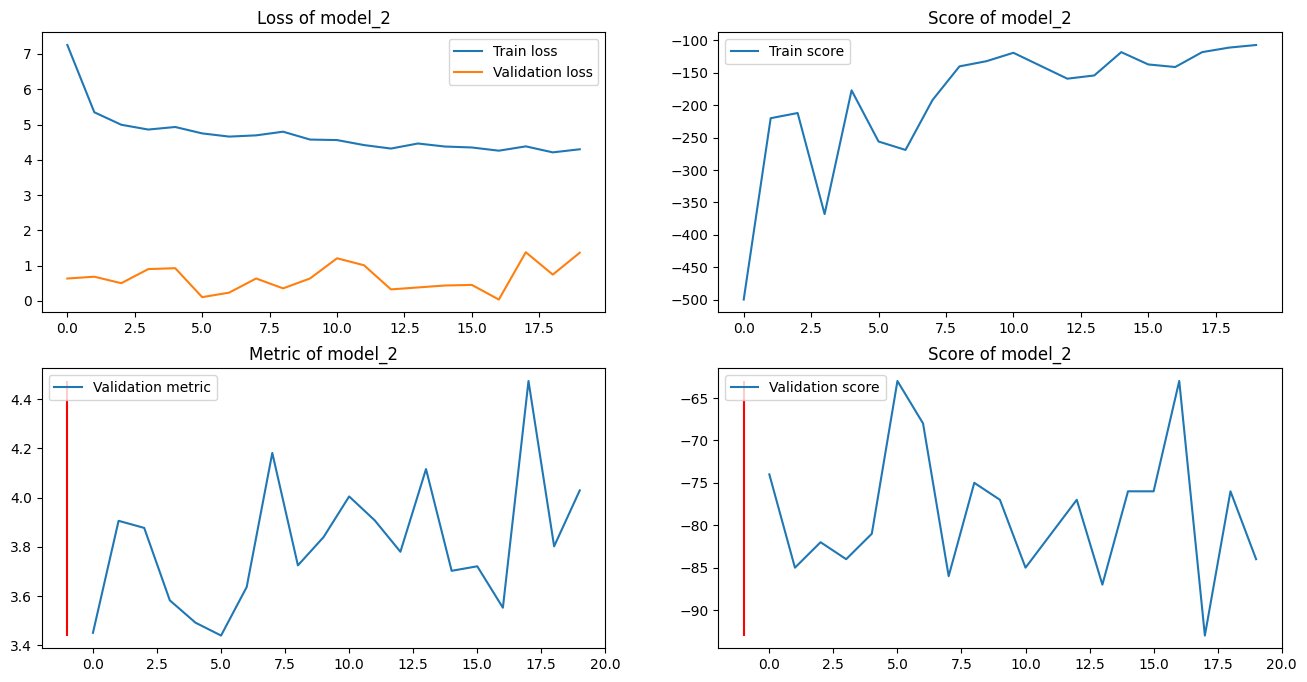

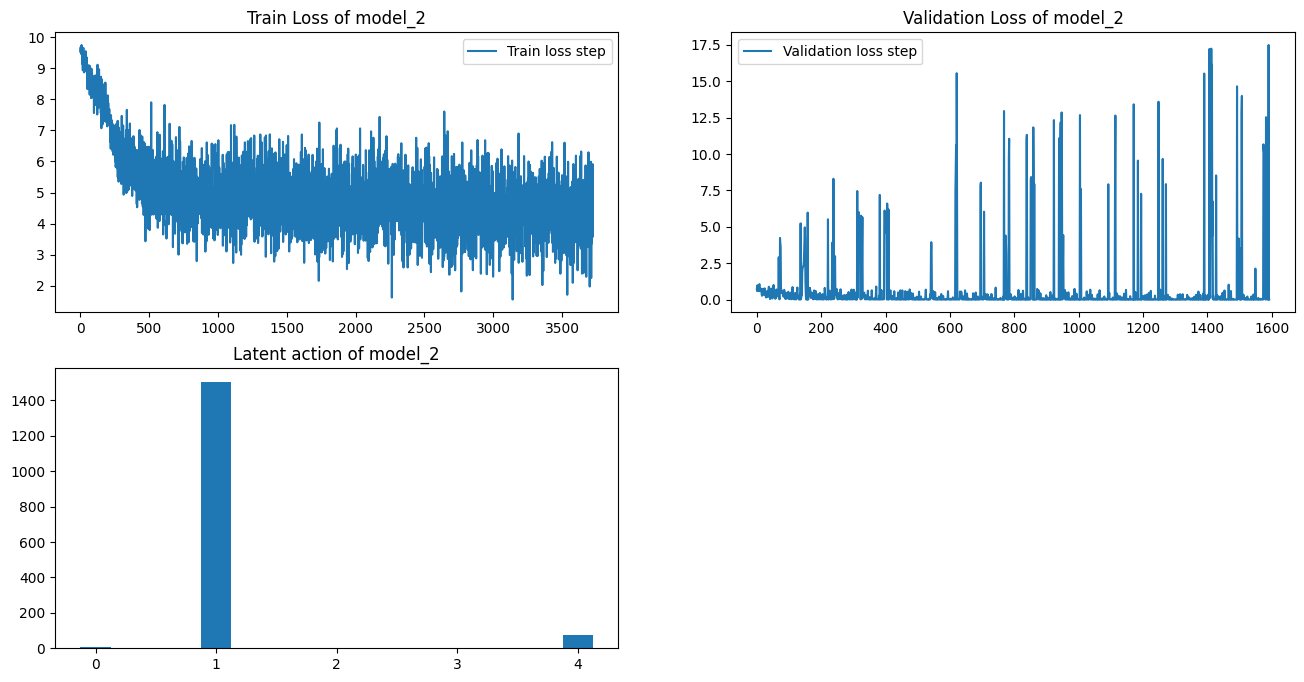

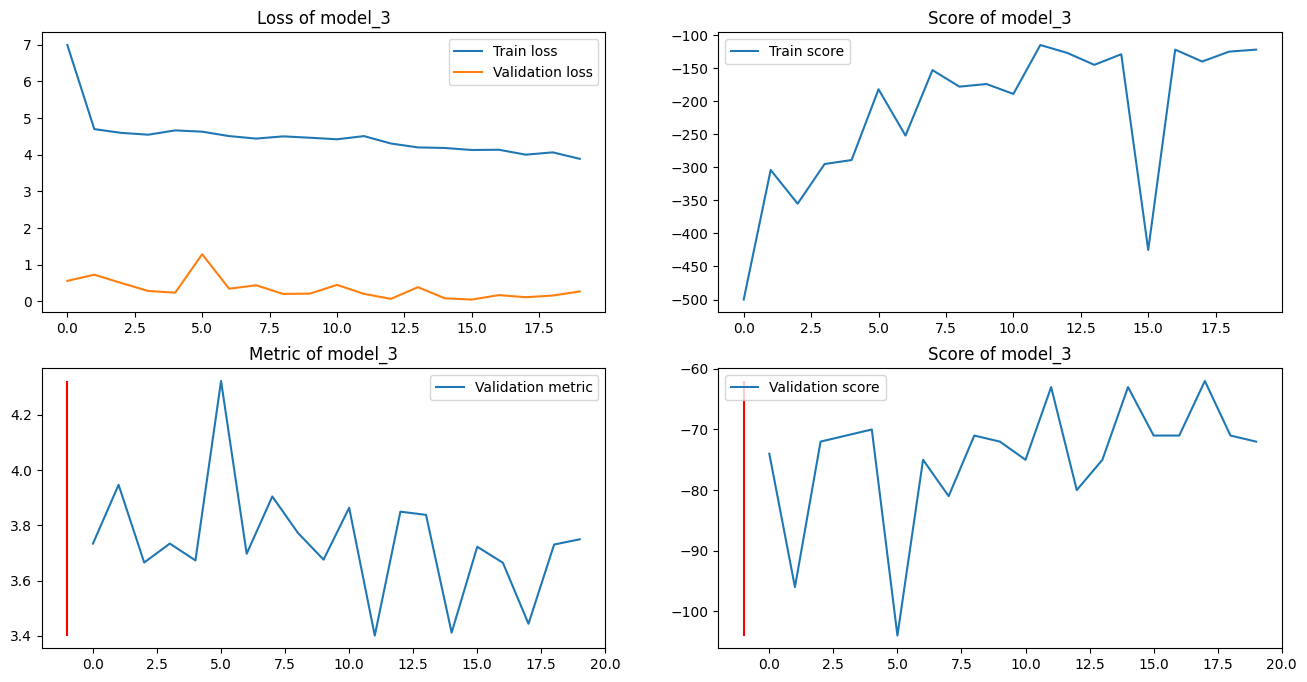

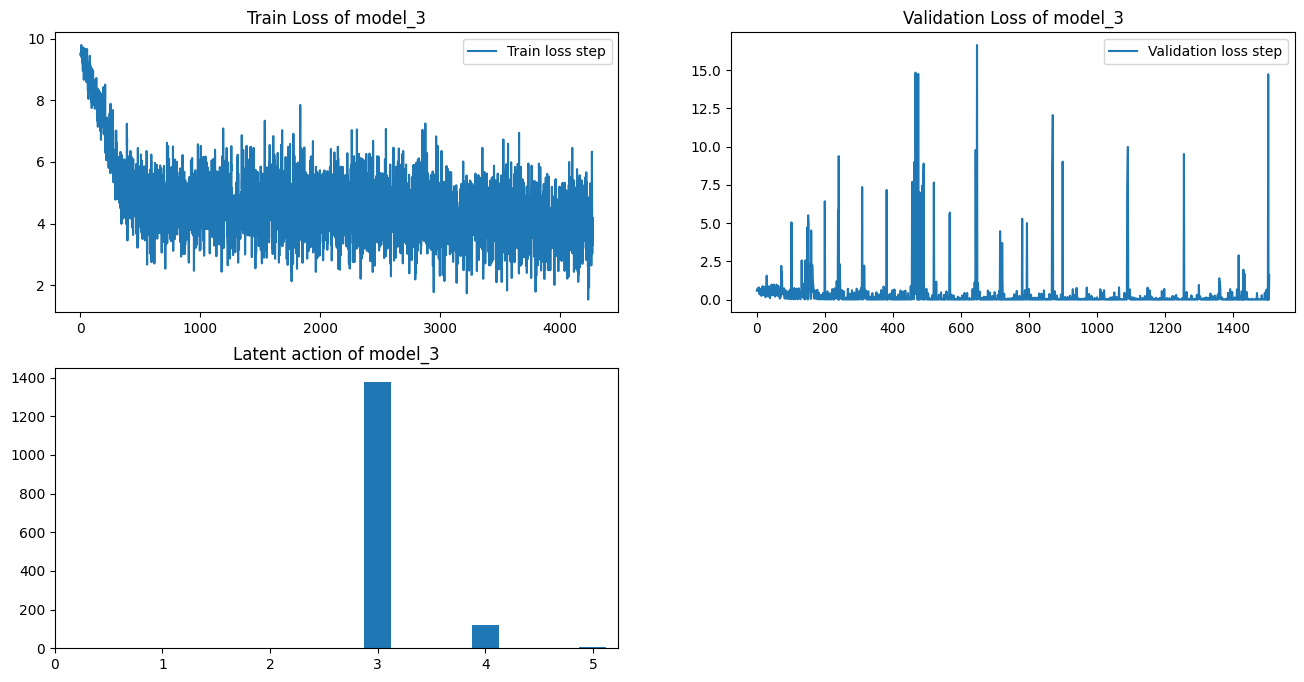

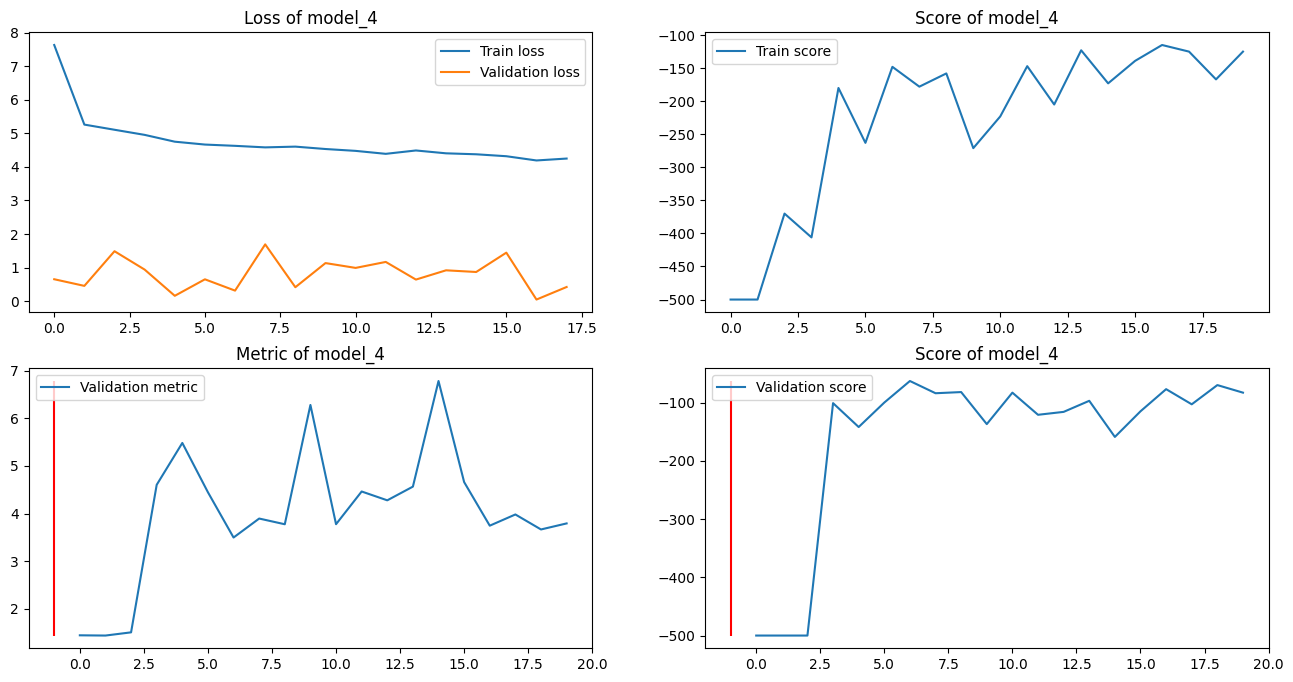

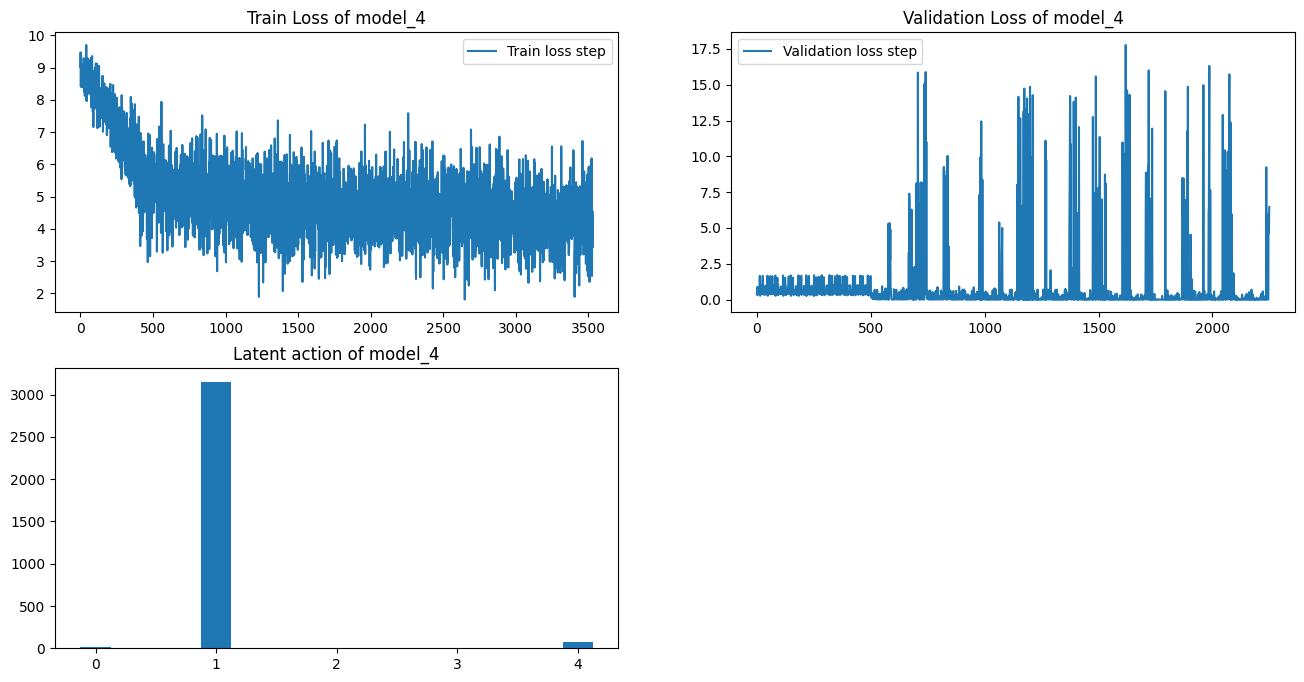

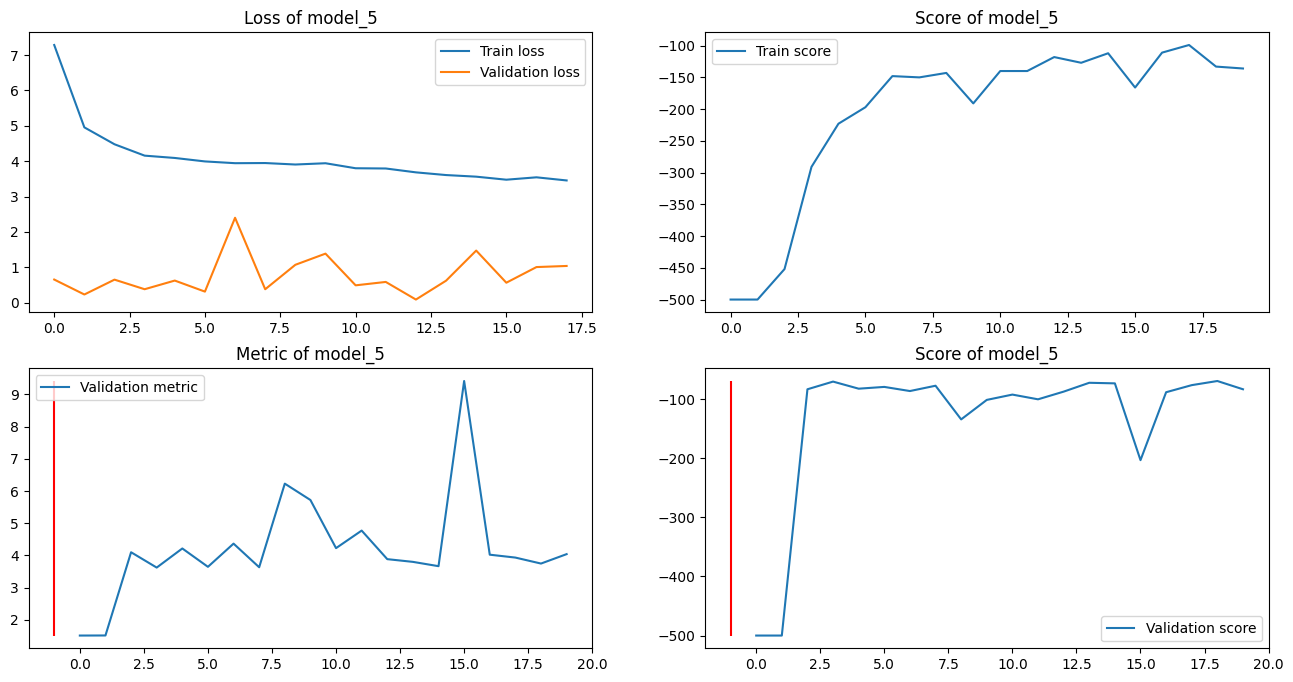

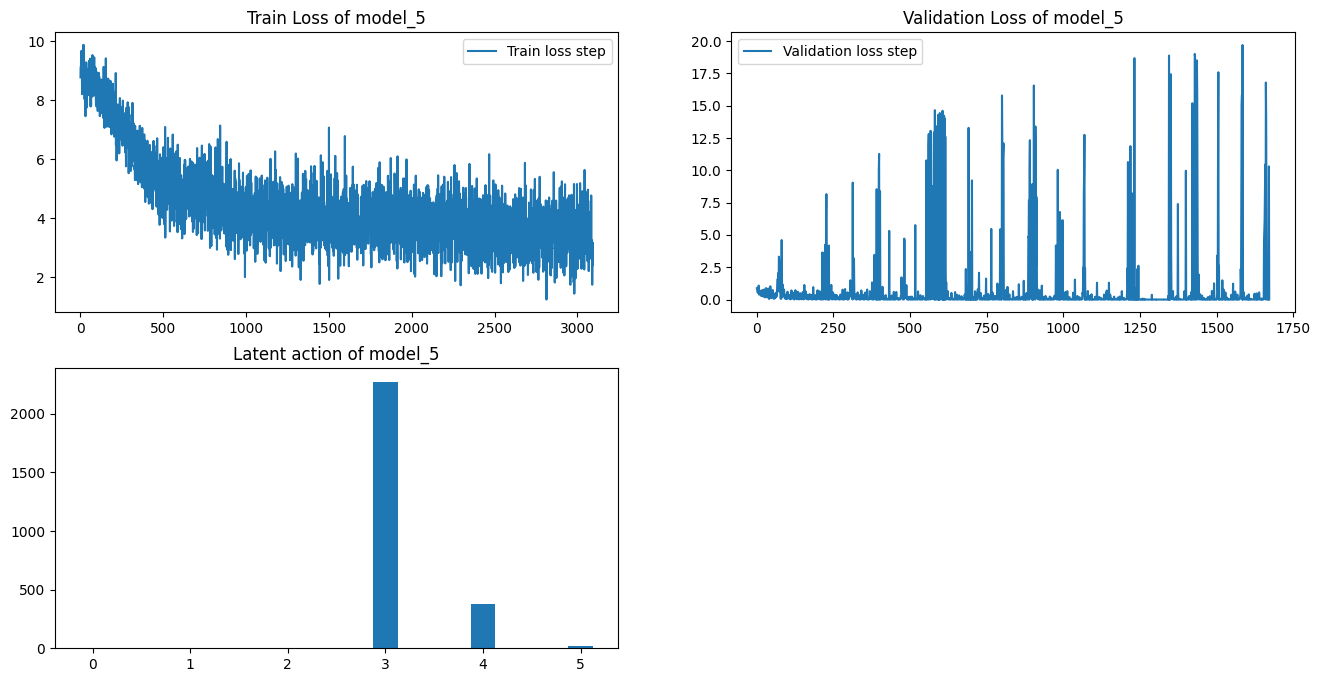

In [39]:
columns = ['rel_metric_cos1', 'rel_metric_sin1', 'rel_metric_cos2', 'rel_metric_sin2', 'rel_metric_w1', 'rel_metric_w1']
for i in range(6):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'Acrobot-v1', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'Acrobot-v1', 'train', f'model_{i}', 'validation_results.json')
    paths_config = os.path.join(os.getcwd(), 'runs', 'action_remap', 'Acrobot-v1', 'train', f'model_{i}', 'config.yaml')

    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    with open(paths_config) as f:
        dict_config = yaml.load(f, Loader=yaml.FullLoader)

    path_policy = os.path.join(os.getcwd(), 'runs', 'policy', 'Acrobot-v1', 'train', dict_config['model_name'], 'config.yaml')
    with open(path_policy) as f:
        dict_policy = yaml.load(f, Loader=yaml.FullLoader)

    train_loss = np.array(dict_train['loss'])
    train_loss_step = np.array(dict_train['loss_step'])
    train_score = np.array(dict_train['score'])
    train_episode = np.array(dict_train['episode'])

    val_loss = np.array(dict_val['loss'])
    val_loss_step = np.array(dict_val['loss_step'])
    val_z = np.array(dict_val['z'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_episode = np.array(dict_val['episode'])

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Score of model_{i}")
    plt.plot(train_score, label='Train score')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f"Metric of model_{i}")
    plt.plot(val_metric, label='Validation metric')
    plt.vlines(len(val_metric) - dict_config['patience'] - 1, np.min(val_metric), np.max(val_metric), colors='red')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title(f"Score of model_{i}")
    plt.plot(val_score, label='Validation score')
    plt.vlines(len(val_score) - dict_config['patience'] - 1, np.min(val_score), np.max(val_score), colors='red')
    plt.legend()

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result1.png'))

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.title(f"Train Loss of model_{i}")
    plt.plot(train_loss_step, label='Train loss step')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Validation Loss of model_{i}")
    plt.plot(val_loss_step, label='Validation loss step')
    plt.legend()

    plt.subplot(2,2,3)
    values, counts = np.unique(val_z, return_counts=True)
    plt.bar(values, counts, width = 0.25, align='center')
    plt.xticks(np.arange(dict_policy['n_latent_action']))
    plt.title(f"Latent action of model_{i}")

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result2.png'))

In [103]:
z_p = tf.constant([[0.,0.]], dtype=tf.float32)
int(tf.argmax(tf.reshape(z_p, (2,)), axis=-1).numpy())

0